## Run REST2 on bnbs (flattened torsions/exceptions) apo

In [1]:
import pickle
import os
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTStateV2
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np


INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# Load in r-htf at endstate = 1
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/43"
htf = pickle.load(open(os.path.join(out_dir, f"43_complex_1.pickle"), "rb" ))


In [4]:
for i in range(htf.hybrid_system.getNumForces()):
    print(htf.hybrid_system.getForce(i))
    

<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b8b8f8e1690> >
<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b8b8f8e1690> >
<simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b8bbec0e0c0> >
<simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b8b8f8e1690> >
<simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b8bbec0e0c0> >


In [5]:
# Determine indices for solute region
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE0-CH3
1 ACE0-C
2 ACE0-O
3 ACE0-H1
4 ACE0-H2
5 ACE0-H3
6 LYS1-N
7 LYS1-CA
8 LYS1-C
9 LYS1-O
10 LYS1-CB
11 LYS1-CG
12 LYS1-CD
13 LYS1-CE
14 LYS1-NZ
15 LYS1-H2
16 LYS1-HA
17 LYS1-HB3
18 LYS1-HB2
19 LYS1-HG2
20 LYS1-HG3
21 LYS1-HD2
22 LYS1-HD3
23 LYS1-HE3
24 LYS1-HE2
25 LYS1-HZ1
26 LYS1-HZ2
27 LYS1-HZ3
28 LYS2-N
29 LYS2-CA
30 LYS2-C
31 LYS2-O
32 LYS2-CB
33 LYS2-CG
34 LYS2-CD
35 LYS2-CE
36 LYS2-NZ
37 LYS2-H
38 LYS2-HA
39 LYS2-HB3
40 LYS2-HB2
41 LYS2-HG2
42 LYS2-HG3
43 LYS2-HD3
44 LYS2-HD2
45 LYS2-HE3
46 LYS2-HE2
47 LYS2-HZ1
48 LYS2-HZ2
49 LYS2-HZ3
50 ALA3-N
51 ALA3-CA
52 ALA3-C
53 ALA3-O
54 ALA3-CB
55 ALA3-H
56 ALA3-HA
57 ALA3-HB1
58 ALA3-HB2
59 ALA3-HB3
60 VAL4-N
61 VAL4-CA
62 VAL4-C
63 VAL4-O
64 VAL4-CB
65 VAL4-CG1
66 VAL4-CG2
67 VAL4-H
68 VAL4-HA
69 VAL4-HB
70 VAL4-HG11
71 VAL4-HG12
72 VAL4-HG13
73 VAL4-HG21
74 VAL4-HG22
75 VAL4-HG23
76 ILE5-N
77 ILE5-CA
78 ILE5-C
79 ILE5-O
80 ILE5-CB
81 ILE5-CG1
82 ILE5-CG2
83 ILE5-CD1
84 ILE5-H
85 ILE5-HA
86 ILE5-HB
87 ILE5-HG13
88 ILE5-HG12
89 IL

706 TRP44-HE3
707 TRP44-HZ2
708 TRP44-HZ3
709 TRP44-HH2
710 VAL45-N
711 VAL45-CA
712 VAL45-C
713 VAL45-O
714 VAL45-CB
715 VAL45-CG1
716 VAL45-CG2
717 VAL45-H
718 VAL45-HA
719 VAL45-HB
720 VAL45-HG11
721 VAL45-HG12
722 VAL45-HG13
723 VAL45-HG21
724 VAL45-HG22
725 VAL45-HG23
726 GLU46-N
727 GLU46-CA
728 GLU46-C
729 GLU46-O
730 GLU46-CB
731 GLU46-CG
732 GLU46-CD
733 GLU46-OE1
734 GLU46-OE2
735 GLU46-H
736 GLU46-HA
737 GLU46-HB3
738 GLU46-HB2
739 GLU46-HG3
740 GLU46-HG2
741 TYR47-N
742 TYR47-CA
743 TYR47-C
744 TYR47-O
745 TYR47-CB
746 TYR47-CG
747 TYR47-CD1
748 TYR47-CD2
749 TYR47-CE1
750 TYR47-CE2
751 TYR47-CZ
752 TYR47-OH
753 TYR47-H
754 TYR47-HA
755 TYR47-HB3
756 TYR47-HB2
757 TYR47-HD1
758 TYR47-HD2
759 TYR47-HE1
760 TYR47-HE2
761 TYR47-HH
762 PRO48-N
763 PRO48-CA
764 PRO48-C
765 PRO48-O
766 PRO48-CB
767 PRO48-CG
768 PRO48-CD
769 PRO48-HA
770 PRO48-HB3
771 PRO48-HB2
772 PRO48-HG3
773 PRO48-HG2
774 PRO48-HD2
775 PRO48-HD3
776 LEU49-N
777 LEU49-CA
778 LEU49-C
779 LEU49-O
780 LEU49-CB
781

1706 LYS19-HB2
1707 LYS19-HB3
1708 LYS19-HG3
1709 LYS19-HG2
1710 LYS19-HD3
1711 LYS19-HD2
1712 LYS19-HE3
1713 LYS19-HE2
1714 LYS19-HZ1
1715 LYS19-HZ2
1716 LYS19-HZ3
1717 LEU20-N
1718 LEU20-CA
1719 LEU20-C
1720 LEU20-O
1721 LEU20-CB
1722 LEU20-CG
1723 LEU20-CD1
1724 LEU20-CD2
1725 LEU20-H
1726 LEU20-HA
1727 LEU20-HB3
1728 LEU20-HB2
1729 LEU20-HG
1730 LEU20-HD11
1731 LEU20-HD12
1732 LEU20-HD13
1733 LEU20-HD21
1734 LEU20-HD22
1735 LEU20-HD23
1736 PRO21-N
1737 PRO21-CA
1738 PRO21-C
1739 PRO21-O
1740 PRO21-CB
1741 PRO21-CG
1742 PRO21-CD
1743 PRO21-HA
1744 PRO21-HB3
1745 PRO21-HB2
1746 PRO21-HG3
1747 PRO21-HG2
1748 PRO21-HD2
1749 PRO21-HD3
1750 ASP22-N
1751 ASP22-CA
1752 ASP22-C
1753 ASP22-O
1754 ASP22-CB
1755 ASP22-CG
1756 ASP22-OD1
1757 ASP22-OD2
1758 ASP22-H
1759 ASP22-HA
1760 ASP22-HB3
1761 ASP22-HB2
1762 ASN23-N
1763 ASN23-CA
1764 ASN23-C
1765 ASN23-O
1766 ASN23-CB
1767 ASN23-CG
1768 ASN23-OD1
1769 ASN23-ND2
1770 ASN23-H
1771 ASN23-HA
1772 ASN23-HB2
1773 ASN23-HB3
1774 ASN23-HD21
1775 A

2705 ASP86-CB
2706 ASP86-CG
2707 ASP86-OD1
2708 ASP86-OD2
2709 ASP86-H
2710 ASP86-HA
2711 ASP86-HB2
2712 ASP86-HB3
2713 ARG87-N
2714 ARG87-CA
2715 ARG87-C
2716 ARG87-O
2717 ARG87-CB
2718 ARG87-CG
2719 ARG87-CD
2720 ARG87-NE
2721 ARG87-CZ
2722 ARG87-NH1
2723 ARG87-NH2
2724 ARG87-H
2725 ARG87-HA
2726 ARG87-HB2
2727 ARG87-HB3
2728 ARG87-HG3
2729 ARG87-HG2
2730 ARG87-HD3
2731 ARG87-HD2
2732 ARG87-HE
2733 ARG87-HH11
2734 ARG87-HH12
2735 ARG87-HH21
2736 ARG87-HH22
2737 ILE88-N
2738 ILE88-CA
2739 ILE88-C
2740 ILE88-O
2741 ILE88-CB
2742 ILE88-CG1
2743 ILE88-CG2
2744 ILE88-CD1
2745 ILE88-H
2746 ILE88-HA
2747 ILE88-HB
2748 ILE88-HG13
2749 ILE88-HG12
2750 ILE88-HG21
2751 ILE88-HG22
2752 ILE88-HG23
2753 ILE88-HD11
2754 ILE88-HD12
2755 ILE88-HD13
2756 LEU89-N
2757 LEU89-CA
2758 LEU89-C
2759 LEU89-O
2760 LEU89-CB
2761 LEU89-CG
2762 LEU89-CD1
2763 LEU89-CD2
2764 LEU89-H
2765 LEU89-HA
2766 LEU89-HB2
2767 LEU89-HB3
2768 LEU89-HG
2769 LEU89-HD11
2770 LEU89-HD12
2771 LEU89-HD13
2772 LEU89-HD21
2773 LEU89

3705 HOH388-H1
3706 HOH388-H2
3707 HOH389-O
3708 HOH389-H1
3709 HOH389-H2
3710 HOH390-O
3711 HOH390-H1
3712 HOH390-H2
3713 HOH391-O
3714 HOH391-H1
3715 HOH391-H2
3716 HOH392-O
3717 HOH392-H1
3718 HOH392-H2
3719 HOH393-O
3720 HOH393-H1
3721 HOH393-H2
3722 HOH394-O
3723 HOH394-H1
3724 HOH394-H2
3725 HOH395-O
3726 HOH395-H1
3727 HOH395-H2
3728 HOH396-O
3729 HOH396-H1
3730 HOH396-H2
3731 HOH397-O
3732 HOH397-H1
3733 HOH397-H2
3734 HOH398-O
3735 HOH398-H1
3736 HOH398-H2
3737 HOH399-O
3738 HOH399-H1
3739 HOH399-H2
3740 HOH400-O
3741 HOH400-H1
3742 HOH400-H2
3743 HOH401-O
3744 HOH401-H1
3745 HOH401-H2
3746 HOH402-O
3747 HOH402-H1
3748 HOH402-H2
3749 HOH403-O
3750 HOH403-H1
3751 HOH403-H2
3752 HOH404-O
3753 HOH404-H1
3754 HOH404-H2
3755 HOH405-O
3756 HOH405-H1
3757 HOH405-H2
3758 HOH406-O
3759 HOH406-H1
3760 HOH406-H2
3761 HOH407-O
3762 HOH407-H1
3763 HOH407-H2
3764 HOH408-O
3765 HOH408-H1
3766 HOH408-H2
3767 HOH409-O
3768 HOH409-H1
3769 HOH409-H2
3770 HOH410-O
3771 HOH410-H1
3772 HOH410-H2
37

4704 HOH723-H1
4705 HOH723-H2
4706 HOH724-O
4707 HOH724-H1
4708 HOH724-H2
4709 HOH725-O
4710 HOH725-H1
4711 HOH725-H2
4712 HOH726-O
4713 HOH726-H1
4714 HOH726-H2
4715 HOH727-O
4716 HOH727-H1
4717 HOH727-H2
4718 HOH728-O
4719 HOH728-H1
4720 HOH728-H2
4721 HOH729-O
4722 HOH729-H1
4723 HOH729-H2
4724 HOH730-O
4725 HOH730-H1
4726 HOH730-H2
4727 HOH731-O
4728 HOH731-H1
4729 HOH731-H2
4730 HOH732-O
4731 HOH732-H1
4732 HOH732-H2
4733 HOH733-O
4734 HOH733-H1
4735 HOH733-H2
4736 HOH734-O
4737 HOH734-H1
4738 HOH734-H2
4739 HOH735-O
4740 HOH735-H1
4741 HOH735-H2
4742 HOH736-O
4743 HOH736-H1
4744 HOH736-H2
4745 HOH737-O
4746 HOH737-H1
4747 HOH737-H2
4748 HOH738-O
4749 HOH738-H1
4750 HOH738-H2
4751 HOH739-O
4752 HOH739-H1
4753 HOH739-H2
4754 HOH740-O
4755 HOH740-H1
4756 HOH740-H2
4757 HOH741-O
4758 HOH741-H1
4759 HOH741-H2
4760 HOH742-O
4761 HOH742-H1
4762 HOH742-H2
4763 HOH743-O
4764 HOH743-H1
4765 HOH743-H2
4766 HOH744-O
4767 HOH744-H1
4768 HOH744-H2
4769 HOH745-O
4770 HOH745-H1
4771 HOH745-H2
47

5704 HOH1057-H2
5705 HOH1058-O
5706 HOH1058-H1
5707 HOH1058-H2
5708 HOH1059-O
5709 HOH1059-H1
5710 HOH1059-H2
5711 HOH1060-O
5712 HOH1060-H1
5713 HOH1060-H2
5714 HOH1061-O
5715 HOH1061-H1
5716 HOH1061-H2
5717 HOH1062-O
5718 HOH1062-H1
5719 HOH1062-H2
5720 HOH1063-O
5721 HOH1063-H1
5722 HOH1063-H2
5723 HOH1064-O
5724 HOH1064-H1
5725 HOH1064-H2
5726 HOH1065-O
5727 HOH1065-H1
5728 HOH1065-H2
5729 HOH1066-O
5730 HOH1066-H1
5731 HOH1066-H2
5732 HOH1067-O
5733 HOH1067-H1
5734 HOH1067-H2
5735 HOH1068-O
5736 HOH1068-H1
5737 HOH1068-H2
5738 HOH1069-O
5739 HOH1069-H1
5740 HOH1069-H2
5741 HOH1070-O
5742 HOH1070-H1
5743 HOH1070-H2
5744 HOH1071-O
5745 HOH1071-H1
5746 HOH1071-H2
5747 HOH1072-O
5748 HOH1072-H1
5749 HOH1072-H2
5750 HOH1073-O
5751 HOH1073-H1
5752 HOH1073-H2
5753 HOH1074-O
5754 HOH1074-H1
5755 HOH1074-H2
5756 HOH1075-O
5757 HOH1075-H1
5758 HOH1075-H2
5759 HOH1076-O
5760 HOH1076-H1
5761 HOH1076-H2
5762 HOH1077-O
5763 HOH1077-H1
5764 HOH1077-H2
5765 HOH1078-O
5766 HOH1078-H1
5767 HOH1078-

6703 HOH1391-H2
6704 HOH1392-O
6705 HOH1392-H1
6706 HOH1392-H2
6707 HOH1393-O
6708 HOH1393-H1
6709 HOH1393-H2
6710 HOH1394-O
6711 HOH1394-H1
6712 HOH1394-H2
6713 HOH1395-O
6714 HOH1395-H1
6715 HOH1395-H2
6716 HOH1396-O
6717 HOH1396-H1
6718 HOH1396-H2
6719 HOH1397-O
6720 HOH1397-H1
6721 HOH1397-H2
6722 HOH1398-O
6723 HOH1398-H1
6724 HOH1398-H2
6725 HOH1399-O
6726 HOH1399-H1
6727 HOH1399-H2
6728 HOH1400-O
6729 HOH1400-H1
6730 HOH1400-H2
6731 HOH1401-O
6732 HOH1401-H1
6733 HOH1401-H2
6734 HOH1402-O
6735 HOH1402-H1
6736 HOH1402-H2
6737 HOH1403-O
6738 HOH1403-H1
6739 HOH1403-H2
6740 HOH1404-O
6741 HOH1404-H1
6742 HOH1404-H2
6743 HOH1405-O
6744 HOH1405-H1
6745 HOH1405-H2
6746 HOH1406-O
6747 HOH1406-H1
6748 HOH1406-H2
6749 HOH1407-O
6750 HOH1407-H1
6751 HOH1407-H2
6752 HOH1408-O
6753 HOH1408-H1
6754 HOH1408-H2
6755 HOH1409-O
6756 HOH1409-H1
6757 HOH1409-H2
6758 HOH1410-O
6759 HOH1410-H1
6760 HOH1410-H2
6761 HOH1411-O
6762 HOH1411-H1
6763 HOH1411-H2
6764 HOH1412-O
6765 HOH1412-H1
6766 HOH1412-

7703 HOH1725-O
7704 HOH1725-H1
7705 HOH1725-H2
7706 HOH1726-O
7707 HOH1726-H1
7708 HOH1726-H2
7709 HOH1727-O
7710 HOH1727-H1
7711 HOH1727-H2
7712 HOH1728-O
7713 HOH1728-H1
7714 HOH1728-H2
7715 HOH1729-O
7716 HOH1729-H1
7717 HOH1729-H2
7718 HOH1730-O
7719 HOH1730-H1
7720 HOH1730-H2
7721 HOH1731-O
7722 HOH1731-H1
7723 HOH1731-H2
7724 HOH1732-O
7725 HOH1732-H1
7726 HOH1732-H2
7727 HOH1733-O
7728 HOH1733-H1
7729 HOH1733-H2
7730 HOH1734-O
7731 HOH1734-H1
7732 HOH1734-H2
7733 HOH1735-O
7734 HOH1735-H1
7735 HOH1735-H2
7736 HOH1736-O
7737 HOH1736-H1
7738 HOH1736-H2
7739 HOH1737-O
7740 HOH1737-H1
7741 HOH1737-H2
7742 HOH1738-O
7743 HOH1738-H1
7744 HOH1738-H2
7745 HOH1739-O
7746 HOH1739-H1
7747 HOH1739-H2
7748 HOH1740-O
7749 HOH1740-H1
7750 HOH1740-H2
7751 HOH1741-O
7752 HOH1741-H1
7753 HOH1741-H2
7754 HOH1742-O
7755 HOH1742-H1
7756 HOH1742-H2
7757 HOH1743-O
7758 HOH1743-H1
7759 HOH1743-H2
7760 HOH1744-O
7761 HOH1744-H1
7762 HOH1744-H2
7763 HOH1745-O
7764 HOH1745-H1
7765 HOH1745-H2
7766 HOH1746-

8702 HOH2059-O
8703 HOH2059-H1
8704 HOH2059-H2
8705 HOH2060-O
8706 HOH2060-H1
8707 HOH2060-H2
8708 HOH2061-O
8709 HOH2061-H1
8710 HOH2061-H2
8711 HOH2062-O
8712 HOH2062-H1
8713 HOH2062-H2
8714 HOH2063-O
8715 HOH2063-H1
8716 HOH2063-H2
8717 HOH2064-O
8718 HOH2064-H1
8719 HOH2064-H2
8720 HOH2065-O
8721 HOH2065-H1
8722 HOH2065-H2
8723 HOH2066-O
8724 HOH2066-H1
8725 HOH2066-H2
8726 HOH2067-O
8727 HOH2067-H1
8728 HOH2067-H2
8729 HOH2068-O
8730 HOH2068-H1
8731 HOH2068-H2
8732 HOH2069-O
8733 HOH2069-H1
8734 HOH2069-H2
8735 HOH2070-O
8736 HOH2070-H1
8737 HOH2070-H2
8738 HOH2071-O
8739 HOH2071-H1
8740 HOH2071-H2
8741 HOH2072-O
8742 HOH2072-H1
8743 HOH2072-H2
8744 HOH2073-O
8745 HOH2073-H1
8746 HOH2073-H2
8747 HOH2074-O
8748 HOH2074-H1
8749 HOH2074-H2
8750 HOH2075-O
8751 HOH2075-H1
8752 HOH2075-H2
8753 HOH2076-O
8754 HOH2076-H1
8755 HOH2076-H2
8756 HOH2077-O
8757 HOH2077-H1
8758 HOH2077-H2
8759 HOH2078-O
8760 HOH2078-H1
8761 HOH2078-H2
8762 HOH2079-O
8763 HOH2079-H1
8764 HOH2079-H2
8765 HOH2080-

9702 HOH2392-H1
9703 HOH2392-H2
9704 HOH2393-O
9705 HOH2393-H1
9706 HOH2393-H2
9707 HOH2394-O
9708 HOH2394-H1
9709 HOH2394-H2
9710 HOH2395-O
9711 HOH2395-H1
9712 HOH2395-H2
9713 HOH2396-O
9714 HOH2396-H1
9715 HOH2396-H2
9716 HOH2397-O
9717 HOH2397-H1
9718 HOH2397-H2
9719 HOH2398-O
9720 HOH2398-H1
9721 HOH2398-H2
9722 HOH2399-O
9723 HOH2399-H1
9724 HOH2399-H2
9725 HOH2400-O
9726 HOH2400-H1
9727 HOH2400-H2
9728 HOH2401-O
9729 HOH2401-H1
9730 HOH2401-H2
9731 HOH2402-O
9732 HOH2402-H1
9733 HOH2402-H2
9734 HOH2403-O
9735 HOH2403-H1
9736 HOH2403-H2
9737 HOH2404-O
9738 HOH2404-H1
9739 HOH2404-H2
9740 HOH2405-O
9741 HOH2405-H1
9742 HOH2405-H2
9743 HOH2406-O
9744 HOH2406-H1
9745 HOH2406-H2
9746 HOH2407-O
9747 HOH2407-H1
9748 HOH2407-H2
9749 HOH2408-O
9750 HOH2408-H1
9751 HOH2408-H2
9752 HOH2409-O
9753 HOH2409-H1
9754 HOH2409-H2
9755 HOH2410-O
9756 HOH2410-H1
9757 HOH2410-H2
9758 HOH2411-O
9759 HOH2411-H1
9760 HOH2411-H2
9761 HOH2412-O
9762 HOH2412-H1
9763 HOH2412-H2
9764 HOH2413-O
9765 HOH2413-

10701 HOH2726-H1
10702 HOH2726-H2
10703 HOH2727-O
10704 HOH2727-H1
10705 HOH2727-H2
10706 HOH2728-O
10707 HOH2728-H1
10708 HOH2728-H2
10709 HOH2729-O
10710 HOH2729-H1
10711 HOH2729-H2
10712 HOH2730-O
10713 HOH2730-H1
10714 HOH2730-H2
10715 HOH2731-O
10716 HOH2731-H1
10717 HOH2731-H2
10718 HOH2732-O
10719 HOH2732-H1
10720 HOH2732-H2
10721 HOH2733-O
10722 HOH2733-H1
10723 HOH2733-H2
10724 HOH2734-O
10725 HOH2734-H1
10726 HOH2734-H2
10727 HOH2735-O
10728 HOH2735-H1
10729 HOH2735-H2
10730 HOH2736-O
10731 HOH2736-H1
10732 HOH2736-H2
10733 HOH2737-O
10734 HOH2737-H1
10735 HOH2737-H2
10736 HOH2738-O
10737 HOH2738-H1
10738 HOH2738-H2
10739 HOH2739-O
10740 HOH2739-H1
10741 HOH2739-H2
10742 HOH2740-O
10743 HOH2740-H1
10744 HOH2740-H2
10745 HOH2741-O
10746 HOH2741-H1
10747 HOH2741-H2
10748 HOH2742-O
10749 HOH2742-H1
10750 HOH2742-H2
10751 HOH2743-O
10752 HOH2743-H1
10753 HOH2743-H2
10754 HOH2744-O
10755 HOH2744-H1
10756 HOH2744-H2
10757 HOH2745-O
10758 HOH2745-H1
10759 HOH2745-H2
10760 HOH2746-O


11201 HOH2894-O
11202 HOH2894-H1
11203 HOH2894-H2
11204 HOH2895-O
11205 HOH2895-H1
11206 HOH2895-H2
11207 HOH2896-O
11208 HOH2896-H1
11209 HOH2896-H2
11210 HOH2897-O
11211 HOH2897-H1
11212 HOH2897-H2
11213 HOH2898-O
11214 HOH2898-H1
11215 HOH2898-H2
11216 HOH2899-O
11217 HOH2899-H1
11218 HOH2899-H2
11219 HOH2900-O
11220 HOH2900-H1
11221 HOH2900-H2
11222 HOH2901-O
11223 HOH2901-H1
11224 HOH2901-H2
11225 HOH2902-O
11226 HOH2902-H1
11227 HOH2902-H2
11228 HOH2903-O
11229 HOH2903-H1
11230 HOH2903-H2
11231 HOH2904-O
11232 HOH2904-H1
11233 HOH2904-H2
11234 HOH2905-O
11235 HOH2905-H1
11236 HOH2905-H2
11237 HOH2906-O
11238 HOH2906-H1
11239 HOH2906-H2
11240 HOH2907-O
11241 HOH2907-H1
11242 HOH2907-H2
11243 HOH2908-O
11244 HOH2908-H1
11245 HOH2908-H2
11246 HOH2909-O
11247 HOH2909-H1
11248 HOH2909-H2
11249 HOH2910-O
11250 HOH2910-H1
11251 HOH2910-H2
11252 HOH2911-O
11253 HOH2911-H1
11254 HOH2911-H2
11255 HOH2912-O
11256 HOH2912-H1
11257 HOH2912-H2
11258 HOH2913-O
11259 HOH2913-H1
11260 HOH2913-H2


11701 HOH3061-H2
11702 HOH3062-O
11703 HOH3062-H1
11704 HOH3062-H2
11705 HOH3063-O
11706 HOH3063-H1
11707 HOH3063-H2
11708 HOH3064-O
11709 HOH3064-H1
11710 HOH3064-H2
11711 HOH3065-O
11712 HOH3065-H1
11713 HOH3065-H2
11714 HOH3066-O
11715 HOH3066-H1
11716 HOH3066-H2
11717 HOH3067-O
11718 HOH3067-H1
11719 HOH3067-H2
11720 HOH3068-O
11721 HOH3068-H1
11722 HOH3068-H2
11723 HOH3069-O
11724 HOH3069-H1
11725 HOH3069-H2
11726 HOH3070-O
11727 HOH3070-H1
11728 HOH3070-H2
11729 HOH3071-O
11730 HOH3071-H1
11731 HOH3071-H2
11732 HOH3072-O
11733 HOH3072-H1
11734 HOH3072-H2
11735 HOH3073-O
11736 HOH3073-H1
11737 HOH3073-H2
11738 HOH3074-O
11739 HOH3074-H1
11740 HOH3074-H2
11741 HOH3075-O
11742 HOH3075-H1
11743 HOH3075-H2
11744 HOH3076-O
11745 HOH3076-H1
11746 HOH3076-H2
11747 HOH3077-O
11748 HOH3077-H1
11749 HOH3077-H2
11750 HOH3078-O
11751 HOH3078-H1
11752 HOH3078-H2
11753 HOH3079-O
11754 HOH3079-H1
11755 HOH3079-H2
11756 HOH3080-O
11757 HOH3080-H1
11758 HOH3080-H2
11759 HOH3081-O
11760 HOH3081-H1


12201 HOH3230-H1
12202 HOH3230-H2
12203 HOH3231-O
12204 HOH3231-H1
12205 HOH3231-H2
12206 HOH3232-O
12207 HOH3232-H1
12208 HOH3232-H2
12209 HOH3233-O
12210 HOH3233-H1
12211 HOH3233-H2
12212 HOH3234-O
12213 HOH3234-H1
12214 HOH3234-H2
12215 HOH3235-O
12216 HOH3235-H1
12217 HOH3235-H2
12218 HOH3236-O
12219 HOH3236-H1
12220 HOH3236-H2
12221 HOH3237-O
12222 HOH3237-H1
12223 HOH3237-H2
12224 HOH3238-O
12225 HOH3238-H1
12226 HOH3238-H2
12227 HOH3239-O
12228 HOH3239-H1
12229 HOH3239-H2
12230 HOH3240-O
12231 HOH3240-H1
12232 HOH3240-H2
12233 HOH3241-O
12234 HOH3241-H1
12235 HOH3241-H2
12236 HOH3242-O
12237 HOH3242-H1
12238 HOH3242-H2
12239 HOH3243-O
12240 HOH3243-H1
12241 HOH3243-H2
12242 HOH3244-O
12243 HOH3244-H1
12244 HOH3244-H2
12245 HOH3245-O
12246 HOH3245-H1
12247 HOH3245-H2
12248 HOH3246-O
12249 HOH3246-H1
12250 HOH3246-H2
12251 HOH3247-O
12252 HOH3247-H1
12253 HOH3247-H2
12254 HOH3248-O
12255 HOH3248-H1
12256 HOH3248-H2
12257 HOH3249-O
12258 HOH3249-H1
12259 HOH3249-H2
12260 HOH3250-O


12700 HOH3397-H2
12701 HOH3398-O
12702 HOH3398-H1
12703 HOH3398-H2
12704 HOH3399-O
12705 HOH3399-H1
12706 HOH3399-H2
12707 HOH3400-O
12708 HOH3400-H1
12709 HOH3400-H2
12710 HOH3401-O
12711 HOH3401-H1
12712 HOH3401-H2
12713 HOH3402-O
12714 HOH3402-H1
12715 HOH3402-H2
12716 HOH3403-O
12717 HOH3403-H1
12718 HOH3403-H2
12719 HOH3404-O
12720 HOH3404-H1
12721 HOH3404-H2
12722 HOH3405-O
12723 HOH3405-H1
12724 HOH3405-H2
12725 HOH3406-O
12726 HOH3406-H1
12727 HOH3406-H2
12728 HOH3407-O
12729 HOH3407-H1
12730 HOH3407-H2
12731 HOH3408-O
12732 HOH3408-H1
12733 HOH3408-H2
12734 HOH3409-O
12735 HOH3409-H1
12736 HOH3409-H2
12737 HOH3410-O
12738 HOH3410-H1
12739 HOH3410-H2
12740 HOH3411-O
12741 HOH3411-H1
12742 HOH3411-H2
12743 HOH3412-O
12744 HOH3412-H1
12745 HOH3412-H2
12746 HOH3413-O
12747 HOH3413-H1
12748 HOH3413-H2
12749 HOH3414-O
12750 HOH3414-H1
12751 HOH3414-H2
12752 HOH3415-O
12753 HOH3415-H1
12754 HOH3415-H2
12755 HOH3416-O
12756 HOH3416-H1
12757 HOH3416-H2
12758 HOH3417-O
12759 HOH3417-H1


13200 HOH3565-H1
13201 HOH3565-H2
13202 HOH3566-O
13203 HOH3566-H1
13204 HOH3566-H2
13205 HOH3567-O
13206 HOH3567-H1
13207 HOH3567-H2
13208 HOH3568-O
13209 HOH3568-H1
13210 HOH3568-H2
13211 HOH3569-O
13212 HOH3569-H1
13213 HOH3569-H2
13214 HOH3570-O
13215 HOH3570-H1
13216 HOH3570-H2
13217 HOH3571-O
13218 HOH3571-H1
13219 HOH3571-H2
13220 HOH3572-O
13221 HOH3572-H1
13222 HOH3572-H2
13223 HOH3573-O
13224 HOH3573-H1
13225 HOH3573-H2
13226 HOH3574-O
13227 HOH3574-H1
13228 HOH3574-H2
13229 HOH3575-O
13230 HOH3575-H1
13231 HOH3575-H2
13232 HOH3576-O
13233 HOH3576-H1
13234 HOH3576-H2
13235 HOH3577-O
13236 HOH3577-H1
13237 HOH3577-H2
13238 HOH3578-O
13239 HOH3578-H1
13240 HOH3578-H2
13241 HOH3579-O
13242 HOH3579-H1
13243 HOH3579-H2
13244 HOH3580-O
13245 HOH3580-H1
13246 HOH3580-H2
13247 HOH3581-O
13248 HOH3581-H1
13249 HOH3581-H2
13250 HOH3582-O
13251 HOH3582-H1
13252 HOH3582-H2
13253 HOH3583-O
13254 HOH3583-H1
13255 HOH3583-H2
13256 HOH3584-O
13257 HOH3584-H1
13258 HOH3584-H2
13259 HOH3585-O


13700 HOH3732-O
13701 HOH3732-H1
13702 HOH3732-H2
13703 HOH3733-O
13704 HOH3733-H1
13705 HOH3733-H2
13706 HOH3734-O
13707 HOH3734-H1
13708 HOH3734-H2
13709 HOH3735-O
13710 HOH3735-H1
13711 HOH3735-H2
13712 HOH3736-O
13713 HOH3736-H1
13714 HOH3736-H2
13715 HOH3737-O
13716 HOH3737-H1
13717 HOH3737-H2
13718 HOH3738-O
13719 HOH3738-H1
13720 HOH3738-H2
13721 HOH3739-O
13722 HOH3739-H1
13723 HOH3739-H2
13724 HOH3740-O
13725 HOH3740-H1
13726 HOH3740-H2
13727 HOH3741-O
13728 HOH3741-H1
13729 HOH3741-H2
13730 HOH3742-O
13731 HOH3742-H1
13732 HOH3742-H2
13733 HOH3743-O
13734 HOH3743-H1
13735 HOH3743-H2
13736 HOH3744-O
13737 HOH3744-H1
13738 HOH3744-H2
13739 HOH3745-O
13740 HOH3745-H1
13741 HOH3745-H2
13742 HOH3746-O
13743 HOH3746-H1
13744 HOH3746-H2
13745 HOH3747-O
13746 HOH3747-H1
13747 HOH3747-H2
13748 HOH3748-O
13749 HOH3748-H1
13750 HOH3748-H2
13751 HOH3749-O
13752 HOH3749-H1
13753 HOH3749-H2
13754 HOH3750-O
13755 HOH3750-H1
13756 HOH3750-H2
13757 HOH3751-O
13758 HOH3751-H1
13759 HOH3751-H2


14200 HOH3898-H2
14201 HOH3899-O
14202 HOH3899-H1
14203 HOH3899-H2
14204 HOH3900-O
14205 HOH3900-H1
14206 HOH3900-H2
14207 HOH3901-O
14208 HOH3901-H1
14209 HOH3901-H2
14210 HOH3902-O
14211 HOH3902-H1
14212 HOH3902-H2
14213 HOH3903-O
14214 HOH3903-H1
14215 HOH3903-H2
14216 HOH3904-O
14217 HOH3904-H1
14218 HOH3904-H2
14219 HOH3905-O
14220 HOH3905-H1
14221 HOH3905-H2
14222 HOH3906-O
14223 HOH3906-H1
14224 HOH3906-H2
14225 HOH3907-O
14226 HOH3907-H1
14227 HOH3907-H2
14228 HOH3908-O
14229 HOH3908-H1
14230 HOH3908-H2
14231 HOH3909-O
14232 HOH3909-H1
14233 HOH3909-H2
14234 HOH3910-O
14235 HOH3910-H1
14236 HOH3910-H2
14237 HOH3911-O
14238 HOH3911-H1
14239 HOH3911-H2
14240 HOH3912-O
14241 HOH3912-H1
14242 HOH3912-H2
14243 HOH3913-O
14244 HOH3913-H1
14245 HOH3913-H2
14246 HOH3914-O
14247 HOH3914-H1
14248 HOH3914-H2
14249 HOH3915-O
14250 HOH3915-H1
14251 HOH3915-H2
14252 HOH3916-O
14253 HOH3916-H1
14254 HOH3916-H2
14255 HOH3917-O
14256 HOH3917-H1
14257 HOH3917-H2
14258 HOH3918-O
14259 HOH3918-H1


14699 HOH4065-O
14700 HOH4065-H1
14701 HOH4065-H2
14702 HOH4066-O
14703 HOH4066-H1
14704 HOH4066-H2
14705 HOH4067-O
14706 HOH4067-H1
14707 HOH4067-H2
14708 HOH4068-O
14709 HOH4068-H1
14710 HOH4068-H2
14711 HOH4069-O
14712 HOH4069-H1
14713 HOH4069-H2
14714 HOH4070-O
14715 HOH4070-H1
14716 HOH4070-H2
14717 HOH4071-O
14718 HOH4071-H1
14719 HOH4071-H2
14720 HOH4072-O
14721 HOH4072-H1
14722 HOH4072-H2
14723 HOH4073-O
14724 HOH4073-H1
14725 HOH4073-H2
14726 HOH4074-O
14727 HOH4074-H1
14728 HOH4074-H2
14729 HOH4075-O
14730 HOH4075-H1
14731 HOH4075-H2
14732 HOH4076-O
14733 HOH4076-H1
14734 HOH4076-H2
14735 HOH4077-O
14736 HOH4077-H1
14737 HOH4077-H2
14738 HOH4078-O
14739 HOH4078-H1
14740 HOH4078-H2
14741 HOH4079-O
14742 HOH4079-H1
14743 HOH4079-H2
14744 HOH4080-O
14745 HOH4080-H1
14746 HOH4080-H2
14747 HOH4081-O
14748 HOH4081-H1
14749 HOH4081-H2
14750 HOH4082-O
14751 HOH4082-H1
14752 HOH4082-H2
14753 HOH4083-O
14754 HOH4083-H1
14755 HOH4083-H2
14756 HOH4084-O
14757 HOH4084-H1
14758 HOH4084-H2


15199 HOH4231-H2
15200 HOH4232-O
15201 HOH4232-H1
15202 HOH4232-H2
15203 HOH4233-O
15204 HOH4233-H1
15205 HOH4233-H2
15206 HOH4234-O
15207 HOH4234-H1
15208 HOH4234-H2
15209 HOH4235-O
15210 HOH4235-H1
15211 HOH4235-H2
15212 HOH4236-O
15213 HOH4236-H1
15214 HOH4236-H2
15215 HOH4237-O
15216 HOH4237-H1
15217 HOH4237-H2
15218 HOH4238-O
15219 HOH4238-H1
15220 HOH4238-H2
15221 HOH4239-O
15222 HOH4239-H1
15223 HOH4239-H2
15224 HOH4240-O
15225 HOH4240-H1
15226 HOH4240-H2
15227 HOH4241-O
15228 HOH4241-H1
15229 HOH4241-H2
15230 HOH4242-O
15231 HOH4242-H1
15232 HOH4242-H2
15233 HOH4243-O
15234 HOH4243-H1
15235 HOH4243-H2
15236 HOH4244-O
15237 HOH4244-H1
15238 HOH4244-H2
15239 HOH4245-O
15240 HOH4245-H1
15241 HOH4245-H2
15242 HOH4246-O
15243 HOH4246-H1
15244 HOH4246-H2
15245 HOH4247-O
15246 HOH4247-H1
15247 HOH4247-H2
15248 HOH4248-O
15249 HOH4248-H1
15250 HOH4248-H2
15251 HOH4249-O
15252 HOH4249-H1
15253 HOH4249-H2
15254 HOH4250-O
15255 HOH4250-H1
15256 HOH4250-H2
15257 HOH4251-O
15258 HOH4251-H1


15699 HOH4398-H1
15700 HOH4398-H2
15701 HOH4399-O
15702 HOH4399-H1
15703 HOH4399-H2
15704 HOH4400-O
15705 HOH4400-H1
15706 HOH4400-H2
15707 HOH4401-O
15708 HOH4401-H1
15709 HOH4401-H2
15710 HOH4402-O
15711 HOH4402-H1
15712 HOH4402-H2
15713 HOH4403-O
15714 HOH4403-H1
15715 HOH4403-H2
15716 HOH4404-O
15717 HOH4404-H1
15718 HOH4404-H2
15719 HOH4405-O
15720 HOH4405-H1
15721 HOH4405-H2
15722 HOH4406-O
15723 HOH4406-H1
15724 HOH4406-H2
15725 HOH4407-O
15726 HOH4407-H1
15727 HOH4407-H2
15728 HOH4408-O
15729 HOH4408-H1
15730 HOH4408-H2
15731 HOH4409-O
15732 HOH4409-H1
15733 HOH4409-H2
15734 HOH4410-O
15735 HOH4410-H1
15736 HOH4410-H2
15737 HOH4411-O
15738 HOH4411-H1
15739 HOH4411-H2
15740 HOH4412-O
15741 HOH4412-H1
15742 HOH4412-H2
15743 HOH4413-O
15744 HOH4413-H1
15745 HOH4413-H2
15746 HOH4414-O
15747 HOH4414-H1
15748 HOH4414-H2
15749 HOH4415-O
15750 HOH4415-H1
15751 HOH4415-H2
15752 HOH4416-O
15753 HOH4416-H1
15754 HOH4416-H2
15755 HOH4417-O
15756 HOH4417-H1
15757 HOH4417-H2
15758 HOH4418-O


16199 HOH4565-O
16200 HOH4565-H1
16201 HOH4565-H2
16202 HOH4566-O
16203 HOH4566-H1
16204 HOH4566-H2
16205 HOH4567-O
16206 HOH4567-H1
16207 HOH4567-H2
16208 HOH4568-O
16209 HOH4568-H1
16210 HOH4568-H2
16211 HOH4569-O
16212 HOH4569-H1
16213 HOH4569-H2
16214 HOH4570-O
16215 HOH4570-H1
16216 HOH4570-H2
16217 HOH4571-O
16218 HOH4571-H1
16219 HOH4571-H2
16220 HOH4572-O
16221 HOH4572-H1
16222 HOH4572-H2
16223 HOH4573-O
16224 HOH4573-H1
16225 HOH4573-H2
16226 HOH4574-O
16227 HOH4574-H1
16228 HOH4574-H2
16229 HOH4575-O
16230 HOH4575-H1
16231 HOH4575-H2
16232 HOH4576-O
16233 HOH4576-H1
16234 HOH4576-H2
16235 HOH4577-O
16236 HOH4577-H1
16237 HOH4577-H2
16238 HOH4578-O
16239 HOH4578-H1
16240 HOH4578-H2
16241 HOH4579-O
16242 HOH4579-H1
16243 HOH4579-H2
16244 HOH4580-O
16245 HOH4580-H1
16246 HOH4580-H2
16247 HOH4581-O
16248 HOH4581-H1
16249 HOH4581-H2
16250 HOH4582-O
16251 HOH4582-H1
16252 HOH4582-H2
16253 HOH4583-O
16254 HOH4583-H1
16255 HOH4583-H2
16256 HOH4584-O
16257 HOH4584-H1
16258 HOH4584-H2


16698 HOH4732-H1
16699 HOH4732-H2
16700 HOH4733-O
16701 HOH4733-H1
16702 HOH4733-H2
16703 HOH4734-O
16704 HOH4734-H1
16705 HOH4734-H2
16706 HOH4735-O
16707 HOH4735-H1
16708 HOH4735-H2
16709 HOH4736-O
16710 HOH4736-H1
16711 HOH4736-H2
16712 HOH4737-O
16713 HOH4737-H1
16714 HOH4737-H2
16715 HOH4738-O
16716 HOH4738-H1
16717 HOH4738-H2
16718 HOH4739-O
16719 HOH4739-H1
16720 HOH4739-H2
16721 HOH4740-O
16722 HOH4740-H1
16723 HOH4740-H2
16724 HOH4741-O
16725 HOH4741-H1
16726 HOH4741-H2
16727 HOH4742-O
16728 HOH4742-H1
16729 HOH4742-H2
16730 HOH4743-O
16731 HOH4743-H1
16732 HOH4743-H2
16733 HOH4744-O
16734 HOH4744-H1
16735 HOH4744-H2
16736 HOH4745-O
16737 HOH4745-H1
16738 HOH4745-H2
16739 HOH4746-O
16740 HOH4746-H1
16741 HOH4746-H2
16742 HOH4747-O
16743 HOH4747-H1
16744 HOH4747-H2
16745 HOH4748-O
16746 HOH4748-H1
16747 HOH4748-H2
16748 HOH4749-O
16749 HOH4749-H1
16750 HOH4749-H2
16751 HOH4750-O
16752 HOH4750-H1
16753 HOH4750-H2
16754 HOH4751-O
16755 HOH4751-H1
16756 HOH4751-H2
16757 HOH4752-O


17198 HOH4899-O
17199 HOH4899-H1
17200 HOH4899-H2
17201 HOH4900-O
17202 HOH4900-H1
17203 HOH4900-H2
17204 HOH4901-O
17205 HOH4901-H1
17206 HOH4901-H2
17207 HOH4902-O
17208 HOH4902-H1
17209 HOH4902-H2
17210 HOH4903-O
17211 HOH4903-H1
17212 HOH4903-H2
17213 HOH4904-O
17214 HOH4904-H1
17215 HOH4904-H2
17216 HOH4905-O
17217 HOH4905-H1
17218 HOH4905-H2
17219 HOH4906-O
17220 HOH4906-H1
17221 HOH4906-H2
17222 HOH4907-O
17223 HOH4907-H1
17224 HOH4907-H2
17225 HOH4908-O
17226 HOH4908-H1
17227 HOH4908-H2
17228 HOH4909-O
17229 HOH4909-H1
17230 HOH4909-H2
17231 HOH4910-O
17232 HOH4910-H1
17233 HOH4910-H2
17234 HOH4911-O
17235 HOH4911-H1
17236 HOH4911-H2
17237 HOH4912-O
17238 HOH4912-H1
17239 HOH4912-H2
17240 HOH4913-O
17241 HOH4913-H1
17242 HOH4913-H2
17243 HOH4914-O
17244 HOH4914-H1
17245 HOH4914-H2
17246 HOH4915-O
17247 HOH4915-H1
17248 HOH4915-H2
17249 HOH4916-O
17250 HOH4916-H1
17251 HOH4916-H2
17252 HOH4917-O
17253 HOH4917-H1
17254 HOH4917-H2
17255 HOH4918-O
17256 HOH4918-H1
17257 HOH4918-H2


17698 HOH5065-H2
17699 HOH5066-O
17700 HOH5066-H1
17701 HOH5066-H2
17702 HOH5067-O
17703 HOH5067-H1
17704 HOH5067-H2
17705 HOH5068-O
17706 HOH5068-H1
17707 HOH5068-H2
17708 HOH5069-O
17709 HOH5069-H1
17710 HOH5069-H2
17711 HOH5070-O
17712 HOH5070-H1
17713 HOH5070-H2
17714 HOH5071-O
17715 HOH5071-H1
17716 HOH5071-H2
17717 HOH5072-O
17718 HOH5072-H1
17719 HOH5072-H2
17720 HOH5073-O
17721 HOH5073-H1
17722 HOH5073-H2
17723 HOH5074-O
17724 HOH5074-H1
17725 HOH5074-H2
17726 HOH5075-O
17727 HOH5075-H1
17728 HOH5075-H2
17729 HOH5076-O
17730 HOH5076-H1
17731 HOH5076-H2
17732 HOH5077-O
17733 HOH5077-H1
17734 HOH5077-H2
17735 HOH5078-O
17736 HOH5078-H1
17737 HOH5078-H2
17738 HOH5079-O
17739 HOH5079-H1
17740 HOH5079-H2
17741 HOH5080-O
17742 HOH5080-H1
17743 HOH5080-H2
17744 HOH5081-O
17745 HOH5081-H1
17746 HOH5081-H2
17747 HOH5082-O
17748 HOH5082-H1
17749 HOH5082-H2
17750 HOH5083-O
17751 HOH5083-H1
17752 HOH5083-H2
17753 HOH5084-O
17754 HOH5084-H1
17755 HOH5084-H2
17756 HOH5085-O
17757 HOH5085-H1


18198 HOH5232-H1
18199 HOH5232-H2
18200 HOH5233-O
18201 HOH5233-H1
18202 HOH5233-H2
18203 HOH5234-O
18204 HOH5234-H1
18205 HOH5234-H2
18206 HOH5235-O
18207 HOH5235-H1
18208 HOH5235-H2
18209 HOH5236-O
18210 HOH5236-H1
18211 HOH5236-H2
18212 HOH5237-O
18213 HOH5237-H1
18214 HOH5237-H2
18215 HOH5238-O
18216 HOH5238-H1
18217 HOH5238-H2
18218 HOH5239-O
18219 HOH5239-H1
18220 HOH5239-H2
18221 HOH5240-O
18222 HOH5240-H1
18223 HOH5240-H2
18224 HOH5241-O
18225 HOH5241-H1
18226 HOH5241-H2
18227 HOH5242-O
18228 HOH5242-H1
18229 HOH5242-H2
18230 HOH5243-O
18231 HOH5243-H1
18232 HOH5243-H2
18233 HOH5244-O
18234 HOH5244-H1
18235 HOH5244-H2
18236 HOH5245-O
18237 HOH5245-H1
18238 HOH5245-H2
18239 HOH5246-O
18240 HOH5246-H1
18241 HOH5246-H2
18242 HOH5247-O
18243 HOH5247-H1
18244 HOH5247-H2
18245 HOH5248-O
18246 HOH5248-H1
18247 HOH5248-H2
18248 HOH5249-O
18249 HOH5249-H1
18250 HOH5249-H2
18251 HOH5250-O
18252 HOH5250-H1
18253 HOH5250-H2
18254 HOH5251-O
18255 HOH5251-H1
18256 HOH5251-H2
18257 HOH5252-O


18697 HOH5398-H2
18698 HOH5399-O
18699 HOH5399-H1
18700 HOH5399-H2
18701 HOH5400-O
18702 HOH5400-H1
18703 HOH5400-H2
18704 HOH5401-O
18705 HOH5401-H1
18706 HOH5401-H2
18707 HOH5402-O
18708 HOH5402-H1
18709 HOH5402-H2
18710 HOH5403-O
18711 HOH5403-H1
18712 HOH5403-H2
18713 HOH5404-O
18714 HOH5404-H1
18715 HOH5404-H2
18716 HOH5405-O
18717 HOH5405-H1
18718 HOH5405-H2
18719 HOH5406-O
18720 HOH5406-H1
18721 HOH5406-H2
18722 HOH5407-O
18723 HOH5407-H1
18724 HOH5407-H2
18725 HOH5408-O
18726 HOH5408-H1
18727 HOH5408-H2
18728 HOH5409-O
18729 HOH5409-H1
18730 HOH5409-H2
18731 HOH5410-O
18732 HOH5410-H1
18733 HOH5410-H2
18734 HOH5411-O
18735 HOH5411-H1
18736 HOH5411-H2
18737 HOH5412-O
18738 HOH5412-H1
18739 HOH5412-H2
18740 HOH5413-O
18741 HOH5413-H1
18742 HOH5413-H2
18743 HOH5414-O
18744 HOH5414-H1
18745 HOH5414-H2
18746 HOH5415-O
18747 HOH5415-H1
18748 HOH5415-H2
18749 HOH5416-O
18750 HOH5416-H1
18751 HOH5416-H2
18752 HOH5417-O
18753 HOH5417-H1
18754 HOH5417-H2
18755 HOH5418-O
18756 HOH5418-H1


19197 HOH5565-H1
19198 HOH5565-H2
19199 HOH5566-O
19200 HOH5566-H1
19201 HOH5566-H2
19202 HOH5567-O
19203 HOH5567-H1
19204 HOH5567-H2
19205 HOH5568-O
19206 HOH5568-H1
19207 HOH5568-H2
19208 HOH5569-O
19209 HOH5569-H1
19210 HOH5569-H2
19211 HOH5570-O
19212 HOH5570-H1
19213 HOH5570-H2
19214 HOH5571-O
19215 HOH5571-H1
19216 HOH5571-H2
19217 HOH5572-O
19218 HOH5572-H1
19219 HOH5572-H2
19220 HOH5573-O
19221 HOH5573-H1
19222 HOH5573-H2
19223 HOH5574-O
19224 HOH5574-H1
19225 HOH5574-H2
19226 HOH5575-O
19227 HOH5575-H1
19228 HOH5575-H2
19229 HOH5576-O
19230 HOH5576-H1
19231 HOH5576-H2
19232 HOH5577-O
19233 HOH5577-H1
19234 HOH5577-H2
19235 HOH5578-O
19236 HOH5578-H1
19237 HOH5578-H2
19238 HOH5579-O
19239 HOH5579-H1
19240 HOH5579-H2
19241 HOH5580-O
19242 HOH5580-H1
19243 HOH5580-H2
19244 HOH5581-O
19245 HOH5581-H1
19246 HOH5581-H2
19247 HOH5582-O
19248 HOH5582-H1
19249 HOH5582-H2
19250 HOH5583-O
19251 HOH5583-H1
19252 HOH5583-H2
19253 HOH5584-O
19254 HOH5584-H1
19255 HOH5584-H2
19256 HOH5585-O


19947 HOH5815-H1
19948 HOH5815-H2
19949 HOH5816-O
19950 HOH5816-H1
19951 HOH5816-H2
19952 HOH5817-O
19953 HOH5817-H1
19954 HOH5817-H2
19955 HOH5818-O
19956 HOH5818-H1
19957 HOH5818-H2
19958 HOH5819-O
19959 HOH5819-H1
19960 HOH5819-H2
19961 HOH5820-O
19962 HOH5820-H1
19963 HOH5820-H2
19964 HOH5821-O
19965 HOH5821-H1
19966 HOH5821-H2
19967 HOH5822-O
19968 HOH5822-H1
19969 HOH5822-H2
19970 HOH5823-O
19971 HOH5823-H1
19972 HOH5823-H2
19973 HOH5824-O
19974 HOH5824-H1
19975 HOH5824-H2
19976 HOH5825-O
19977 HOH5825-H1
19978 HOH5825-H2
19979 HOH5826-O
19980 HOH5826-H1
19981 HOH5826-H2
19982 HOH5827-O
19983 HOH5827-H1
19984 HOH5827-H2
19985 HOH5828-O
19986 HOH5828-H1
19987 HOH5828-H2
19988 HOH5829-O
19989 HOH5829-H1
19990 HOH5829-H2
19991 HOH5830-O
19992 HOH5830-H1
19993 HOH5830-H2
19994 HOH5831-O
19995 HOH5831-H1
19996 HOH5831-H2
19997 HOH5832-O
19998 HOH5832-H1
19999 HOH5832-H2
20000 HOH5833-O
20001 HOH5833-H1
20002 HOH5833-H2
20003 HOH5834-O
20004 HOH5834-H1
20005 HOH5834-H2
20006 HOH5835-O


20447 HOH5982-O
20448 HOH5982-H1
20449 HOH5982-H2
20450 HOH5983-O
20451 HOH5983-H1
20452 HOH5983-H2
20453 HOH5984-O
20454 HOH5984-H1
20455 HOH5984-H2
20456 HOH5985-O
20457 HOH5985-H1
20458 HOH5985-H2
20459 HOH5986-O
20460 HOH5986-H1
20461 HOH5986-H2
20462 HOH5987-O
20463 HOH5987-H1
20464 HOH5987-H2
20465 HOH5988-O
20466 HOH5988-H1
20467 HOH5988-H2
20468 HOH5989-O
20469 HOH5989-H1
20470 HOH5989-H2
20471 HOH5990-O
20472 HOH5990-H1
20473 HOH5990-H2
20474 HOH5991-O
20475 HOH5991-H1
20476 HOH5991-H2
20477 HOH5992-O
20478 HOH5992-H1
20479 HOH5992-H2
20480 HOH5993-O
20481 HOH5993-H1
20482 HOH5993-H2
20483 HOH5994-O
20484 HOH5994-H1
20485 HOH5994-H2
20486 HOH5995-O
20487 HOH5995-H1
20488 HOH5995-H2
20489 HOH5996-O
20490 HOH5996-H1
20491 HOH5996-H2
20492 HOH5997-O
20493 HOH5997-H1
20494 HOH5997-H2
20495 HOH5998-O
20496 HOH5998-H1
20497 HOH5998-H2
20498 HOH5999-O
20499 HOH5999-H1
20500 HOH5999-H2
20501 HOH6000-O
20502 HOH6000-H1
20503 HOH6000-H2
20504 HOH6001-O
20505 HOH6001-H1
20506 HOH6001-H2


20946 HOH6148-H1
20947 HOH6148-H2
20948 HOH6149-O
20949 HOH6149-H1
20950 HOH6149-H2
20951 HOH6150-O
20952 HOH6150-H1
20953 HOH6150-H2
20954 HOH6151-O
20955 HOH6151-H1
20956 HOH6151-H2
20957 HOH6152-O
20958 HOH6152-H1
20959 HOH6152-H2
20960 HOH6153-O
20961 HOH6153-H1
20962 HOH6153-H2
20963 HOH6154-O
20964 HOH6154-H1
20965 HOH6154-H2
20966 HOH6155-O
20967 HOH6155-H1
20968 HOH6155-H2
20969 HOH6157-O
20970 HOH6157-H1
20971 HOH6157-H2
20972 HOH6158-O
20973 HOH6158-H1
20974 HOH6158-H2
20975 HOH6159-O
20976 HOH6159-H1
20977 HOH6159-H2
20978 HOH6160-O
20979 HOH6160-H1
20980 HOH6160-H2
20981 HOH6161-O
20982 HOH6161-H1
20983 HOH6161-H2
20984 HOH6162-O
20985 HOH6162-H1
20986 HOH6162-H2
20987 HOH6163-O
20988 HOH6163-H1
20989 HOH6163-H2
20990 HOH6164-O
20991 HOH6164-H1
20992 HOH6164-H2
20993 HOH6165-O
20994 HOH6165-H1
20995 HOH6165-H2
20996 HOH6166-O
20997 HOH6166-H1
20998 HOH6166-H2
20999 HOH6167-O
21000 HOH6167-H1
21001 HOH6167-H2
21002 HOH6168-O
21003 HOH6168-H1
21004 HOH6168-H2
21005 HOH6169-O


21446 HOH6317-O
21447 HOH6317-H1
21448 HOH6317-H2
21449 HOH6318-O
21450 HOH6318-H1
21451 HOH6318-H2
21452 HOH6319-O
21453 HOH6319-H1
21454 HOH6319-H2
21455 HOH6320-O
21456 HOH6320-H1
21457 HOH6320-H2
21458 HOH6321-O
21459 HOH6321-H1
21460 HOH6321-H2
21461 HOH6322-O
21462 HOH6322-H1
21463 HOH6322-H2
21464 HOH6323-O
21465 HOH6323-H1
21466 HOH6323-H2
21467 HOH6324-O
21468 HOH6324-H1
21469 HOH6324-H2
21470 HOH6325-O
21471 HOH6325-H1
21472 HOH6325-H2
21473 HOH6326-O
21474 HOH6326-H1
21475 HOH6326-H2
21476 HOH6327-O
21477 HOH6327-H1
21478 HOH6327-H2
21479 HOH6328-O
21480 HOH6328-H1
21481 HOH6328-H2
21482 HOH6329-O
21483 HOH6329-H1
21484 HOH6329-H2
21485 HOH6330-O
21486 HOH6330-H1
21487 HOH6330-H2
21488 HOH6331-O
21489 HOH6331-H1
21490 HOH6331-H2
21491 HOH6332-O
21492 HOH6332-H1
21493 HOH6332-H2
21494 HOH6333-O
21495 HOH6333-H1
21496 HOH6333-H2
21497 HOH6334-O
21498 HOH6334-H1
21499 HOH6334-H2
21500 HOH6335-O
21501 HOH6335-H1
21502 HOH6335-H2
21503 HOH6336-O
21504 HOH6336-H1
21505 HOH6336-H2


21946 HOH6483-H2
21947 HOH6484-O
21948 HOH6484-H1
21949 HOH6484-H2
21950 HOH6485-O
21951 HOH6485-H1
21952 HOH6485-H2
21953 HOH6486-O
21954 HOH6486-H1
21955 HOH6486-H2
21956 HOH6487-O
21957 HOH6487-H1
21958 HOH6487-H2
21959 HOH6488-O
21960 HOH6488-H1
21961 HOH6488-H2
21962 HOH6489-O
21963 HOH6489-H1
21964 HOH6489-H2
21965 HOH6490-O
21966 HOH6490-H1
21967 HOH6490-H2
21968 HOH6491-O
21969 HOH6491-H1
21970 HOH6491-H2
21971 HOH6492-O
21972 HOH6492-H1
21973 HOH6492-H2
21974 HOH6493-O
21975 HOH6493-H1
21976 HOH6493-H2
21977 HOH6494-O
21978 HOH6494-H1
21979 HOH6494-H2
21980 HOH6495-O
21981 HOH6495-H1
21982 HOH6495-H2
21983 HOH6496-O
21984 HOH6496-H1
21985 HOH6496-H2
21986 HOH6497-O
21987 HOH6497-H1
21988 HOH6497-H2
21989 HOH6498-O
21990 HOH6498-H1
21991 HOH6498-H2
21992 HOH6499-O
21993 HOH6499-H1
21994 HOH6499-H2
21995 HOH6500-O
21996 HOH6500-H1
21997 HOH6500-H2
21998 HOH6501-O
21999 HOH6501-H1
22000 HOH6501-H2
22001 HOH6502-O
22002 HOH6502-H1
22003 HOH6502-H2
22004 HOH6503-O
22005 HOH6503-H1


22696 HOH6734-H2
22697 HOH6735-O
22698 HOH6735-H1
22699 HOH6735-H2
22700 HOH6736-O
22701 HOH6736-H1
22702 HOH6736-H2
22703 HOH6737-O
22704 HOH6737-H1
22705 HOH6737-H2
22706 HOH6738-O
22707 HOH6738-H1
22708 HOH6738-H2
22709 HOH6739-O
22710 HOH6739-H1
22711 HOH6739-H2
22712 HOH6740-O
22713 HOH6740-H1
22714 HOH6740-H2
22715 HOH6741-O
22716 HOH6741-H1
22717 HOH6741-H2
22718 HOH6742-O
22719 HOH6742-H1
22720 HOH6742-H2
22721 HOH6743-O
22722 HOH6743-H1
22723 HOH6743-H2
22724 HOH6744-O
22725 HOH6744-H1
22726 HOH6744-H2
22727 HOH6745-O
22728 HOH6745-H1
22729 HOH6745-H2
22730 HOH6746-O
22731 HOH6746-H1
22732 HOH6746-H2
22733 HOH6747-O
22734 HOH6747-H1
22735 HOH6747-H2
22736 HOH6748-O
22737 HOH6748-H1
22738 HOH6748-H2
22739 HOH6749-O
22740 HOH6749-H1
22741 HOH6749-H2
22742 HOH6750-O
22743 HOH6750-H1
22744 HOH6750-H2
22745 HOH6751-O
22746 HOH6751-H1
22747 HOH6751-H2
22748 HOH6752-O
22749 HOH6752-H1
22750 HOH6752-H2
22751 HOH6753-O
22752 HOH6753-H1
22753 HOH6753-H2
22754 HOH6754-O
22755 HOH6754-H1


23195 HOH6901-O
23196 HOH6901-H1
23197 HOH6901-H2
23198 HOH6902-O
23199 HOH6902-H1
23200 HOH6902-H2
23201 HOH6903-O
23202 HOH6903-H1
23203 HOH6903-H2
23204 HOH6904-O
23205 HOH6904-H1
23206 HOH6904-H2
23207 HOH6905-O
23208 HOH6905-H1
23209 HOH6905-H2
23210 HOH6906-O
23211 HOH6906-H1
23212 HOH6906-H2
23213 HOH6907-O
23214 HOH6907-H1
23215 HOH6907-H2
23216 HOH6908-O
23217 HOH6908-H1
23218 HOH6908-H2
23219 HOH6909-O
23220 HOH6909-H1
23221 HOH6909-H2
23222 HOH6910-O
23223 HOH6910-H1
23224 HOH6910-H2
23225 HOH6911-O
23226 HOH6911-H1
23227 HOH6911-H2
23228 HOH6912-O
23229 HOH6912-H1
23230 HOH6912-H2
23231 HOH6913-O
23232 HOH6913-H1
23233 HOH6913-H2
23234 HOH6914-O
23235 HOH6914-H1
23236 HOH6914-H2
23237 HOH6915-O
23238 HOH6915-H1
23239 HOH6915-H2
23240 HOH6916-O
23241 HOH6916-H1
23242 HOH6916-H2
23243 HOH6917-O
23244 HOH6917-H1
23245 HOH6917-H2
23246 HOH6918-O
23247 HOH6918-H1
23248 HOH6918-H2
23249 HOH6919-O
23250 HOH6919-H1
23251 HOH6919-H2
23252 HOH6920-O
23253 HOH6920-H1
23254 HOH6920-H2


23695 HOH7067-H2
23696 HOH7068-O
23697 HOH7068-H1
23698 HOH7068-H2
23699 HOH7069-O
23700 HOH7069-H1
23701 HOH7069-H2
23702 HOH7070-O
23703 HOH7070-H1
23704 HOH7070-H2
23705 HOH7071-O
23706 HOH7071-H1
23707 HOH7071-H2
23708 HOH7072-O
23709 HOH7072-H1
23710 HOH7072-H2
23711 HOH7073-O
23712 HOH7073-H1
23713 HOH7073-H2
23714 HOH7074-O
23715 HOH7074-H1
23716 HOH7074-H2
23717 HOH7075-O
23718 HOH7075-H1
23719 HOH7075-H2
23720 HOH7076-O
23721 HOH7076-H1
23722 HOH7076-H2
23723 HOH7077-O
23724 HOH7077-H1
23725 HOH7077-H2
23726 HOH7078-O
23727 HOH7078-H1
23728 HOH7078-H2
23729 HOH7079-O
23730 HOH7079-H1
23731 HOH7079-H2
23732 HOH7080-O
23733 HOH7080-H1
23734 HOH7080-H2
23735 HOH7081-O
23736 HOH7081-H1
23737 HOH7081-H2
23738 HOH7082-O
23739 HOH7082-H1
23740 HOH7082-H2
23741 HOH7083-O
23742 HOH7083-H1
23743 HOH7083-H2
23744 HOH7084-O
23745 HOH7084-H1
23746 HOH7084-H2
23747 HOH7085-O
23748 HOH7085-H1
23749 HOH7085-H2
23750 HOH7086-O
23751 HOH7086-H1
23752 HOH7086-H2
23753 HOH7087-O
23754 HOH7087-H1


24445 HOH7318-H2
24446 HOH7319-O
24447 HOH7319-H1
24448 HOH7319-H2
24449 HOH7320-O
24450 HOH7320-H1
24451 HOH7320-H2
24452 HOH7321-O
24453 HOH7321-H1
24454 HOH7321-H2
24455 HOH7322-O
24456 HOH7322-H1
24457 HOH7322-H2
24458 HOH7323-O
24459 HOH7323-H1
24460 HOH7323-H2
24461 HOH7324-O
24462 HOH7324-H1
24463 HOH7324-H2
24464 HOH7325-O
24465 HOH7325-H1
24466 HOH7325-H2
24467 HOH7326-O
24468 HOH7326-H1
24469 HOH7326-H2
24470 HOH7327-O
24471 HOH7327-H1
24472 HOH7327-H2
24473 HOH7328-O
24474 HOH7328-H1
24475 HOH7328-H2
24476 HOH7329-O
24477 HOH7329-H1
24478 HOH7329-H2
24479 HOH7330-O
24480 HOH7330-H1
24481 HOH7330-H2
24482 HOH7331-O
24483 HOH7331-H1
24484 HOH7331-H2
24485 HOH7332-O
24486 HOH7332-H1
24487 HOH7332-H2
24488 HOH7333-O
24489 HOH7333-H1
24490 HOH7333-H2
24491 HOH7334-O
24492 HOH7334-H1
24493 HOH7334-H2
24494 HOH7335-O
24495 HOH7335-H1
24496 HOH7335-H2
24497 HOH7336-O
24498 HOH7336-H1
24499 HOH7336-H2
24500 HOH7337-O
24501 HOH7337-H1
24502 HOH7337-H2
24503 HOH7338-O
24504 HOH7338-H1


25444 HOH7652-H2
25445 HOH7653-O
25446 HOH7653-H1
25447 HOH7653-H2
25448 HOH7654-O
25449 HOH7654-H1
25450 HOH7654-H2
25451 HOH7655-O
25452 HOH7655-H1
25453 HOH7655-H2
25454 HOH7656-O
25455 HOH7656-H1
25456 HOH7656-H2
25457 HOH7657-O
25458 HOH7657-H1
25459 HOH7657-H2
25460 HOH7658-O
25461 HOH7658-H1
25462 HOH7658-H2
25463 HOH7659-O
25464 HOH7659-H1
25465 HOH7659-H2
25466 HOH7660-O
25467 HOH7660-H1
25468 HOH7660-H2
25469 HOH7661-O
25470 HOH7661-H1
25471 HOH7661-H2
25472 HOH7662-O
25473 HOH7662-H1
25474 HOH7662-H2
25475 HOH7663-O
25476 HOH7663-H1
25477 HOH7663-H2
25478 HOH7664-O
25479 HOH7664-H1
25480 HOH7664-H2
25481 HOH7665-O
25482 HOH7665-H1
25483 HOH7665-H2
25484 HOH7666-O
25485 HOH7666-H1
25486 HOH7666-H2
25487 HOH7667-O
25488 HOH7667-H1
25489 HOH7667-H2
25490 HOH7668-O
25491 HOH7668-H1
25492 HOH7668-H2
25493 HOH7669-O
25494 HOH7669-H1
25495 HOH7669-H2
25496 HOH7670-O
25497 HOH7670-H1
25498 HOH7670-H2
25499 HOH7671-O
25500 HOH7671-H1
25501 HOH7671-H2
25502 HOH7672-O
25503 HOH7672-H1


25944 HOH7819-H1
25945 HOH7819-H2
25946 HOH7820-O
25947 HOH7820-H1
25948 HOH7820-H2
25949 HOH7821-O
25950 HOH7821-H1
25951 HOH7821-H2
25952 HOH7822-O
25953 HOH7822-H1
25954 HOH7822-H2
25955 HOH7823-O
25956 HOH7823-H1
25957 HOH7823-H2
25958 HOH7824-O
25959 HOH7824-H1
25960 HOH7824-H2
25961 HOH7825-O
25962 HOH7825-H1
25963 HOH7825-H2
25964 HOH7826-O
25965 HOH7826-H1
25966 HOH7826-H2
25967 HOH7827-O
25968 HOH7827-H1
25969 HOH7827-H2
25970 HOH7828-O
25971 HOH7828-H1
25972 HOH7828-H2
25973 HOH7829-O
25974 HOH7829-H1
25975 HOH7829-H2
25976 HOH7830-O
25977 HOH7830-H1
25978 HOH7830-H2
25979 HOH7831-O
25980 HOH7831-H1
25981 HOH7831-H2
25982 HOH7832-O
25983 HOH7832-H1
25984 HOH7832-H2
25985 HOH7833-O
25986 HOH7833-H1
25987 HOH7833-H2
25988 HOH7834-O
25989 HOH7834-H1
25990 HOH7834-H2
25991 HOH7835-O
25992 HOH7835-H1
25993 HOH7835-H2
25994 HOH7836-O
25995 HOH7836-H1
25996 HOH7836-H2
25997 HOH7837-O
25998 HOH7837-H1
25999 HOH7837-H2
26000 HOH7838-O
26001 HOH7838-H1
26002 HOH7838-H2
26003 HOH7839-O


26444 HOH7987-O
26445 HOH7987-H1
26446 HOH7987-H2
26447 HOH7988-O
26448 HOH7988-H1
26449 HOH7988-H2
26450 HOH7989-O
26451 HOH7989-H1
26452 HOH7989-H2
26453 HOH7990-O
26454 HOH7990-H1
26455 HOH7990-H2
26456 HOH7991-O
26457 HOH7991-H1
26458 HOH7991-H2
26459 HOH7992-O
26460 HOH7992-H1
26461 HOH7992-H2
26462 HOH7993-O
26463 HOH7993-H1
26464 HOH7993-H2
26465 HOH7994-O
26466 HOH7994-H1
26467 HOH7994-H2
26468 HOH7995-O
26469 HOH7995-H1
26470 HOH7995-H2
26471 HOH7996-O
26472 HOH7996-H1
26473 HOH7996-H2
26474 HOH7997-O
26475 HOH7997-H1
26476 HOH7997-H2
26477 HOH7998-O
26478 HOH7998-H1
26479 HOH7998-H2
26480 HOH7999-O
26481 HOH7999-H1
26482 HOH7999-H2
26483 HOH8000-O
26484 HOH8000-H1
26485 HOH8000-H2
26486 HOH8001-O
26487 HOH8001-H1
26488 HOH8001-H2
26489 HOH8002-O
26490 HOH8002-H1
26491 HOH8002-H2
26492 HOH8003-O
26493 HOH8003-H1
26494 HOH8003-H2
26495 HOH8004-O
26496 HOH8004-H1
26497 HOH8004-H2
26498 HOH8005-O
26499 HOH8005-H1
26500 HOH8005-H2
26501 HOH8006-O
26502 HOH8006-H1
26503 HOH8006-H2


27194 HOH8237-O
27195 HOH8237-H1
27196 HOH8237-H2
27197 HOH8238-O
27198 HOH8238-H1
27199 HOH8238-H2
27200 HOH8239-O
27201 HOH8239-H1
27202 HOH8239-H2
27203 HOH8240-O
27204 HOH8240-H1
27205 HOH8240-H2
27206 HOH8241-O
27207 HOH8241-H1
27208 HOH8241-H2
27209 HOH8242-O
27210 HOH8242-H1
27211 HOH8242-H2
27212 HOH8243-O
27213 HOH8243-H1
27214 HOH8243-H2
27215 HOH8244-O
27216 HOH8244-H1
27217 HOH8244-H2
27218 HOH8245-O
27219 HOH8245-H1
27220 HOH8245-H2
27221 HOH8246-O
27222 HOH8246-H1
27223 HOH8246-H2
27224 HOH8247-O
27225 HOH8247-H1
27226 HOH8247-H2
27227 HOH8248-O
27228 HOH8248-H1
27229 HOH8248-H2
27230 HOH8249-O
27231 HOH8249-H1
27232 HOH8249-H2
27233 HOH8250-O
27234 HOH8250-H1
27235 HOH8250-H2
27236 HOH8251-O
27237 HOH8251-H1
27238 HOH8251-H2
27239 HOH8252-O
27240 HOH8252-H1
27241 HOH8252-H2
27242 HOH8253-O
27243 HOH8253-H1
27244 HOH8253-H2
27245 HOH8254-O
27246 HOH8254-H1
27247 HOH8254-H2
27248 HOH8255-O
27249 HOH8255-H1
27250 HOH8255-H2
27251 HOH8256-O
27252 HOH8256-H1
27253 HOH8256-H2


27693 HOH8403-H1
27694 HOH8403-H2
27695 HOH8404-O
27696 HOH8404-H1
27697 HOH8404-H2
27698 HOH8405-O
27699 HOH8405-H1
27700 HOH8405-H2
27701 HOH8406-O
27702 HOH8406-H1
27703 HOH8406-H2
27704 HOH8407-O
27705 HOH8407-H1
27706 HOH8407-H2
27707 HOH8408-O
27708 HOH8408-H1
27709 HOH8408-H2
27710 HOH8409-O
27711 HOH8409-H1
27712 HOH8409-H2
27713 HOH8410-O
27714 HOH8410-H1
27715 HOH8410-H2
27716 HOH8411-O
27717 HOH8411-H1
27718 HOH8411-H2
27719 HOH8412-O
27720 HOH8412-H1
27721 HOH8412-H2
27722 HOH8413-O
27723 HOH8413-H1
27724 HOH8413-H2
27725 HOH8414-O
27726 HOH8414-H1
27727 HOH8414-H2
27728 HOH8415-O
27729 HOH8415-H1
27730 HOH8415-H2
27731 HOH8416-O
27732 HOH8416-H1
27733 HOH8416-H2
27734 HOH8417-O
27735 HOH8417-H1
27736 HOH8417-H2
27737 HOH8418-O
27738 HOH8418-H1
27739 HOH8418-H2
27740 HOH8419-O
27741 HOH8419-H1
27742 HOH8419-H2
27743 HOH8420-O
27744 HOH8420-H1
27745 HOH8420-H2
27746 HOH8421-O
27747 HOH8421-H1
27748 HOH8421-H2
27749 HOH8422-O
27750 HOH8422-H1
27751 HOH8422-H2
27752 HOH8423-O


28443 HOH8653-H1
28444 HOH8653-H2
28445 HOH8654-O
28446 HOH8654-H1
28447 HOH8654-H2
28448 HOH8655-O
28449 HOH8655-H1
28450 HOH8655-H2
28451 HOH8656-O
28452 HOH8656-H1
28453 HOH8656-H2
28454 HOH8657-O
28455 HOH8657-H1
28456 HOH8657-H2
28457 HOH8658-O
28458 HOH8658-H1
28459 HOH8658-H2
28460 HOH8659-O
28461 HOH8659-H1
28462 HOH8659-H2
28463 HOH8660-O
28464 HOH8660-H1
28465 HOH8660-H2
28466 HOH8661-O
28467 HOH8661-H1
28468 HOH8661-H2
28469 HOH8662-O
28470 HOH8662-H1
28471 HOH8662-H2
28472 HOH8663-O
28473 HOH8663-H1
28474 HOH8663-H2
28475 HOH8664-O
28476 HOH8664-H1
28477 HOH8664-H2
28478 HOH8665-O
28479 HOH8665-H1
28480 HOH8665-H2
28481 HOH8666-O
28482 HOH8666-H1
28483 HOH8666-H2
28484 HOH8667-O
28485 HOH8667-H1
28486 HOH8667-H2
28487 HOH8668-O
28488 HOH8668-H1
28489 HOH8668-H2
28490 HOH8669-O
28491 HOH8669-H1
28492 HOH8669-H2
28493 HOH8670-O
28494 HOH8670-H1
28495 HOH8670-H2
28496 HOH8671-O
28497 HOH8671-H1
28498 HOH8671-H2
28499 HOH8672-O
28500 HOH8672-H1
28501 HOH8672-H2
28502 HOH8673-O


29443 HOH8986-H2
29444 HOH8987-O
29445 HOH8987-H1
29446 HOH8987-H2
29447 HOH8988-O
29448 HOH8988-H1
29449 HOH8988-H2
29450 HOH8990-O
29451 HOH8990-H1
29452 HOH8990-H2
29453 NA8971-Na
29454 NA8972-Na
29455 NA8973-Na
29456 NA8974-Na
29457 NA8975-Na
29458 NA8976-Na
29459 NA8977-Na
29460 NA8978-Na
29461 NA8979-Na
29462 NA8980-Na
29463 NA8981-Na
29464 NA8982-Na
29465 CL8983-Cl
29466 CL8984-Cl
29467 CL8985-Cl
29468 CL8986-Cl
29469 CL8987-Cl
29470 CL8988-Cl
29471 CL8989-Cl
29472 CL8990-Cl


### Try running vanilla MD on thermostate with non-restified system

In [5]:
from openmmtools.integrators import LangevinIntegrator
from tqdm import tqdm
import numpy as np
import mdtraj as md


In [35]:
# Define simulation parameters
temperature = 298 * unit.kelvin
nsteps = 1000
timestep = 2.0 * unit.femtosecond
platform_name = 'reference'
collision_rate = 1.0 / unit.picoseconds

# Set up integrator
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# # Set up context
# platform = openmm.Platform.getPlatformByName(platform_name)
# if platform_name in ['CUDA', 'OpenCL']:
#     platform.setPropertyDefaultValue('Precision', 'mixed')
# if platform_name in ['CUDA']:
#     platform.setPropertyDefaultValue('DeterministicForces', 'true')

context = openmm.Context(htf._topology_proposal.new_system, integrator)   

context.setPeriodicBoxVectors(*htf.hybrid_system.getDefaultPeriodicBoxVectors())
context.setPositions(htf.new_positions(htf.hybrid_positions))
context.setVelocitiesToTemperature(temperature)

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

# from perses.dispersed.utils import configure_platform
# from perses.tests.utils import compute_potential_components
# kT = kB * temperature
# beta = 1.0/kT

# platform = configure_platform(openmm.Platform.getPlatformByName("CUDA"))

# # Get energy components for non-rest system
# compute_potential_components(context, beta=beta)




In [36]:
from perses.tests.utils import compute_potential_components
kT = kB * temperature
beta = 1.0/kT
# Run equilibration
pos_old = []
pos_new = []
for step in tqdm(range(nsteps)):
    integrator.step(1)
    print(compute_potential_components(context, beta=beta))
#     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     old_pos = np.asarray(htf.old_positions(pos))
#     pos_old.append(old_pos)
#     new_pos = np.asarray(htf.new_positions(pos))
#     pos_new.append(new_pos)

  0%|          | 0/1000 [00:00<?, ?it/s]

conducting subsequent work with the following platform: CUDA


  0%|          | 1/1000 [00:01<21:44,  1.31s/it]

[('HarmonicBondForce', 2454.949084079842), ('HarmonicAngleForce', 914.6494860737653), ('PeriodicTorsionForce', 3783.626420859245), ('NonbondedForce', -194296.48216742417), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  0%|          | 2/1000 [00:02<21:50,  1.31s/it]

[('HarmonicBondForce', 2817.155901442297), ('HarmonicAngleForce', 1313.0783262436514), ('PeriodicTorsionForce', 3833.0717429215397), ('NonbondedForce', -193538.95685427202), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  0%|          | 3/1000 [00:03<21:28,  1.29s/it]

[('HarmonicBondForce', 2840.201732739522), ('HarmonicAngleForce', 1665.5147024663631), ('PeriodicTorsionForce', 3896.2429926539603), ('NonbondedForce', -192355.3503493778), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  0%|          | 4/1000 [00:05<21:13,  1.28s/it]

[('HarmonicBondForce', 2606.105736849418), ('HarmonicAngleForce', 1873.093534688539), ('PeriodicTorsionForce', 3955.265033038575), ('NonbondedForce', -190843.05632724054), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  0%|          | 5/1000 [00:06<21:00,  1.27s/it]

[('HarmonicBondForce', 2538.8510733192134), ('HarmonicAngleForce', 1993.3244537343958), ('PeriodicTorsionForce', 3997.3701116635593), ('NonbondedForce', -189138.99651052096), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 6/1000 [00:07<20:48,  1.26s/it]

[('HarmonicBondForce', 2720.6501109254614), ('HarmonicAngleForce', 2043.2015402064196), ('PeriodicTorsionForce', 4017.2296748872404), ('NonbondedForce', -187375.9994799224), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 7/1000 [00:08<20:39,  1.25s/it]

[('HarmonicBondForce', 2842.587180458548), ('HarmonicAngleForce', 1973.2613306955068), ('PeriodicTorsionForce', 4017.3226744133417), ('NonbondedForce', -185680.62814759687), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 8/1000 [00:10<20:34,  1.24s/it]

[('HarmonicBondForce', 2744.624420568579), ('HarmonicAngleForce', 1804.4290920640856), ('PeriodicTorsionForce', 4007.013744217352), ('NonbondedForce', -184144.48797559488), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 9/1000 [00:11<20:33,  1.24s/it]

[('HarmonicBondForce', 2612.751101682037), ('HarmonicAngleForce', 1657.081017197255), ('PeriodicTorsionForce', 3997.691588420733), ('NonbondedForce', -182820.59414406825), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 10/1000 [00:12<20:27,  1.24s/it]

[('HarmonicBondForce', 2619.7141794707186), ('HarmonicAngleForce', 1613.8259793937411), ('PeriodicTorsionForce', 3997.3841616497566), ('NonbondedForce', -181770.17480315434), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 11/1000 [00:13<20:24,  1.24s/it]

[('HarmonicBondForce', 2681.6974681149695), ('HarmonicAngleForce', 1639.883872842455), ('PeriodicTorsionForce', 4007.6231288295776), ('NonbondedForce', -181030.43097672207), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|          | 12/1000 [00:15<20:21,  1.24s/it]

[('HarmonicBondForce', 2663.2059245096066), ('HarmonicAngleForce', 1667.5172216586698), ('PeriodicTorsionForce', 4023.757127677518), ('NonbondedForce', -180583.19305647514), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|▏         | 13/1000 [00:16<20:23,  1.24s/it]

[('HarmonicBondForce', 2613.374017214455), ('HarmonicAngleForce', 1687.233933579953), ('PeriodicTorsionForce', 4038.837372916859), ('NonbondedForce', -180387.25703152447), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  1%|▏         | 14/1000 [00:17<20:21,  1.24s/it]

[('HarmonicBondForce', 2638.8602092258725), ('HarmonicAngleForce', 1715.3175211544644), ('PeriodicTorsionForce', 4046.258400202051), ('NonbondedForce', -180371.3471087204), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 15/1000 [00:18<20:17,  1.24s/it]

[('HarmonicBondForce', 2709.592614939179), ('HarmonicAngleForce', 1740.7540647753628), ('PeriodicTorsionForce', 4042.3445284276336), ('NonbondedForce', -180463.1640871178), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 16/1000 [00:19<20:14,  1.23s/it]

[('HarmonicBondForce', 2731.3492906417423), ('HarmonicAngleForce', 1747.8792877064182), ('PeriodicTorsionForce', 4028.8169118387195), ('NonbondedForce', -180620.43985367293), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 17/1000 [00:21<20:13,  1.23s/it]

[('HarmonicBondForce', 2699.3341707644986), ('HarmonicAngleForce', 1753.3797562593172), ('PeriodicTorsionForce', 4012.243637424262), ('NonbondedForce', -180801.22357102827), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 18/1000 [00:22<20:12,  1.23s/it]

[('HarmonicBondForce', 2677.1657130349067), ('HarmonicAngleForce', 1780.7281641342615), ('PeriodicTorsionForce', 3999.8842137383663), ('NonbondedForce', -180974.02710366045), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 19/1000 [00:23<20:10,  1.23s/it]

[('HarmonicBondForce', 2688.372237955415), ('HarmonicAngleForce', 1819.0911671169242), ('PeriodicTorsionForce', 3995.9416416917898), ('NonbondedForce', -181129.62107110338), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 20/1000 [00:24<20:07,  1.23s/it]

[('HarmonicBondForce', 2709.1324094425727), ('HarmonicAngleForce', 1842.9524227782772), ('PeriodicTorsionForce', 4000.6787250971647), ('NonbondedForce', -181265.42299559878), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 21/1000 [00:26<20:09,  1.24s/it]

[('HarmonicBondForce', 2713.7795204883323), ('HarmonicAngleForce', 1840.718602650331), ('PeriodicTorsionForce', 4011.839176562972), ('NonbondedForce', -181389.4603517655), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 22/1000 [00:27<20:06,  1.23s/it]

[('HarmonicBondForce', 2692.259425947456), ('HarmonicAngleForce', 1817.4252808843291), ('PeriodicTorsionForce', 4025.7851087579934), ('NonbondedForce', -181506.0558642984), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 23/1000 [00:28<20:04,  1.23s/it]

[('HarmonicBondForce', 2658.050576227788), ('HarmonicAngleForce', 1782.7674636727131), ('PeriodicTorsionForce', 4038.7305961637867), ('NonbondedForce', -181626.42753576557), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▏         | 24/1000 [00:29<20:03,  1.23s/it]

[('HarmonicBondForce', 2642.815263171368), ('HarmonicAngleForce', 1749.2421655454805), ('PeriodicTorsionForce', 4048.0241492929435), ('NonbondedForce', -181773.55646333363), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  2%|▎         | 25/1000 [00:31<20:00,  1.23s/it]

[('HarmonicBondForce', 2666.281759440647), ('HarmonicAngleForce', 1730.5271140848915), ('PeriodicTorsionForce', 4053.5182695345593), ('NonbondedForce', -181940.97072027036), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 26/1000 [00:32<20:00,  1.23s/it]

[('HarmonicBondForce', 2698.0389947765916), ('HarmonicAngleForce', 1727.2052557647842), ('PeriodicTorsionForce', 4056.564752565459), ('NonbondedForce', -182109.0036276937), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 27/1000 [00:33<20:03,  1.24s/it]

[('HarmonicBondForce', 2693.869526789251), ('HarmonicAngleForce', 1730.105413058687), ('PeriodicTorsionForce', 4059.0442763634937), ('NonbondedForce', -182261.11252568476), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 28/1000 [00:34<20:00,  1.23s/it]

[('HarmonicBondForce', 2660.629980346458), ('HarmonicAngleForce', 1735.3139399112854), ('PeriodicTorsionForce', 4062.718323738745), ('NonbondedForce', -182370.087214836), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 29/1000 [00:36<20:07,  1.24s/it]

[('HarmonicBondForce', 2653.4985550916604), ('HarmonicAngleForce', 1749.4797738418772), ('PeriodicTorsionForce', 4068.0783007400396), ('NonbondedForce', -182426.89847005138), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 30/1000 [00:37<20:04,  1.24s/it]

[('HarmonicBondForce', 2689.2760849340984), ('HarmonicAngleForce', 1772.655054740797), ('PeriodicTorsionForce', 4073.9462672752056), ('NonbondedForce', -182441.2615458252), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 31/1000 [00:38<20:00,  1.24s/it]

[('HarmonicBondForce', 2714.7299969791643), ('HarmonicAngleForce', 1791.0426815728463), ('PeriodicTorsionForce', 4078.402658722293), ('NonbondedForce', -182403.47121596156), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 32/1000 [00:39<19:57,  1.24s/it]

[('HarmonicBondForce', 2699.6066925407536), ('HarmonicAngleForce', 1799.550458196333), ('PeriodicTorsionForce', 4080.1105051310533), ('NonbondedForce', -182314.46374508512), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 33/1000 [00:40<19:53,  1.23s/it]

[('HarmonicBondForce', 2679.6547214732027), ('HarmonicAngleForce', 1806.6290394780979), ('PeriodicTorsionForce', 4078.689062538144), ('NonbondedForce', -182179.18322665273), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  3%|▎         | 34/1000 [00:42<19:53,  1.24s/it]

[('HarmonicBondForce', 2686.989920789391), ('HarmonicAngleForce', 1814.2530477857842), ('PeriodicTorsionForce', 4075.7336171206443), ('NonbondedForce', -182002.2700674667), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▎         | 35/1000 [00:43<19:56,  1.24s/it]

[('HarmonicBondForce', 2703.312932423071), ('HarmonicAngleForce', 1810.1111662933486), ('PeriodicTorsionForce', 4073.3266566850994), ('NonbondedForce', -181808.84424170834), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▎         | 36/1000 [00:44<19:52,  1.24s/it]

[('HarmonicBondForce', 2702.3795766862595), ('HarmonicAngleForce', 1785.1668318259162), ('PeriodicTorsionForce', 4072.7045549237687), ('NonbondedForce', -181616.61215303952), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▎         | 37/1000 [00:45<19:52,  1.24s/it]

[('HarmonicBondForce', 2695.1272428885095), ('HarmonicAngleForce', 1751.3885730009647), ('PeriodicTorsionForce', 4074.056740142629), ('NonbondedForce', -181432.99786464663), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 38/1000 [00:47<19:48,  1.24s/it]

[('HarmonicBondForce', 2704.661706797673), ('HarmonicAngleForce', 1734.0377056997593), ('PeriodicTorsionForce', 4075.8370322425094), ('NonbondedForce', -181263.40279646282), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 39/1000 [00:48<19:46,  1.23s/it]

[('HarmonicBondForce', 2712.5397911440746), ('HarmonicAngleForce', 1745.6853224361314), ('PeriodicTorsionForce', 4076.1806797184026), ('NonbondedForce', -181098.01648548798), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 40/1000 [00:49<19:45,  1.23s/it]

[('HarmonicBondForce', 2691.8773428932936), ('HarmonicAngleForce', 1775.2473273772123), ('PeriodicTorsionForce', 4074.404020415188), ('NonbondedForce', -180946.90140523209), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 41/1000 [00:50<19:45,  1.24s/it]

[('HarmonicBondForce', 2660.97250497683), ('HarmonicAngleForce', 1802.2367295672086), ('PeriodicTorsionForce', 4070.3688504909683), ('NonbondedForce', -180829.86461427753), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 42/1000 [00:52<19:44,  1.24s/it]

[('HarmonicBondForce', 2663.8651173753087), ('HarmonicAngleForce', 1817.8169048430143), ('PeriodicTorsionForce', 4065.174687925709), ('NonbondedForce', -180732.06628204437), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 43/1000 [00:53<19:43,  1.24s/it]

[('HarmonicBondForce', 2691.532375712766), ('HarmonicAngleForce', 1819.5796574281928), ('PeriodicTorsionForce', 4060.8258395843823), ('NonbondedForce', -180640.40136736102), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 44/1000 [00:54<19:42,  1.24s/it]

[('HarmonicBondForce', 2691.485902298655), ('HarmonicAngleForce', 1804.4777343402284), ('PeriodicTorsionForce', 4059.580941244017), ('NonbondedForce', -180538.89451458328), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  4%|▍         | 45/1000 [00:55<19:42,  1.24s/it]

[('HarmonicBondForce', 2668.7700379996177), ('HarmonicAngleForce', 1781.842376135776), ('PeriodicTorsionForce', 4062.7895015206873), ('NonbondedForce', -180418.26898826912), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▍         | 46/1000 [00:57<19:39,  1.24s/it]

[('HarmonicBondForce', 2676.347889946893), ('HarmonicAngleForce', 1769.2419569054132), ('PeriodicTorsionForce', 4069.8884952823664), ('NonbondedForce', -180294.4517637764), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▍         | 47/1000 [00:58<19:33,  1.23s/it]

[('HarmonicBondForce', 2721.0059582766144), ('HarmonicAngleForce', 1772.804141142339), ('PeriodicTorsionForce', 4078.506498705705), ('NonbondedForce', -180169.04962210654), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▍         | 48/1000 [00:59<19:28,  1.23s/it]

[('HarmonicBondForce', 2746.0353274724935), ('HarmonicAngleForce', 1779.4499468003198), ('PeriodicTorsionForce', 4084.1571317066846), ('NonbondedForce', -180041.0320182322), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▍         | 49/1000 [01:00<19:30,  1.23s/it]

[('HarmonicBondForce', 2717.7423881476648), ('HarmonicAngleForce', 1775.2046624941554), ('PeriodicTorsionForce', 4082.882973734603), ('NonbondedForce', -179921.93291606964), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▌         | 50/1000 [01:02<19:48,  1.25s/it]

[('HarmonicBondForce', 2678.9954378201414), ('HarmonicAngleForce', 1768.3455639116846), ('PeriodicTorsionForce', 4074.0187960684666), ('NonbondedForce', -179804.57220156607), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▌         | 51/1000 [01:03<19:41,  1.25s/it]

[('HarmonicBondForce', 2690.5411869565924), ('HarmonicAngleForce', 1775.801280060433), ('PeriodicTorsionForce', 4060.1276842112284), ('NonbondedForce', -179701.2567722896), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▌         | 52/1000 [01:04<19:38,  1.24s/it]

[('HarmonicBondForce', 2730.339558015436), ('HarmonicAngleForce', 1793.7995645994415), ('PeriodicTorsionForce', 4045.8180296784135), ('NonbondedForce', -179632.18163511882), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▌         | 53/1000 [01:05<19:37,  1.24s/it]

[('HarmonicBondForce', 2723.542988503188), ('HarmonicAngleForce', 1802.4311761528086), ('PeriodicTorsionForce', 4035.571934797152), ('NonbondedForce', -179576.2527270363), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  5%|▌         | 54/1000 [01:06<19:32,  1.24s/it]

[('HarmonicBondForce', 2669.94800198026), ('HarmonicAngleForce', 1797.6293669610711), ('PeriodicTorsionForce', 4031.9589991374555), ('NonbondedForce', -179523.36335537359), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 55/1000 [01:08<19:29,  1.24s/it]

[('HarmonicBondForce', 2645.5036264341807), ('HarmonicAngleForce', 1799.2646064413316), ('PeriodicTorsionForce', 4034.987248877491), ('NonbondedForce', -179482.3371011476), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 56/1000 [01:09<19:26,  1.24s/it]

[('HarmonicBondForce', 2688.214785671822), ('HarmonicAngleForce', 1817.3849814959674), ('PeriodicTorsionForce', 4042.8919614094575), ('NonbondedForce', -179453.22717874582), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 57/1000 [01:10<19:24,  1.23s/it]

[('HarmonicBondForce', 2742.611091906034), ('HarmonicAngleForce', 1833.682419546904), ('PeriodicTorsionForce', 4053.1976261172385), ('NonbondedForce', -179447.53386616256), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 58/1000 [01:11<19:21,  1.23s/it]

[('HarmonicBondForce', 2735.0901798324144), ('HarmonicAngleForce', 1830.763900018817), ('PeriodicTorsionForce', 4062.660978785647), ('NonbondedForce', -179445.08820563785), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 59/1000 [01:13<19:19,  1.23s/it]

[('HarmonicBondForce', 2681.8432920609403), ('HarmonicAngleForce', 1819.2909699568459), ('PeriodicTorsionForce', 4068.902773814043), ('NonbondedForce', -179421.28496308916), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 60/1000 [01:14<19:17,  1.23s/it]

[('HarmonicBondForce', 2652.1934176198492), ('HarmonicAngleForce', 1822.6405222752826), ('PeriodicTorsionForce', 4071.857974403066), ('NonbondedForce', -179377.7877528005), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 61/1000 [01:15<19:18,  1.23s/it]

[('HarmonicBondForce', 2665.2103797780164), ('HarmonicAngleForce', 1839.5119896887663), ('PeriodicTorsionForce', 4072.7474559943216), ('NonbondedForce', -179323.54708217792), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▌         | 62/1000 [01:16<19:17,  1.23s/it]

[('HarmonicBondForce', 2688.0170492637485), ('HarmonicAngleForce', 1845.688651949771), ('PeriodicTorsionForce', 4072.783581176691), ('NonbondedForce', -179292.60323328816), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▋         | 63/1000 [01:18<19:15,  1.23s/it]

[('HarmonicBondForce', 2694.8825006858638), ('HarmonicAngleForce', 1828.3350370545277), ('PeriodicTorsionForce', 4073.071977248893), ('NonbondedForce', -179307.97035947687), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▋         | 64/1000 [01:19<19:14,  1.23s/it]

[('HarmonicBondForce', 2699.1085435428263), ('HarmonicAngleForce', 1805.7628876617903), ('PeriodicTorsionForce', 4074.661627711047), ('NonbondedForce', -179332.63928203544), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  6%|▋         | 65/1000 [01:20<19:11,  1.23s/it]

[('HarmonicBondForce', 2717.151337435686), ('HarmonicAngleForce', 1801.160975915283), ('PeriodicTorsionForce', 4078.0733513499486), ('NonbondedForce', -179341.36351473746), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 66/1000 [01:21<19:09,  1.23s/it]

[('HarmonicBondForce', 2725.0260960569763), ('HarmonicAngleForce', 1812.0951829982655), ('PeriodicTorsionForce', 4082.366759672648), ('NonbondedForce', -179331.51081071663), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 67/1000 [01:22<19:08,  1.23s/it]

[('HarmonicBondForce', 2697.44916542005), ('HarmonicAngleForce', 1819.8173535661517), ('PeriodicTorsionForce', 4086.159872902537), ('NonbondedForce', -179307.98385539468), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 68/1000 [01:24<19:06,  1.23s/it]

[('HarmonicBondForce', 2658.720426267369), ('HarmonicAngleForce', 1818.0866990147274), ('PeriodicTorsionForce', 4087.83645480406), ('NonbondedForce', -179303.97448533936), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 69/1000 [01:25<19:09,  1.24s/it]

[('HarmonicBondForce', 2655.8669789671467), ('HarmonicAngleForce', 1820.4675066387622), ('PeriodicTorsionForce', 4086.8648696976898), ('NonbondedForce', -179331.35305417734), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 70/1000 [01:26<19:07,  1.23s/it]

[('HarmonicBondForce', 2693.561376879511), ('HarmonicAngleForce', 1837.3577712437393), ('PeriodicTorsionForce', 4084.5111526034407), ('NonbondedForce', -179362.8792995855), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 71/1000 [01:27<19:05,  1.23s/it]

[('HarmonicBondForce', 2719.773035244085), ('HarmonicAngleForce', 1859.6811470028315), ('PeriodicTorsionForce', 4082.487263791499), ('NonbondedForce', -179385.255545458), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 72/1000 [01:29<19:02,  1.23s/it]

[('HarmonicBondForce', 2691.4953826371584), ('HarmonicAngleForce', 1870.2226645945561), ('PeriodicTorsionForce', 4082.339756274845), ('NonbondedForce', -179382.132322574), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 73/1000 [01:30<19:00,  1.23s/it]

[('HarmonicBondForce', 2642.5785208802563), ('HarmonicAngleForce', 1866.6666039242107), ('PeriodicTorsionForce', 4083.9579400591456), ('NonbondedForce', -179358.85944527714), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  7%|▋         | 74/1000 [01:31<18:59,  1.23s/it]

[('HarmonicBondForce', 2645.1072601325877), ('HarmonicAngleForce', 1858.900872667182), ('PeriodicTorsionForce', 4086.2733292181715), ('NonbondedForce', -179343.56469100248), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 75/1000 [01:32<19:01,  1.23s/it]

[('HarmonicBondForce', 2700.8042033636452), ('HarmonicAngleForce', 1850.9477552022354), ('PeriodicTorsionForce', 4087.697974215811), ('NonbondedForce', -179324.65859036086), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 76/1000 [01:34<18:58,  1.23s/it]

[('HarmonicBondForce', 2749.284967981966), ('HarmonicAngleForce', 1842.7599414450638), ('PeriodicTorsionForce', 4085.7500462420144), ('NonbondedForce', -179296.85392471866), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 77/1000 [01:35<18:57,  1.23s/it]

[('HarmonicBondForce', 2753.4093414102745), ('HarmonicAngleForce', 1839.322475848879), ('PeriodicTorsionForce', 4080.622793480525), ('NonbondedForce', -179249.65270395728), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 78/1000 [01:36<18:58,  1.23s/it]

[('HarmonicBondForce', 2740.309037348509), ('HarmonicAngleForce', 1847.9183191058266), ('PeriodicTorsionForce', 4075.4343234115313), ('NonbondedForce', -179166.47640254252), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 79/1000 [01:37<18:57,  1.23s/it]

[('HarmonicBondForce', 2743.46738304385), ('HarmonicAngleForce', 1864.3455705587014), ('PeriodicTorsionForce', 4072.66112586534), ('NonbondedForce', -179082.75255553902), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 80/1000 [01:38<18:55,  1.23s/it]

[('HarmonicBondForce', 2754.3726973375688), ('HarmonicAngleForce', 1875.783404689027), ('PeriodicTorsionForce', 4073.2437754665784), ('NonbondedForce', -179034.52880719403), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 81/1000 [01:40<18:53,  1.23s/it]

[('HarmonicBondForce', 2746.6900443266086), ('HarmonicAngleForce', 1878.5345982333363), ('PeriodicTorsionForce', 4076.9846380621257), ('NonbondedForce', -178999.83859327945), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 82/1000 [01:41<18:51,  1.23s/it]

[('HarmonicBondForce', 2728.0451854883477), ('HarmonicAngleForce', 1882.7679670178418), ('PeriodicTorsionForce', 4082.2373887786443), ('NonbondedForce', -178963.2936850879), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 83/1000 [01:42<18:49,  1.23s/it]

[('HarmonicBondForce', 2718.8421472585715), ('HarmonicAngleForce', 1892.0158900204217), ('PeriodicTorsionForce', 4087.3886756459306), ('NonbondedForce', -178915.492499627), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 84/1000 [01:43<18:48,  1.23s/it]

[('HarmonicBondForce', 2708.2379475637968), ('HarmonicAngleForce', 1894.3457752788802), ('PeriodicTorsionForce', 4091.6639879516706), ('NonbondedForce', -178861.36661172428), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  8%|▊         | 85/1000 [01:45<18:48,  1.23s/it]

[('HarmonicBondForce', 2682.5744074240974), ('HarmonicAngleForce', 1880.1607074389767), ('PeriodicTorsionForce', 4094.1750807354533), ('NonbondedForce', -178819.17517847568), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▊         | 86/1000 [01:46<18:47,  1.23s/it]

[('HarmonicBondForce', 2658.4329595820204), ('HarmonicAngleForce', 1856.9797910003401), ('PeriodicTorsionForce', 4093.8544502480886), ('NonbondedForce', -178787.19954277168), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▊         | 87/1000 [01:47<18:48,  1.24s/it]

[('HarmonicBondForce', 2668.023699120945), ('HarmonicAngleForce', 1839.4821977399222), ('PeriodicTorsionForce', 4090.3189834287496), ('NonbondedForce', -178768.21323153816), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 88/1000 [01:48<18:46,  1.24s/it]

[('HarmonicBondForce', 2701.3910561222633), ('HarmonicAngleForce', 1832.5326184216083), ('PeriodicTorsionForce', 4084.683116314041), ('NonbondedForce', -178751.16595142568), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 89/1000 [01:50<18:44,  1.23s/it]

[('HarmonicBondForce', 2721.1244569614005), ('HarmonicAngleForce', 1831.8256918663767), ('PeriodicTorsionForce', 4079.2142826703803), ('NonbondedForce', -178720.85330477764), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 90/1000 [01:51<18:41,  1.23s/it]

[('HarmonicBondForce', 2723.984127573102), ('HarmonicAngleForce', 1833.9171646893462), ('PeriodicTorsionForce', 4075.761540496162), ('NonbondedForce', -178705.999710734), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 91/1000 [01:52<18:39,  1.23s/it]

[('HarmonicBondForce', 2731.8020836190312), ('HarmonicAngleForce', 1842.0449640140723), ('PeriodicTorsionForce', 4074.758919632521), ('NonbondedForce', -178706.60167142574), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 92/1000 [01:53<18:38,  1.23s/it]

[('HarmonicBondForce', 2748.625769704195), ('HarmonicAngleForce', 1859.8981245424338), ('PeriodicTorsionForce', 4075.3792418463104), ('NonbondedForce', -178696.77865767616), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 93/1000 [01:55<18:37,  1.23s/it]

[('HarmonicBondForce', 2755.647737929795), ('HarmonicAngleForce', 1882.1965885123373), ('PeriodicTorsionForce', 4076.2533765361745), ('NonbondedForce', -178691.155785143), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


  9%|▉         | 94/1000 [01:56<18:37,  1.23s/it]

[('HarmonicBondForce', 2735.6922114344225), ('HarmonicAngleForce', 1902.4230497537303), ('PeriodicTorsionForce', 4077.1289317508813), ('NonbondedForce', -178687.5223094882), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|▉         | 95/1000 [01:57<18:36,  1.23s/it]

[('HarmonicBondForce', 2705.6452751360657), ('HarmonicAngleForce', 1916.435133039236), ('PeriodicTorsionForce', 4078.587065069709), ('NonbondedForce', -178681.37088199664), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|▉         | 96/1000 [01:58<18:35,  1.23s/it]

[('HarmonicBondForce', 2693.6584550721327), ('HarmonicAngleForce', 1919.1748641115244), ('PeriodicTorsionForce', 4080.37009778603), ('NonbondedForce', -178684.7881357881), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|▉         | 97/1000 [01:59<18:33,  1.23s/it]

[('HarmonicBondForce', 2695.396859638613), ('HarmonicAngleForce', 1906.0728832040327), ('PeriodicTorsionForce', 4081.731934376567), ('NonbondedForce', -178694.7421667815), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|▉         | 98/1000 [02:01<18:31,  1.23s/it]

[('HarmonicBondForce', 2700.6989633411586), ('HarmonicAngleForce', 1882.2223701492246), ('PeriodicTorsionForce', 4082.8450106349073), ('NonbondedForce', -178718.4490991815), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|▉         | 99/1000 [02:02<18:30,  1.23s/it]

[('HarmonicBondForce', 2715.653006449567), ('HarmonicAngleForce', 1863.4909912814896), ('PeriodicTorsionForce', 4085.690725591301), ('NonbondedForce', -178757.64362091155), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|█         | 100/1000 [02:03<19:32,  1.30s/it]

[('HarmonicBondForce', 2739.4199962470825), ('HarmonicAngleForce', 1861.9079908022893), ('PeriodicTorsionForce', 4091.11669817754), ('NonbondedForce', -178796.38146332535), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|█         | 101/1000 [02:05<19:15,  1.29s/it]

[('HarmonicBondForce', 2747.6700702231583), ('HarmonicAngleForce', 1876.7231144534235), ('PeriodicTorsionForce', 4098.045044011381), ('NonbondedForce', -178823.44650648782), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|█         | 102/1000 [02:06<18:58,  1.27s/it]

[('HarmonicBondForce', 2726.908690512173), ('HarmonicAngleForce', 1900.3857825339353), ('PeriodicTorsionForce', 4104.721553948128), ('NonbondedForce', -178821.615947768), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|█         | 103/1000 [02:07<18:47,  1.26s/it]

[('HarmonicBondForce', 2709.753678759539), ('HarmonicAngleForce', 1927.1447147171011), ('PeriodicTorsionForce', 4108.315584811203), ('NonbondedForce', -178791.2161341423), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|█         | 104/1000 [02:08<18:39,  1.25s/it]

[('HarmonicBondForce', 2729.611458905142), ('HarmonicAngleForce', 1949.5562106661107), ('PeriodicTorsionForce', 4106.554814550652), ('NonbondedForce', -178765.0098606199), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 10%|█         | 105/1000 [02:10<18:32,  1.24s/it]

[('HarmonicBondForce', 2764.303365445687), ('HarmonicAngleForce', 1955.8942231699252), ('PeriodicTorsionForce', 4101.04218787069), ('NonbondedForce', -178733.42786433024), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 106/1000 [02:11<18:27,  1.24s/it]

[('HarmonicBondForce', 2772.8547704193456), ('HarmonicAngleForce', 1944.1986520389082), ('PeriodicTorsionForce', 4095.0760183708853), ('NonbondedForce', -178691.57940529365), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 107/1000 [02:12<18:23,  1.24s/it]

[('HarmonicBondForce', 2755.931493620592), ('HarmonicAngleForce', 1931.521547719431), ('PeriodicTorsionForce', 4091.141851852426), ('NonbondedForce', -178646.3171432385), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 108/1000 [02:13<18:21,  1.23s/it]

[('HarmonicBondForce', 2735.993242706329), ('HarmonicAngleForce', 1933.0008294426677), ('PeriodicTorsionForce', 4091.1759223442473), ('NonbondedForce', -178581.0389042582), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 109/1000 [02:14<18:18,  1.23s/it]

[('HarmonicBondForce', 2719.8211729030836), ('HarmonicAngleForce', 1940.7003339240882), ('PeriodicTorsionForce', 4094.384725814183), ('NonbondedForce', -178510.31212817135), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 110/1000 [02:16<18:21,  1.24s/it]

[('HarmonicBondForce', 2700.901621091796), ('HarmonicAngleForce', 1932.4135017609651), ('PeriodicTorsionForce', 4098.020452989716), ('NonbondedForce', -178467.88344021467), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 111/1000 [02:17<18:18,  1.24s/it]

[('HarmonicBondForce', 2701.936305570684), ('HarmonicAngleForce', 1906.7445210533172), ('PeriodicTorsionForce', 4099.9742342208965), ('NonbondedForce', -178457.68703146634), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█         | 112/1000 [02:18<18:18,  1.24s/it]

[('HarmonicBondForce', 2740.0449727842156), ('HarmonicAngleForce', 1882.0148820581476), ('PeriodicTorsionForce', 4099.1210179308355), ('NonbondedForce', -178472.2969165753), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█▏        | 113/1000 [02:19<18:15,  1.24s/it]

[('HarmonicBondForce', 2783.8880021298423), ('HarmonicAngleForce', 1872.4507160026667), ('PeriodicTorsionForce', 4095.4431995685145), ('NonbondedForce', -178492.62643411465), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 11%|█▏        | 114/1000 [02:21<18:13,  1.23s/it]

[('HarmonicBondForce', 2786.2291032518033), ('HarmonicAngleForce', 1875.0978224724258), ('PeriodicTorsionForce', 4090.014867405938), ('NonbondedForce', -178499.68131388567), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 115/1000 [02:22<18:10,  1.23s/it]

[('HarmonicBondForce', 2749.3621035672522), ('HarmonicAngleForce', 1884.338022885069), ('PeriodicTorsionForce', 4084.647654434878), ('NonbondedForce', -178497.92909643857), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 116/1000 [02:23<18:08,  1.23s/it]

[('HarmonicBondForce', 2720.431952499617), ('HarmonicAngleForce', 1896.9069494766845), ('PeriodicTorsionForce', 4081.0842357085917), ('NonbondedForce', -178495.6678238903), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 117/1000 [02:24<18:07,  1.23s/it]

[('HarmonicBondForce', 2726.71273556734), ('HarmonicAngleForce', 1908.0421591966274), ('PeriodicTorsionForce', 4080.806427675158), ('NonbondedForce', -178510.741504708), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 118/1000 [02:26<18:08,  1.23s/it]

[('HarmonicBondForce', 2754.866111277857), ('HarmonicAngleForce', 1916.8515116253009), ('PeriodicTorsionForce', 4084.814743508035), ('NonbondedForce', -178545.14159343173), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 119/1000 [02:27<18:06,  1.23s/it]

[('HarmonicBondForce', 2779.185970345296), ('HarmonicAngleForce', 1930.068633379978), ('PeriodicTorsionForce', 4091.858292964821), ('NonbondedForce', -178556.4659348577), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 120/1000 [02:28<18:03,  1.23s/it]

[('HarmonicBondForce', 2783.1338190524243), ('HarmonicAngleForce', 1949.9186015085493), ('PeriodicTorsionForce', 4099.658068521394), ('NonbondedForce', -178533.9012944628), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 121/1000 [02:29<18:03,  1.23s/it]

[('HarmonicBondForce', 2758.5555042238957), ('HarmonicAngleForce', 1967.751394139833), ('PeriodicTorsionForce', 4107.147550011613), ('NonbondedForce', -178488.8447777121), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 122/1000 [02:31<18:02,  1.23s/it]

[('HarmonicBondForce', 2724.520370132965), ('HarmonicAngleForce', 1972.4568595928733), ('PeriodicTorsionForce', 4114.3374810780815), ('NonbondedForce', -178435.7832651085), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 123/1000 [02:32<18:00,  1.23s/it]

[('HarmonicBondForce', 2723.912672601506), ('HarmonicAngleForce', 1964.0772904573805), ('PeriodicTorsionForce', 4121.064582793069), ('NonbondedForce', -178410.0755851127), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▏        | 124/1000 [02:33<18:01,  1.23s/it]

[('HarmonicBondForce', 2756.2388614179813), ('HarmonicAngleForce', 1947.5204991211735), ('PeriodicTorsionForce', 4126.385783783394), ('NonbondedForce', -178393.8324803758), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 12%|█▎        | 125/1000 [02:34<17:59,  1.23s/it]

[('HarmonicBondForce', 2771.2929804115447), ('HarmonicAngleForce', 1923.9813441911913), ('PeriodicTorsionForce', 4128.786049684524), ('NonbondedForce', -178355.91500254444), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 126/1000 [02:35<17:59,  1.24s/it]

[('HarmonicBondForce', 2743.1393775218867), ('HarmonicAngleForce', 1898.6230881252113), ('PeriodicTorsionForce', 4128.364573786201), ('NonbondedForce', -178297.15609132109), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 127/1000 [02:37<17:56,  1.23s/it]

[('HarmonicBondForce', 2712.35272669754), ('HarmonicAngleForce', 1884.7372983952193), ('PeriodicTorsionForce', 4126.492034410756), ('NonbondedForce', -178231.37719084014), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 128/1000 [02:38<17:54,  1.23s/it]

[('HarmonicBondForce', 2731.02331516018), ('HarmonicAngleForce', 1888.9841586297457), ('PeriodicTorsionForce', 4124.173474473967), ('NonbondedForce', -178191.97305714226), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 129/1000 [02:39<17:53,  1.23s/it]

[('HarmonicBondForce', 2780.167448824728), ('HarmonicAngleForce', 1902.0346918990692), ('PeriodicTorsionForce', 4121.809708040646), ('NonbondedForce', -178182.34150741197), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 130/1000 [02:40<17:55,  1.24s/it]

[('HarmonicBondForce', 2790.2527345845515), ('HarmonicAngleForce', 1908.1625197471958), ('PeriodicTorsionForce', 4118.785052064416), ('NonbondedForce', -178151.01775786694), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 131/1000 [02:42<17:52,  1.23s/it]

[('HarmonicBondForce', 2748.5124750549994), ('HarmonicAngleForce', 1904.5133485059703), ('PeriodicTorsionForce', 4114.91932434682), ('NonbondedForce', -178090.43639730752), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 132/1000 [02:43<17:50,  1.23s/it]

[('HarmonicBondForce', 2703.824615805515), ('HarmonicAngleForce', 1895.094408388815), ('PeriodicTorsionForce', 4111.160142488199), ('NonbondedForce', -178021.85873403258), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 133/1000 [02:44<17:48,  1.23s/it]

[('HarmonicBondForce', 2695.2400853104987), ('HarmonicAngleForce', 1884.1648101670098), ('PeriodicTorsionForce', 4108.682752509224), ('NonbondedForce', -177974.2028556701), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 13%|█▎        | 134/1000 [02:45<17:55,  1.24s/it]

[('HarmonicBondForce', 2723.102222190809), ('HarmonicAngleForce', 1881.2647795562405), ('PeriodicTorsionForce', 4107.813522297053), ('NonbondedForce', -177969.7002255434), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▎        | 135/1000 [02:47<17:49,  1.24s/it]

[('HarmonicBondForce', 2765.546682205997), ('HarmonicAngleForce', 1892.6586486951396), ('PeriodicTorsionForce', 4107.817331978643), ('NonbondedForce', -177977.19308234926), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▎        | 136/1000 [02:48<17:45,  1.23s/it]

[('HarmonicBondForce', 2792.8221330470324), ('HarmonicAngleForce', 1910.6426555992384), ('PeriodicTorsionForce', 4107.352705444695), ('NonbondedForce', -177959.2982546645), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▎        | 137/1000 [02:49<17:43,  1.23s/it]

[('HarmonicBondForce', 2780.1934264861598), ('HarmonicAngleForce', 1919.1701657171657), ('PeriodicTorsionForce', 4104.923604624067), ('NonbondedForce', -177914.07881400525), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 138/1000 [02:50<17:43,  1.23s/it]

[('HarmonicBondForce', 2737.8437240930625), ('HarmonicAngleForce', 1915.2587859301439), ('PeriodicTorsionForce', 4099.921043073593), ('NonbondedForce', -177858.05049784578), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 139/1000 [02:51<17:41,  1.23s/it]

[('HarmonicBondForce', 2719.285972987089), ('HarmonicAngleForce', 1913.27182355034), ('PeriodicTorsionForce', 4093.809379790963), ('NonbondedForce', -177826.58380257446), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 140/1000 [02:53<17:46,  1.24s/it]

[('HarmonicBondForce', 2750.5014732434224), ('HarmonicAngleForce', 1919.2905585992326), ('PeriodicTorsionForce', 4088.504051719839), ('NonbondedForce', -177834.11878413954), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 141/1000 [02:54<17:49,  1.24s/it]

[('HarmonicBondForce', 2785.8972321359192), ('HarmonicAngleForce', 1921.4617151454488), ('PeriodicTorsionForce', 4085.494861117853), ('NonbondedForce', -177836.14989647578), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 142/1000 [02:55<17:46,  1.24s/it]

[('HarmonicBondForce', 2782.9703799105446), ('HarmonicAngleForce', 1910.0641759886728), ('PeriodicTorsionForce', 4085.3430900974918), ('NonbondedForce', -177804.33776577338), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 143/1000 [02:56<17:41,  1.24s/it]

[('HarmonicBondForce', 2752.756321586717), ('HarmonicAngleForce', 1894.1763561974178), ('PeriodicTorsionForce', 4088.115074726511), ('NonbondedForce', -177740.95513291366), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 144/1000 [02:58<17:37,  1.24s/it]

[('HarmonicBondForce', 2734.2657589237187), ('HarmonicAngleForce', 1884.926411343359), ('PeriodicTorsionForce', 4093.7201632047013), ('NonbondedForce', -177671.41216389494), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 14%|█▍        | 145/1000 [02:59<17:34,  1.23s/it]

[('HarmonicBondForce', 2743.0869251432528), ('HarmonicAngleForce', 1880.4899461566058), ('PeriodicTorsionForce', 4101.900531515394), ('NonbondedForce', -177637.76420616455), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▍        | 146/1000 [03:00<17:33,  1.23s/it]

[('HarmonicBondForce', 2760.593344890842), ('HarmonicAngleForce', 1879.0887867088127), ('PeriodicTorsionForce', 4111.603404401049), ('NonbondedForce', -177642.69843421006), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▍        | 147/1000 [03:01<17:34,  1.24s/it]

[('HarmonicBondForce', 2777.428830931405), ('HarmonicAngleForce', 1891.1447039016077), ('PeriodicTorsionForce', 4121.386840161497), ('NonbondedForce', -177657.76930811265), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▍        | 148/1000 [03:03<17:33,  1.24s/it]

[('HarmonicBondForce', 2792.0257978821755), ('HarmonicAngleForce', 1924.4350394854373), ('PeriodicTorsionForce', 4130.323244955868), ('NonbondedForce', -177654.13443472944), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▍        | 149/1000 [03:04<17:31,  1.24s/it]

[('HarmonicBondForce', 2783.076047890488), ('HarmonicAngleForce', 1962.7966903422935), ('PeriodicTorsionForce', 4137.558181439876), ('NonbondedForce', -177611.6427317294), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▌        | 150/1000 [03:05<17:47,  1.26s/it]

[('HarmonicBondForce', 2751.675672375689), ('HarmonicAngleForce', 1982.6311503159004), ('PeriodicTorsionForce', 4142.518575055619), ('NonbondedForce', -177564.68719123967), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▌        | 151/1000 [03:06<17:38,  1.25s/it]

[('HarmonicBondForce', 2731.9585482787834), ('HarmonicAngleForce', 1980.90784502349), ('PeriodicTorsionForce', 4145.409302777238), ('NonbondedForce', -177559.8417304879), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▌        | 152/1000 [03:08<17:33,  1.24s/it]

[('HarmonicBondForce', 2753.9486218328243), ('HarmonicAngleForce', 1972.9095161761802), ('PeriodicTorsionForce', 4146.32740488323), ('NonbondedForce', -177588.52870361911), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▌        | 153/1000 [03:09<17:28,  1.24s/it]

[('HarmonicBondForce', 2795.142107518536), ('HarmonicAngleForce', 1967.4485212222287), ('PeriodicTorsionForce', 4144.996181798901), ('NonbondedForce', -177616.9646629226), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 15%|█▌        | 154/1000 [03:10<17:24,  1.24s/it]

[('HarmonicBondForce', 2801.7479104075396), ('HarmonicAngleForce', 1959.237032810743), ('PeriodicTorsionForce', 4142.04675601542), ('NonbondedForce', -177617.0431212954), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 155/1000 [03:11<17:23,  1.23s/it]

[('HarmonicBondForce', 2763.798037129589), ('HarmonicAngleForce', 1949.988774701231), ('PeriodicTorsionForce', 4139.25411524949), ('NonbondedForce', -177576.66637653316), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 156/1000 [03:13<17:22,  1.24s/it]

[('HarmonicBondForce', 2726.9571643205377), ('HarmonicAngleForce', 1949.5928640029135), ('PeriodicTorsionForce', 4137.714512023941), ('NonbondedForce', -177528.14604120824), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 157/1000 [03:14<17:21,  1.24s/it]

[('HarmonicBondForce', 2724.0940524141997), ('HarmonicAngleForce', 1955.02344236026), ('PeriodicTorsionForce', 4136.818034940022), ('NonbondedForce', -177512.0232956879), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 158/1000 [03:15<17:21,  1.24s/it]

[('HarmonicBondForce', 2744.460257812719), ('HarmonicAngleForce', 1957.9758481298402), ('PeriodicTorsionForce', 4135.220998743049), ('NonbondedForce', -177525.90658311485), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 159/1000 [03:16<17:18,  1.23s/it]

[('HarmonicBondForce', 2768.013261470366), ('HarmonicAngleForce', 1960.3077320304728), ('PeriodicTorsionForce', 4131.926370413557), ('NonbondedForce', -177530.63762617286), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 160/1000 [03:17<17:15,  1.23s/it]

[('HarmonicBondForce', 2780.4682497033295), ('HarmonicAngleForce', 1967.5602076386633), ('PeriodicTorsionForce', 4127.398198774515), ('NonbondedForce', -177492.59626187716), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 161/1000 [03:19<17:15,  1.23s/it]

[('HarmonicBondForce', 2775.9186655453914), ('HarmonicAngleForce', 1973.9200496034143), ('PeriodicTorsionForce', 4123.268526470567), ('NonbondedForce', -177422.7463899982), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▌        | 162/1000 [03:20<17:13,  1.23s/it]

[('HarmonicBondForce', 2762.442892943807), ('HarmonicAngleForce', 1969.8407880450561), ('PeriodicTorsionForce', 4120.451458150465), ('NonbondedForce', -177363.86668371691), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▋        | 163/1000 [03:21<17:11,  1.23s/it]

[('HarmonicBondForce', 2762.0835286397614), ('HarmonicAngleForce', 1960.6678407084732), ('PeriodicTorsionForce', 4119.069707291094), ('NonbondedForce', -177339.81758091896), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▋        | 164/1000 [03:22<17:10,  1.23s/it]

[('HarmonicBondForce', 2794.3877002420954), ('HarmonicAngleForce', 1961.039314366095), ('PeriodicTorsionForce', 4119.151958880555), ('NonbondedForce', -177345.35258029064), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 16%|█▋        | 165/1000 [03:24<17:08,  1.23s/it]

[('HarmonicBondForce', 2838.42895914655), ('HarmonicAngleForce', 1973.1434006567968), ('PeriodicTorsionForce', 4119.911806588904), ('NonbondedForce', -177340.3796579482), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 166/1000 [03:25<17:16,  1.24s/it]

[('HarmonicBondForce', 2842.9720763878004), ('HarmonicAngleForce', 1983.8924211208302), ('PeriodicTorsionForce', 4120.077704280992), ('NonbondedForce', -177295.9167686826), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 167/1000 [03:26<17:11,  1.24s/it]

[('HarmonicBondForce', 2798.09720001595), ('HarmonicAngleForce', 1987.8554185575222), ('PeriodicTorsionForce', 4118.192737015275), ('NonbondedForce', -177232.96980904843), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 168/1000 [03:27<17:07,  1.24s/it]

[('HarmonicBondForce', 2754.326331446599), ('HarmonicAngleForce', 1996.9901238646623), ('PeriodicTorsionForce', 4114.2942891118255), ('NonbondedForce', -177177.10945257085), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 169/1000 [03:29<17:05,  1.23s/it]

[('HarmonicBondForce', 2759.362497914169), ('HarmonicAngleForce', 2021.038050977137), ('PeriodicTorsionForce', 4109.823355281627), ('NonbondedForce', -177140.33129687505), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 170/1000 [03:30<17:02,  1.23s/it]

[('HarmonicBondForce', 2794.4078332210647), ('HarmonicAngleForce', 2050.700826541262), ('PeriodicTorsionForce', 4106.41513975483), ('NonbondedForce', -177122.18671430642), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 171/1000 [03:31<17:00,  1.23s/it]

[('HarmonicBondForce', 2799.4132007877247), ('HarmonicAngleForce', 2067.593564833083), ('PeriodicTorsionForce', 4104.936513861816), ('NonbondedForce', -177096.6963236117), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 172/1000 [03:32<17:00,  1.23s/it]

[('HarmonicBondForce', 2759.5653598410736), ('HarmonicAngleForce', 2066.698622203561), ('PeriodicTorsionForce', 4105.711744792583), ('NonbondedForce', -177052.72218022766), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 173/1000 [03:34<16:59,  1.23s/it]

[('HarmonicBondForce', 2722.3640347488013), ('HarmonicAngleForce', 2055.6736039492203), ('PeriodicTorsionForce', 4108.126658971038), ('NonbondedForce', -177008.81184850057), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 17%|█▋        | 174/1000 [03:35<16:58,  1.23s/it]

[('HarmonicBondForce', 2722.534519807683), ('HarmonicAngleForce', 2035.2024992878632), ('PeriodicTorsionForce', 4110.519901287904), ('NonbondedForce', -176984.20298029768), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 175/1000 [03:36<16:56,  1.23s/it]

[('HarmonicBondForce', 2749.827075285728), ('HarmonicAngleForce', 2001.784162916665), ('PeriodicTorsionForce', 4111.473584734774), ('NonbondedForce', -176984.51890012214), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 176/1000 [03:37<16:54,  1.23s/it]

[('HarmonicBondForce', 2787.0937859351857), ('HarmonicAngleForce', 1966.4547683767496), ('PeriodicTorsionForce', 4110.980645697505), ('NonbondedForce', -177001.7767230504), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 177/1000 [03:38<16:52,  1.23s/it]

[('HarmonicBondForce', 2821.5331133150403), ('HarmonicAngleForce', 1948.5176223374924), ('PeriodicTorsionForce', 4109.418625021108), ('NonbondedForce', -177012.36387596332), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 178/1000 [03:40<16:50,  1.23s/it]

[('HarmonicBondForce', 2838.4491114781163), ('HarmonicAngleForce', 1953.3698810539477), ('PeriodicTorsionForce', 4107.283620882417), ('NonbondedForce', -177004.4944399775), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 179/1000 [03:41<16:49,  1.23s/it]

[('HarmonicBondForce', 2830.8347460278624), ('HarmonicAngleForce', 1972.4945803102964), ('PeriodicTorsionForce', 4105.230186649362), ('NonbondedForce', -176984.4407405621), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 180/1000 [03:42<16:47,  1.23s/it]

[('HarmonicBondForce', 2804.9015763441853), ('HarmonicAngleForce', 1995.5607559448913), ('PeriodicTorsionForce', 4103.609624240809), ('NonbondedForce', -176956.14084471914), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 181/1000 [03:43<16:46,  1.23s/it]

[('HarmonicBondForce', 2787.6724643780003), ('HarmonicAngleForce', 2014.4399730924254), ('PeriodicTorsionForce', 4102.80471818844), ('NonbondedForce', -176940.6591622531), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 182/1000 [03:45<16:53,  1.24s/it]

[('HarmonicBondForce', 2798.5122526248665), ('HarmonicAngleForce', 2026.6740489998149), ('PeriodicTorsionForce', 4102.899270914534), ('NonbondedForce', -176946.96287263883), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 183/1000 [03:46<16:49,  1.24s/it]

[('HarmonicBondForce', 2811.887870571289), ('HarmonicAngleForce', 2027.5906177806874), ('PeriodicTorsionForce', 4102.877303777724), ('NonbondedForce', -176955.00838316476), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 184/1000 [03:47<16:46,  1.23s/it]

[('HarmonicBondForce', 2803.012887447206), ('HarmonicAngleForce', 2017.1573164944812), ('PeriodicTorsionForce', 4101.4833296994875), ('NonbondedForce', -176947.39549405998), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 18%|█▊        | 185/1000 [03:48<16:43,  1.23s/it]

[('HarmonicBondForce', 2781.6861064818195), ('HarmonicAngleForce', 2009.347598913587), ('PeriodicTorsionForce', 4098.131742449513), ('NonbondedForce', -176914.30653883042), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▊        | 186/1000 [03:50<16:41,  1.23s/it]

[('HarmonicBondForce', 2765.041953729542), ('HarmonicAngleForce', 2014.019346199475), ('PeriodicTorsionForce', 4093.0654511882103), ('NonbondedForce', -176861.9297312691), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▊        | 187/1000 [03:51<16:40,  1.23s/it]

[('HarmonicBondForce', 2757.2847139923065), ('HarmonicAngleForce', 2027.0433348115275), ('PeriodicTorsionForce', 4087.2515795366166), ('NonbondedForce', -176820.02711508257), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 188/1000 [03:52<16:37,  1.23s/it]

[('HarmonicBondForce', 2759.15285476221), ('HarmonicAngleForce', 2040.9041688393493), ('PeriodicTorsionForce', 4081.9699993866566), ('NonbondedForce', -176800.25153306554), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 189/1000 [03:53<16:36,  1.23s/it]

[('HarmonicBondForce', 2773.7099664153893), ('HarmonicAngleForce', 2050.638501576134), ('PeriodicTorsionForce', 4078.3090256907985), ('NonbondedForce', -176783.57708864592), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 190/1000 [03:54<16:38,  1.23s/it]

[('HarmonicBondForce', 2787.691263334116), ('HarmonicAngleForce', 2050.8497027954936), ('PeriodicTorsionForce', 4077.176922766239), ('NonbondedForce', -176738.83233667086), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 191/1000 [03:56<16:43,  1.24s/it]

[('HarmonicBondForce', 2781.4482842294774), ('HarmonicAngleForce', 2037.5009800765783), ('PeriodicTorsionForce', 4078.607807897147), ('NonbondedForce', -176668.03357693995), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 192/1000 [03:57<16:39,  1.24s/it]

[('HarmonicBondForce', 2765.0972698735886), ('HarmonicAngleForce', 2019.5074514354715), ('PeriodicTorsionForce', 4082.0151222787085), ('NonbondedForce', -176606.40626628918), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 193/1000 [03:58<16:36,  1.23s/it]

[('HarmonicBondForce', 2771.8098772132016), ('HarmonicAngleForce', 2015.877090714103), ('PeriodicTorsionForce', 4086.558930761956), ('NonbondedForce', -176565.71600113044), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 19%|█▉        | 194/1000 [03:59<16:36,  1.24s/it]

[('HarmonicBondForce', 2805.911222131533), ('HarmonicAngleForce', 2028.5864349983797), ('PeriodicTorsionForce', 4091.17414323959), ('NonbondedForce', -176543.4844924392), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|█▉        | 195/1000 [04:01<16:35,  1.24s/it]

[('HarmonicBondForce', 2822.1462724182556), ('HarmonicAngleForce', 2034.8629765907122), ('PeriodicTorsionForce', 4094.07640640833), ('NonbondedForce', -176538.41832657377), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|█▉        | 196/1000 [04:02<17:37,  1.31s/it]

[('HarmonicBondForce', 2791.3899711777244), ('HarmonicAngleForce', 2021.3387884521198), ('PeriodicTorsionForce', 4093.9831125565597), ('NonbondedForce', -176534.7966732422), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|█▉        | 197/1000 [04:03<17:17,  1.29s/it]

[('HarmonicBondForce', 2747.1417074428205), ('HarmonicAngleForce', 2003.4418205601228), ('PeriodicTorsionForce', 4090.5419847409194), ('NonbondedForce', -176530.88798149666), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|█▉        | 198/1000 [04:05<17:04,  1.28s/it]

[('HarmonicBondForce', 2730.042743047756), ('HarmonicAngleForce', 2002.1734685348636), ('PeriodicTorsionForce', 4084.5259271417835), ('NonbondedForce', -176536.9637106233), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|█▉        | 199/1000 [04:06<16:52,  1.26s/it]

[('HarmonicBondForce', 2743.023685722003), ('HarmonicAngleForce', 2020.967084558536), ('PeriodicTorsionForce', 4078.1006823438415), ('NonbondedForce', -176553.80949847057), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|██        | 200/1000 [04:07<16:57,  1.27s/it]

[('HarmonicBondForce', 2765.594464687858), ('HarmonicAngleForce', 2043.813724961573), ('PeriodicTorsionForce', 4073.351509339217), ('NonbondedForce', -176576.9624260046), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|██        | 201/1000 [04:08<16:46,  1.26s/it]

[('HarmonicBondForce', 2780.9876721724977), ('HarmonicAngleForce', 2052.13223286064), ('PeriodicTorsionForce', 4071.7849224010574), ('NonbondedForce', -176599.3630972572), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|██        | 202/1000 [04:10<16:37,  1.25s/it]

[('HarmonicBondForce', 2792.2404474616974), ('HarmonicAngleForce', 2047.7611161179595), ('PeriodicTorsionForce', 4073.947486734157), ('NonbondedForce', -176609.72174024704), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|██        | 203/1000 [04:11<16:31,  1.24s/it]

[('HarmonicBondForce', 2798.0064304395487), ('HarmonicAngleForce', 2043.5381123863701), ('PeriodicTorsionForce', 4078.8209305050987), ('NonbondedForce', -176596.4689937555), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|██        | 204/1000 [04:12<16:26,  1.24s/it]

[('HarmonicBondForce', 2790.4827061759233), ('HarmonicAngleForce', 2044.1589490458928), ('PeriodicTorsionForce', 4084.948111309402), ('NonbondedForce', -176562.13156397012), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 20%|██        | 205/1000 [04:13<16:22,  1.24s/it]

[('HarmonicBondForce', 2783.378320388395), ('HarmonicAngleForce', 2047.6749607755396), ('PeriodicTorsionForce', 4091.0382158017424), ('NonbondedForce', -176533.85053357296), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 206/1000 [04:15<16:20,  1.23s/it]

[('HarmonicBondForce', 2796.3551303550685), ('HarmonicAngleForce', 2050.4547379550354), ('PeriodicTorsionForce', 4096.727772321886), ('NonbondedForce', -176514.41939688785), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 207/1000 [04:16<16:17,  1.23s/it]

[('HarmonicBondForce', 2816.223887541434), ('HarmonicAngleForce', 2046.5884353292306), ('PeriodicTorsionForce', 4101.932896958451), ('NonbondedForce', -176472.3241461616), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 208/1000 [04:17<16:14,  1.23s/it]

[('HarmonicBondForce', 2812.0667114531557), ('HarmonicAngleForce', 2028.5005482972454), ('PeriodicTorsionForce', 4106.4744785935545), ('NonbondedForce', -176402.86058049975), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 209/1000 [04:18<16:12,  1.23s/it]

[('HarmonicBondForce', 2776.5776493874446), ('HarmonicAngleForce', 2001.2258982041947), ('PeriodicTorsionForce', 4110.8392208261175), ('NonbondedForce', -176319.54139466566), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 210/1000 [04:19<16:10,  1.23s/it]

[('HarmonicBondForce', 2747.511984664621), ('HarmonicAngleForce', 1983.6627528666804), ('PeriodicTorsionForce', 4115.405240143456), ('NonbondedForce', -176236.3537380492), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 211/1000 [04:21<16:10,  1.23s/it]

[('HarmonicBondForce', 2768.330408369664), ('HarmonicAngleForce', 1984.0898862790314), ('PeriodicTorsionForce', 4119.405882383995), ('NonbondedForce', -176187.44102555714), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██        | 212/1000 [04:22<16:09,  1.23s/it]

[('HarmonicBondForce', 2815.30831574743), ('HarmonicAngleForce', 1988.7179719185917), ('PeriodicTorsionForce', 4121.764716696027), ('NonbondedForce', -176175.89059382377), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██▏       | 213/1000 [04:23<16:08,  1.23s/it]

[('HarmonicBondForce', 2823.720741136496), ('HarmonicAngleForce', 1984.732733450074), ('PeriodicTorsionForce', 4122.055674507384), ('NonbondedForce', -176166.1975680887), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 21%|██▏       | 214/1000 [04:24<16:07,  1.23s/it]

[('HarmonicBondForce', 2779.8630198909595), ('HarmonicAngleForce', 1980.0337179397295), ('PeriodicTorsionForce', 4120.935006696635), ('NonbondedForce', -176144.27140817686), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 215/1000 [04:26<16:08,  1.23s/it]

[('HarmonicBondForce', 2740.247196828039), ('HarmonicAngleForce', 1994.88173558895), ('PeriodicTorsionForce', 4119.1597875827065), ('NonbondedForce', -176121.28306225582), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 216/1000 [04:27<16:05,  1.23s/it]

[('HarmonicBondForce', 2751.6121740405306), ('HarmonicAngleForce', 2032.0108272948694), ('PeriodicTorsionForce', 4117.454494234619), ('NonbondedForce', -176115.71996596653), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 217/1000 [04:28<16:03,  1.23s/it]

[('HarmonicBondForce', 2790.3615344683144), ('HarmonicAngleForce', 2068.2251774699585), ('PeriodicTorsionForce', 4116.947959108716), ('NonbondedForce', -176143.1916680612), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 218/1000 [04:29<16:01,  1.23s/it]

[('HarmonicBondForce', 2812.443280733285), ('HarmonicAngleForce', 2082.568679285266), ('PeriodicTorsionForce', 4118.210568437844), ('NonbondedForce', -176184.22008454968), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 219/1000 [04:31<15:59,  1.23s/it]

[('HarmonicBondForce', 2813.8326860294665), ('HarmonicAngleForce', 2077.704052968227), ('PeriodicTorsionForce', 4120.133689403103), ('NonbondedForce', -176200.67948200493), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 220/1000 [04:32<16:00,  1.23s/it]

[('HarmonicBondForce', 2805.2961184819255), ('HarmonicAngleForce', 2067.31795697496), ('PeriodicTorsionForce', 4121.4614107945745), ('NonbondedForce', -176177.57158028882), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 221/1000 [04:33<15:58,  1.23s/it]

[('HarmonicBondForce', 2786.0884353544043), ('HarmonicAngleForce', 2057.4184983780256), ('PeriodicTorsionForce', 4121.387817434708), ('NonbondedForce', -176138.41139804802), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 222/1000 [04:34<15:57,  1.23s/it]

[('HarmonicBondForce', 2764.760654251417), ('HarmonicAngleForce', 2049.065448888178), ('PeriodicTorsionForce', 4119.649096433453), ('NonbondedForce', -176116.03267400304), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 223/1000 [04:35<15:58,  1.23s/it]

[('HarmonicBondForce', 2764.8518043418294), ('HarmonicAngleForce', 2047.0205186906185), ('PeriodicTorsionForce', 4116.370405405158), ('NonbondedForce', -176110.88287596297), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▏       | 224/1000 [04:37<15:55,  1.23s/it]

[('HarmonicBondForce', 2793.924945049996), ('HarmonicAngleForce', 2053.919083803925), ('PeriodicTorsionForce', 4112.315168139168), ('NonbondedForce', -176105.31212316424), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 22%|██▎       | 225/1000 [04:38<15:54,  1.23s/it]

[('HarmonicBondForce', 2815.137211216782), ('HarmonicAngleForce', 2059.7207935637202), ('PeriodicTorsionForce', 4109.1948375546535), ('NonbondedForce', -176082.4061873084), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 226/1000 [04:39<15:52,  1.23s/it]

[('HarmonicBondForce', 2802.7105248040284), ('HarmonicAngleForce', 2055.4843834526), ('PeriodicTorsionForce', 4109.148935962687), ('NonbondedForce', -176036.30789972603), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 227/1000 [04:40<15:50,  1.23s/it]

[('HarmonicBondForce', 2786.126053352798), ('HarmonicAngleForce', 2047.185905938801), ('PeriodicTorsionForce', 4113.014198220487), ('NonbondedForce', -175985.4927744054), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 228/1000 [04:42<15:48,  1.23s/it]

[('HarmonicBondForce', 2804.3063914227105), ('HarmonicAngleForce', 2047.8920473809571), ('PeriodicTorsionForce', 4119.726224344772), ('NonbondedForce', -175963.8285270907), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 229/1000 [04:43<15:47,  1.23s/it]

[('HarmonicBondForce', 2837.600713500214), ('HarmonicAngleForce', 2056.716155218235), ('PeriodicTorsionForce', 4127.120450184199), ('NonbondedForce', -175970.3267504317), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 230/1000 [04:44<15:45,  1.23s/it]

[('HarmonicBondForce', 2842.8586031768045), ('HarmonicAngleForce', 2065.737574220025), ('PeriodicTorsionForce', 4132.485291214015), ('NonbondedForce', -175982.7574383503), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 231/1000 [04:45<15:46,  1.23s/it]

[('HarmonicBondForce', 2814.9239354813817), ('HarmonicAngleForce', 2072.5439266691405), ('PeriodicTorsionForce', 4134.302323246569), ('NonbondedForce', -175978.40549387343), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 232/1000 [04:47<15:45,  1.23s/it]

[('HarmonicBondForce', 2779.061546203384), ('HarmonicAngleForce', 2073.601662823627), ('PeriodicTorsionForce', 4133.34362163775), ('NonbondedForce', -175943.61399329852), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 233/1000 [04:48<15:43,  1.23s/it]

[('HarmonicBondForce', 2763.9318638843465), ('HarmonicAngleForce', 2063.0686833486434), ('PeriodicTorsionForce', 4131.337019118663), ('NonbondedForce', -175897.74632169068), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 23%|██▎       | 234/1000 [04:49<15:47,  1.24s/it]

[('HarmonicBondForce', 2780.8166153667953), ('HarmonicAngleForce', 2042.6916573332735), ('PeriodicTorsionForce', 4129.824833264227), ('NonbondedForce', -175872.9662901294), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▎       | 235/1000 [04:50<15:45,  1.24s/it]

[('HarmonicBondForce', 2816.350672623803), ('HarmonicAngleForce', 2028.6069397736705), ('PeriodicTorsionForce', 4129.81878500195), ('NonbondedForce', -175872.0945727597), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▎       | 236/1000 [04:51<15:43,  1.23s/it]

[('HarmonicBondForce', 2849.5411635416935), ('HarmonicAngleForce', 2034.6176845385323), ('PeriodicTorsionForce', 4131.428466416678), ('NonbondedForce', -175873.63454874177), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▎       | 237/1000 [04:53<15:41,  1.23s/it]

[('HarmonicBondForce', 2852.5933222130243), ('HarmonicAngleForce', 2055.6544926595748), ('PeriodicTorsionForce', 4134.3522765022535), ('NonbondedForce', -175850.00893212607), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 238/1000 [04:54<15:39,  1.23s/it]

[('HarmonicBondForce', 2815.516936273814), ('HarmonicAngleForce', 2076.4082151756393), ('PeriodicTorsionForce', 4137.618647391232), ('NonbondedForce', -175799.84831929117), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 239/1000 [04:55<15:39,  1.23s/it]

[('HarmonicBondForce', 2775.0758818562854), ('HarmonicAngleForce', 2087.0662547851166), ('PeriodicTorsionForce', 4139.772508566829), ('NonbondedForce', -175747.28220010397), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 240/1000 [04:56<15:38,  1.23s/it]

[('HarmonicBondForce', 2769.0097901747663), ('HarmonicAngleForce', 2085.0731012434653), ('PeriodicTorsionForce', 4139.374179589651), ('NonbondedForce', -175709.36792008532), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 241/1000 [04:58<15:36,  1.23s/it]

[('HarmonicBondForce', 2791.2676792024345), ('HarmonicAngleForce', 2072.922878989786), ('PeriodicTorsionForce', 4135.779647744744), ('NonbondedForce', -175689.12438651704), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 242/1000 [04:59<15:36,  1.24s/it]

[('HarmonicBondForce', 2810.9214267738225), ('HarmonicAngleForce', 2061.6043472388146), ('PeriodicTorsionForce', 4129.887885788086), ('NonbondedForce', -175674.60708625466), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 243/1000 [05:00<15:35,  1.24s/it]

[('HarmonicBondForce', 2821.587964958822), ('HarmonicAngleForce', 2067.8079476674648), ('PeriodicTorsionForce', 4123.458905766526), ('NonbondedForce', -175641.01662574758), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 244/1000 [05:01<15:33,  1.23s/it]

[('HarmonicBondForce', 2831.184046517837), ('HarmonicAngleForce', 2091.1613628364917), ('PeriodicTorsionForce', 4118.373570054003), ('NonbondedForce', -175586.9221607142), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 24%|██▍       | 245/1000 [05:03<15:31,  1.23s/it]

[('HarmonicBondForce', 2832.683406333087), ('HarmonicAngleForce', 2108.5793806277998), ('PeriodicTorsionForce', 4115.195096027631), ('NonbondedForce', -175538.9342334928), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▍       | 246/1000 [05:04<15:26,  1.23s/it]

[('HarmonicBondForce', 2821.5432580820757), ('HarmonicAngleForce', 2097.9805603857817), ('PeriodicTorsionForce', 4113.34543801902), ('NonbondedForce', -175519.72281719142), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▍       | 247/1000 [05:05<15:22,  1.23s/it]

[('HarmonicBondForce', 2830.016843592735), ('HarmonicAngleForce', 2069.1932533282325), ('PeriodicTorsionForce', 4112.437354589084), ('NonbondedForce', -175529.53288862153), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▍       | 248/1000 [05:06<15:26,  1.23s/it]

[('HarmonicBondForce', 2879.900872659304), ('HarmonicAngleForce', 2048.37726750665), ('PeriodicTorsionForce', 4111.993954271698), ('NonbondedForce', -175544.31732331295), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▍       | 249/1000 [05:07<15:24,  1.23s/it]

[('HarmonicBondForce', 2922.9996832649463), ('HarmonicAngleForce', 2043.831404986768), ('PeriodicTorsionForce', 4112.09905841041), ('NonbondedForce', -175540.05316954936), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▌       | 250/1000 [05:09<15:37,  1.25s/it]

[('HarmonicBondForce', 2898.2120207968273), ('HarmonicAngleForce', 2044.6897872620918), ('PeriodicTorsionForce', 4112.331985759689), ('NonbondedForce', -175508.41435284165), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▌       | 251/1000 [05:10<15:32,  1.24s/it]

[('HarmonicBondForce', 2830.813750518253), ('HarmonicAngleForce', 2046.8156150056068), ('PeriodicTorsionForce', 4112.381959036201), ('NonbondedForce', -175463.96686520835), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▌       | 252/1000 [05:11<15:27,  1.24s/it]

[('HarmonicBondForce', 2805.210516738751), ('HarmonicAngleForce', 2056.365944397295), ('PeriodicTorsionForce', 4112.535877316163), ('NonbondedForce', -175434.99979606134), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▌       | 253/1000 [05:12<15:23,  1.24s/it]

[('HarmonicBondForce', 2841.05864411058), ('HarmonicAngleForce', 2070.791731173903), ('PeriodicTorsionForce', 4113.418535281645), ('NonbondedForce', -175433.21502496357), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 25%|██▌       | 254/1000 [05:14<15:20,  1.23s/it]

[('HarmonicBondForce', 2873.6235328510497), ('HarmonicAngleForce', 2077.439057865996), ('PeriodicTorsionForce', 4116.1163237226765), ('NonbondedForce', -175435.7832486203), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 255/1000 [05:15<15:20,  1.24s/it]

[('HarmonicBondForce', 2848.6527179526806), ('HarmonicAngleForce', 2071.8856399980205), ('PeriodicTorsionForce', 4121.135133521332), ('NonbondedForce', -175419.44218485433), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 256/1000 [05:16<15:17,  1.23s/it]

[('HarmonicBondForce', 2793.5319249372556), ('HarmonicAngleForce', 2064.2616938912543), ('PeriodicTorsionForce', 4127.071295755889), ('NonbondedForce', -175382.68386857994), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 257/1000 [05:17<15:15,  1.23s/it]

[('HarmonicBondForce', 2763.983364701491), ('HarmonicAngleForce', 2065.7758866956306), ('PeriodicTorsionForce', 4131.508013801508), ('NonbondedForce', -175336.15887595635), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 258/1000 [05:19<15:13,  1.23s/it]

[('HarmonicBondForce', 2768.6700698190652), ('HarmonicAngleForce', 2072.570115731733), ('PeriodicTorsionForce', 4133.141770524138), ('NonbondedForce', -175302.93766003542), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 259/1000 [05:20<15:11,  1.23s/it]

[('HarmonicBondForce', 2779.2941923588896), ('HarmonicAngleForce', 2080.0709013957103), ('PeriodicTorsionForce', 4131.864735624071), ('NonbondedForce', -175293.869569134), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 260/1000 [05:21<15:10,  1.23s/it]

[('HarmonicBondForce', 2782.5271096483107), ('HarmonicAngleForce', 2094.1782966105793), ('PeriodicTorsionForce', 4127.934424306606), ('NonbondedForce', -175287.0196915488), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 261/1000 [05:22<15:09,  1.23s/it]

[('HarmonicBondForce', 2794.453701652004), ('HarmonicAngleForce', 2114.6500431188592), ('PeriodicTorsionForce', 4122.539704466221), ('NonbondedForce', -175261.7864226408), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▌       | 262/1000 [05:24<15:07,  1.23s/it]

[('HarmonicBondForce', 2814.155583650614), ('HarmonicAngleForce', 2127.289398806027), ('PeriodicTorsionForce', 4116.930721734846), ('NonbondedForce', -175217.61655719392), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▋       | 263/1000 [05:25<15:09,  1.23s/it]

[('HarmonicBondForce', 2818.438305219622), ('HarmonicAngleForce', 2118.8500724696087), ('PeriodicTorsionForce', 4112.082403747782), ('NonbondedForce', -175167.70901994748), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▋       | 264/1000 [05:26<15:06,  1.23s/it]

[('HarmonicBondForce', 2800.472429796418), ('HarmonicAngleForce', 2089.5519201926913), ('PeriodicTorsionForce', 4109.604161529371), ('NonbondedForce', -175129.37657541118), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 26%|██▋       | 265/1000 [05:27<15:05,  1.23s/it]

[('HarmonicBondForce', 2796.2198768482554), ('HarmonicAngleForce', 2060.9452343014023), ('PeriodicTorsionForce', 4110.714846723358), ('NonbondedForce', -175121.60361927992), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 266/1000 [05:28<15:03,  1.23s/it]

[('HarmonicBondForce', 2832.119703615595), ('HarmonicAngleForce', 2055.781689613855), ('PeriodicTorsionForce', 4115.898942102848), ('NonbondedForce', -175136.66554321154), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 267/1000 [05:30<15:01,  1.23s/it]

[('HarmonicBondForce', 2874.1446280690325), ('HarmonicAngleForce', 2071.2929806772304), ('PeriodicTorsionForce', 4124.621216211834), ('NonbondedForce', -175135.61518044688), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 268/1000 [05:31<15:01,  1.23s/it]

[('HarmonicBondForce', 2872.8889942369346), ('HarmonicAngleForce', 2085.715781061067), ('PeriodicTorsionForce', 4134.665824355472), ('NonbondedForce', -175101.51936780068), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 269/1000 [05:32<15:00,  1.23s/it]

[('HarmonicBondForce', 2832.369810215798), ('HarmonicAngleForce', 2087.7556792497667), ('PeriodicTorsionForce', 4143.489097969903), ('NonbondedForce', -175053.1847818779), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 270/1000 [05:33<15:01,  1.24s/it]

[('HarmonicBondForce', 2807.1979792470916), ('HarmonicAngleForce', 2089.9326817821775), ('PeriodicTorsionForce', 4149.348945098431), ('NonbondedForce', -175015.62175320703), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 271/1000 [05:35<15:01,  1.24s/it]

[('HarmonicBondForce', 2826.4008501017797), ('HarmonicAngleForce', 2105.0329781323767), ('PeriodicTorsionForce', 4151.0319677013595), ('NonbondedForce', -174995.8040596149), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 272/1000 [05:36<14:58,  1.23s/it]

[('HarmonicBondForce', 2852.806733261027), ('HarmonicAngleForce', 2128.2118916211784), ('PeriodicTorsionForce', 4148.377453244495), ('NonbondedForce', -174985.49477272716), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 273/1000 [05:37<14:57,  1.23s/it]

[('HarmonicBondForce', 2838.1796925378408), ('HarmonicAngleForce', 2145.618092418984), ('PeriodicTorsionForce', 4142.022657919545), ('NonbondedForce', -174957.9285608318), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 27%|██▋       | 274/1000 [05:38<14:55,  1.23s/it]

[('HarmonicBondForce', 2786.581620995665), ('HarmonicAngleForce', 2150.0082899827066), ('PeriodicTorsionForce', 4133.3676142425775), ('NonbondedForce', -174901.48718627298), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 275/1000 [05:40<14:53,  1.23s/it]

[('HarmonicBondForce', 2748.33802340193), ('HarmonicAngleForce', 2146.625888600648), ('PeriodicTorsionForce', 4124.331594811124), ('NonbondedForce', -174842.4952423485), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 276/1000 [05:41<14:52,  1.23s/it]

[('HarmonicBondForce', 2756.2602782058525), ('HarmonicAngleForce', 2143.983090180987), ('PeriodicTorsionForce', 4116.827718316097), ('NonbondedForce', -174809.33498531725), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 277/1000 [05:42<14:51,  1.23s/it]

[('HarmonicBondForce', 2789.969441150865), ('HarmonicAngleForce', 2144.7591188898728), ('PeriodicTorsionForce', 4112.665504737604), ('NonbondedForce', -174798.56023452457), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 278/1000 [05:43<14:49,  1.23s/it]

[('HarmonicBondForce', 2811.391009037449), ('HarmonicAngleForce', 2144.2825611392036), ('PeriodicTorsionForce', 4113.200402788376), ('NonbondedForce', -174789.97679146408), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 279/1000 [05:45<14:49,  1.23s/it]

[('HarmonicBondForce', 2807.573627531479), ('HarmonicAngleForce', 2139.5870689443727), ('PeriodicTorsionForce', 4117.283842142925), ('NonbondedForce', -174769.3175092136), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 280/1000 [05:46<14:48,  1.23s/it]

[('HarmonicBondForce', 2794.4021393716735), ('HarmonicAngleForce', 2131.097310220747), ('PeriodicTorsionForce', 4122.865792237031), ('NonbondedForce', -174733.3398709886), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 281/1000 [05:47<14:46,  1.23s/it]

[('HarmonicBondForce', 2790.514844996604), ('HarmonicAngleForce', 2118.5106824680224), ('PeriodicTorsionForce', 4127.09899231282), ('NonbondedForce', -174691.7949490045), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 282/1000 [05:48<14:44,  1.23s/it]

[('HarmonicBondForce', 2799.6340814803452), ('HarmonicAngleForce', 2097.314452232112), ('PeriodicTorsionForce', 4127.576055775573), ('NonbondedForce', -174667.1923755571), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 283/1000 [05:49<14:43,  1.23s/it]

[('HarmonicBondForce', 2813.5304446829455), ('HarmonicAngleForce', 2070.239877110151), ('PeriodicTorsionForce', 4124.505393543132), ('NonbondedForce', -174667.98381511646), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 284/1000 [05:51<14:41,  1.23s/it]

[('HarmonicBondForce', 2821.152725218755), ('HarmonicAngleForce', 2052.5889008069435), ('PeriodicTorsionForce', 4120.107399555113), ('NonbondedForce', -174676.40281484657), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 28%|██▊       | 285/1000 [05:52<14:41,  1.23s/it]

[('HarmonicBondForce', 2817.128985703165), ('HarmonicAngleForce', 2056.991801682188), ('PeriodicTorsionForce', 4115.912828323676), ('NonbondedForce', -174677.05946758884), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▊       | 286/1000 [05:53<14:41,  1.24s/it]

[('HarmonicBondForce', 2802.5446266762333), ('HarmonicAngleForce', 2081.587545732381), ('PeriodicTorsionForce', 4111.74245559438), ('NonbondedForce', -174670.99169249032), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▊       | 287/1000 [05:54<14:39,  1.23s/it]

[('HarmonicBondForce', 2791.6135144152754), ('HarmonicAngleForce', 2112.006805873675), ('PeriodicTorsionForce', 4108.445563489783), ('NonbondedForce', -174668.40371499816), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 288/1000 [05:56<14:39,  1.24s/it]

[('HarmonicBondForce', 2801.9707369049343), ('HarmonicAngleForce', 2133.896712213738), ('PeriodicTorsionForce', 4106.651930101741), ('NonbondedForce', -174683.1702630116), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 289/1000 [05:57<14:36,  1.23s/it]

[('HarmonicBondForce', 2834.031806851151), ('HarmonicAngleForce', 2145.0724183103066), ('PeriodicTorsionForce', 4105.826605337266), ('NonbondedForce', -174723.30230936833), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 290/1000 [05:58<14:34,  1.23s/it]

[('HarmonicBondForce', 2866.3882231434445), ('HarmonicAngleForce', 2153.601067911518), ('PeriodicTorsionForce', 4105.457749145973), ('NonbondedForce', -174770.35595140755), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 291/1000 [05:59<14:33,  1.23s/it]

[('HarmonicBondForce', 2875.0668798910488), ('HarmonicAngleForce', 2163.4611014559064), ('PeriodicTorsionForce', 4104.993626646789), ('NonbondedForce', -174791.78998678844), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 292/1000 [06:01<14:31,  1.23s/it]

[('HarmonicBondForce', 2857.5071772366914), ('HarmonicAngleForce', 2174.682528713745), ('PeriodicTorsionForce', 4104.147634680434), ('NonbondedForce', -174777.4929044915), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 293/1000 [06:02<14:31,  1.23s/it]

[('HarmonicBondForce', 2839.176799865661), ('HarmonicAngleForce', 2180.6149030935), ('PeriodicTorsionForce', 4102.70851066101), ('NonbondedForce', -174754.63893982826), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 29%|██▉       | 294/1000 [06:03<15:41,  1.33s/it]

[('HarmonicBondForce', 2841.862868190607), ('HarmonicAngleForce', 2175.773560140504), ('PeriodicTorsionForce', 4101.194636491777), ('NonbondedForce', -174752.99717305956), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|██▉       | 295/1000 [06:05<15:24,  1.31s/it]

[('HarmonicBondForce', 2852.570347994352), ('HarmonicAngleForce', 2164.79986550634), ('PeriodicTorsionForce', 4100.443395321255), ('NonbondedForce', -174763.90319731223), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|██▉       | 296/1000 [06:06<15:06,  1.29s/it]

[('HarmonicBondForce', 2851.1092932651045), ('HarmonicAngleForce', 2159.378614324206), ('PeriodicTorsionForce', 4101.405659224945), ('NonbondedForce', -174760.74015430448), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|██▉       | 297/1000 [06:07<14:52,  1.27s/it]

[('HarmonicBondForce', 2834.321030708279), ('HarmonicAngleForce', 2165.254375051151), ('PeriodicTorsionForce', 4105.426985858891), ('NonbondedForce', -174720.83521526563), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|██▉       | 298/1000 [06:08<14:43,  1.26s/it]

[('HarmonicBondForce', 2816.149290245977), ('HarmonicAngleForce', 2172.9297534486186), ('PeriodicTorsionForce', 4112.762693850887), ('NonbondedForce', -174644.69096079786), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|██▉       | 299/1000 [06:10<14:36,  1.25s/it]

[('HarmonicBondForce', 2803.84991538726), ('HarmonicAngleForce', 2163.9096149075895), ('PeriodicTorsionForce', 4122.4000850526645), ('NonbondedForce', -174564.51330456967), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|███       | 300/1000 [06:11<14:42,  1.26s/it]

[('HarmonicBondForce', 2800.7812855536827), ('HarmonicAngleForce', 2135.525501394719), ('PeriodicTorsionForce', 4132.204397373006), ('NonbondedForce', -174511.71402563434), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|███       | 301/1000 [06:12<14:34,  1.25s/it]

[('HarmonicBondForce', 2814.555702686923), ('HarmonicAngleForce', 2108.9155352151242), ('PeriodicTorsionForce', 4139.946035982254), ('NonbondedForce', -174480.30918049446), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|███       | 302/1000 [06:13<14:27,  1.24s/it]

[('HarmonicBondForce', 2842.0071427184093), ('HarmonicAngleForce', 2106.633995616359), ('PeriodicTorsionForce', 4144.738130624824), ('NonbondedForce', -174444.6574266061), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|███       | 303/1000 [06:15<14:25,  1.24s/it]

[('HarmonicBondForce', 2855.2240605566017), ('HarmonicAngleForce', 2127.2845557947317), ('PeriodicTorsionForce', 4145.415145245), ('NonbondedForce', -174392.38602157746), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|███       | 304/1000 [06:16<14:24,  1.24s/it]

[('HarmonicBondForce', 2827.8344102357755), ('HarmonicAngleForce', 2147.5611845098333), ('PeriodicTorsionForce', 4141.417763360962), ('NonbondedForce', -174327.2958116132), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 30%|███       | 305/1000 [06:17<14:21,  1.24s/it]

[('HarmonicBondForce', 2780.717643120496), ('HarmonicAngleForce', 2146.9260297368774), ('PeriodicTorsionForce', 4133.9342149550475), ('NonbondedForce', -174272.04846231837), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 306/1000 [06:18<14:18,  1.24s/it]

[('HarmonicBondForce', 2763.101794276353), ('HarmonicAngleForce', 2126.4805538084224), ('PeriodicTorsionForce', 4125.248545809361), ('NonbondedForce', -174257.15626814144), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 307/1000 [06:19<14:15,  1.23s/it]

[('HarmonicBondForce', 2800.1897291978416), ('HarmonicAngleForce', 2110.0561229097107), ('PeriodicTorsionForce', 4118.016588027941), ('NonbondedForce', -174278.5348602188), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 308/1000 [06:21<14:14,  1.23s/it]

[('HarmonicBondForce', 2857.7419808864593), ('HarmonicAngleForce', 2117.3589904878427), ('PeriodicTorsionForce', 4114.315231192996), ('NonbondedForce', -174296.05323568176), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 309/1000 [06:22<14:12,  1.23s/it]

[('HarmonicBondForce', 2877.629042458227), ('HarmonicAngleForce', 2145.253235920784), ('PeriodicTorsionForce', 4113.561331487778), ('NonbondedForce', -174288.2016171886), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 310/1000 [06:23<14:11,  1.23s/it]

[('HarmonicBondForce', 2840.2102274088397), ('HarmonicAngleForce', 2176.934448287859), ('PeriodicTorsionForce', 4114.346321603635), ('NonbondedForce', -174257.5351067933), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 311/1000 [06:24<14:09,  1.23s/it]

[('HarmonicBondForce', 2786.4182801262746), ('HarmonicAngleForce', 2198.359029485137), ('PeriodicTorsionForce', 4116.446040965252), ('NonbondedForce', -174216.02152318787), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███       | 312/1000 [06:26<14:08,  1.23s/it]

[('HarmonicBondForce', 2775.5038531778546), ('HarmonicAngleForce', 2201.9125523103794), ('PeriodicTorsionForce', 4120.040509477958), ('NonbondedForce', -174189.63494306474), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███▏      | 313/1000 [06:27<14:06,  1.23s/it]

[('HarmonicBondForce', 2812.662651974758), ('HarmonicAngleForce', 2183.833640515958), ('PeriodicTorsionForce', 4124.628682973591), ('NonbondedForce', -174198.73499516924), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 31%|███▏      | 314/1000 [06:28<14:04,  1.23s/it]

[('HarmonicBondForce', 2853.9540577178295), ('HarmonicAngleForce', 2149.2507660266233), ('PeriodicTorsionForce', 4129.20652569548), ('NonbondedForce', -174222.74969910498), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 315/1000 [06:29<14:03,  1.23s/it]

[('HarmonicBondForce', 2867.4035704487032), ('HarmonicAngleForce', 2114.352211159938), ('PeriodicTorsionForce', 4133.871176081266), ('NonbondedForce', -174231.99050701133), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 316/1000 [06:31<14:01,  1.23s/it]

[('HarmonicBondForce', 2855.477901022212), ('HarmonicAngleForce', 2097.2738977833988), ('PeriodicTorsionForce', 4138.898834082749), ('NonbondedForce', -174226.89552554843), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 317/1000 [06:32<14:01,  1.23s/it]

[('HarmonicBondForce', 2835.411964651912), ('HarmonicAngleForce', 2101.9620292677505), ('PeriodicTorsionForce', 4144.166398809214), ('NonbondedForce', -174223.26433216513), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 318/1000 [06:33<14:00,  1.23s/it]

[('HarmonicBondForce', 2822.0975085402533), ('HarmonicAngleForce', 2117.9580479555484), ('PeriodicTorsionForce', 4149.284592492127), ('NonbondedForce', -174230.12024242466), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 319/1000 [06:34<13:58,  1.23s/it]

[('HarmonicBondForce', 2829.4882244511605), ('HarmonicAngleForce', 2134.076634761804), ('PeriodicTorsionForce', 4153.358940122136), ('NonbondedForce', -174255.51345613215), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 320/1000 [06:35<14:00,  1.24s/it]

[('HarmonicBondForce', 2858.4588354669704), ('HarmonicAngleForce', 2148.1797144399147), ('PeriodicTorsionForce', 4156.175730242679), ('NonbondedForce', -174283.415832543), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 321/1000 [06:37<13:58,  1.23s/it]

[('HarmonicBondForce', 2881.7274885902334), ('HarmonicAngleForce', 2161.2253122390043), ('PeriodicTorsionForce', 4157.8773039918315), ('NonbondedForce', -174278.91427348982), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 322/1000 [06:38<13:56,  1.23s/it]

[('HarmonicBondForce', 2874.6000912407944), ('HarmonicAngleForce', 2169.4769336241275), ('PeriodicTorsionForce', 4158.2798705725645), ('NonbondedForce', -174239.51363264656), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 323/1000 [06:39<13:54,  1.23s/it]

[('HarmonicBondForce', 2842.3482211955366), ('HarmonicAngleForce', 2170.937987858728), ('PeriodicTorsionForce', 4158.223630242155), ('NonbondedForce', -174191.41264659193), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▏      | 324/1000 [06:40<13:52,  1.23s/it]

[('HarmonicBondForce', 2817.9996596763226), ('HarmonicAngleForce', 2170.990809291021), ('PeriodicTorsionForce', 4159.184746557018), ('NonbondedForce', -174150.62441533912), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 32%|███▎      | 325/1000 [06:42<13:50,  1.23s/it]

[('HarmonicBondForce', 2822.8376314231195), ('HarmonicAngleForce', 2177.6023984192248), ('PeriodicTorsionForce', 4161.811386617006), ('NonbondedForce', -174113.563523117), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 326/1000 [06:43<13:49,  1.23s/it]

[('HarmonicBondForce', 2847.381766586649), ('HarmonicAngleForce', 2190.6134862149847), ('PeriodicTorsionForce', 4166.065864599458), ('NonbondedForce', -174072.93821638884), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 327/1000 [06:44<13:47,  1.23s/it]

[('HarmonicBondForce', 2864.614203341863), ('HarmonicAngleForce', 2200.2295318086253), ('PeriodicTorsionForce', 4170.665176466717), ('NonbondedForce', -174019.61277513576), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 328/1000 [06:45<13:46,  1.23s/it]

[('HarmonicBondForce', 2854.3233071681907), ('HarmonicAngleForce', 2200.347831511263), ('PeriodicTorsionForce', 4174.361965051625), ('NonbondedForce', -173955.4813181703), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 329/1000 [06:47<13:45,  1.23s/it]

[('HarmonicBondForce', 2822.4762398830185), ('HarmonicAngleForce', 2191.1070468240528), ('PeriodicTorsionForce', 4176.7624837352705), ('NonbondedForce', -173896.08283751036), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 330/1000 [06:48<13:45,  1.23s/it]

[('HarmonicBondForce', 2792.186062796112), ('HarmonicAngleForce', 2174.9909214261684), ('PeriodicTorsionForce', 4177.642091231769), ('NonbondedForce', -173858.5108628566), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 331/1000 [06:49<13:43,  1.23s/it]

[('HarmonicBondForce', 2790.3497147182543), ('HarmonicAngleForce', 2161.2951350846774), ('PeriodicTorsionForce', 4177.55202027298), ('NonbondedForce', -173841.09629769513), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 332/1000 [06:50<13:41,  1.23s/it]

[('HarmonicBondForce', 2822.941666076859), ('HarmonicAngleForce', 2156.327398675167), ('PeriodicTorsionForce', 4177.971040821129), ('NonbondedForce', -173834.81150073625), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 333/1000 [06:51<13:39,  1.23s/it]

[('HarmonicBondForce', 2861.878494251467), ('HarmonicAngleForce', 2157.848073503447), ('PeriodicTorsionForce', 4179.275357045201), ('NonbondedForce', -173825.44534408796), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 33%|███▎      | 334/1000 [06:53<13:37,  1.23s/it]

[('HarmonicBondForce', 2872.4735727175416), ('HarmonicAngleForce', 2159.7344858674114), ('PeriodicTorsionForce', 4180.925831186902), ('NonbondedForce', -173799.32582990304), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▎      | 335/1000 [06:54<13:37,  1.23s/it]

[('HarmonicBondForce', 2859.457058646647), ('HarmonicAngleForce', 2158.4051798886003), ('PeriodicTorsionForce', 4182.180150884536), ('NonbondedForce', -173763.8784102235), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▎      | 336/1000 [06:55<13:36,  1.23s/it]

[('HarmonicBondForce', 2856.147202189603), ('HarmonicAngleForce', 2159.52137685528), ('PeriodicTorsionForce', 4182.769619661057), ('NonbondedForce', -173735.48376895112), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▎      | 337/1000 [06:56<13:36,  1.23s/it]

[('HarmonicBondForce', 2873.7849068718665), ('HarmonicAngleForce', 2166.3018169454663), ('PeriodicTorsionForce', 4182.465923926064), ('NonbondedForce', -173717.67310183516), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 338/1000 [06:58<13:36,  1.23s/it]

[('HarmonicBondForce', 2890.9467942528727), ('HarmonicAngleForce', 2174.458605292721), ('PeriodicTorsionForce', 4181.469896059445), ('NonbondedForce', -173701.00494244214), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 339/1000 [06:59<13:35,  1.23s/it]

[('HarmonicBondForce', 2880.2302688657223), ('HarmonicAngleForce', 2176.7912039450785), ('PeriodicTorsionForce', 4180.036226592081), ('NonbondedForce', -173672.2036178913), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 340/1000 [07:00<13:34,  1.23s/it]

[('HarmonicBondForce', 2835.844482687565), ('HarmonicAngleForce', 2170.553567047984), ('PeriodicTorsionForce', 4177.861409450034), ('NonbondedForce', -173630.24967445174), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 341/1000 [07:01<13:31,  1.23s/it]

[('HarmonicBondForce', 2785.7175596737175), ('HarmonicAngleForce', 2165.527738067518), ('PeriodicTorsionForce', 4175.252169749763), ('NonbondedForce', -173588.68431476693), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 342/1000 [07:03<13:30,  1.23s/it]

[('HarmonicBondForce', 2771.988640043961), ('HarmonicAngleForce', 2172.274593948957), ('PeriodicTorsionForce', 4172.789399367006), ('NonbondedForce', -173564.80984405073), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 343/1000 [07:04<13:28,  1.23s/it]

[('HarmonicBondForce', 2799.3209637647883), ('HarmonicAngleForce', 2183.427274029298), ('PeriodicTorsionForce', 4169.8148060161775), ('NonbondedForce', -173563.26795335714), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 344/1000 [07:05<13:28,  1.23s/it]

[('HarmonicBondForce', 2838.1995674108107), ('HarmonicAngleForce', 2182.4270599546676), ('PeriodicTorsionForce', 4166.164877310699), ('NonbondedForce', -173570.90324002053), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 34%|███▍      | 345/1000 [07:06<13:26,  1.23s/it]

[('HarmonicBondForce', 2859.8241506333516), ('HarmonicAngleForce', 2162.3175902593744), ('PeriodicTorsionForce', 4162.667552327243), ('NonbondedForce', -173569.42124718128), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▍      | 346/1000 [07:07<13:21,  1.23s/it]

[('HarmonicBondForce', 2862.5154479812186), ('HarmonicAngleForce', 2134.465358921089), ('PeriodicTorsionForce', 4160.860392464844), ('NonbondedForce', -173556.31774662176), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▍      | 347/1000 [07:09<13:21,  1.23s/it]

[('HarmonicBondForce', 2863.391753945064), ('HarmonicAngleForce', 2117.275657495245), ('PeriodicTorsionForce', 4162.033483740726), ('NonbondedForce', -173540.93819627218), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▍      | 348/1000 [07:10<13:21,  1.23s/it]

[('HarmonicBondForce', 2864.982776335776), ('HarmonicAngleForce', 2119.319796834838), ('PeriodicTorsionForce', 4166.043505351738), ('NonbondedForce', -173528.32933835412), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▍      | 349/1000 [07:11<13:21,  1.23s/it]

[('HarmonicBondForce', 2855.105379841484), ('HarmonicAngleForce', 2134.3236838218736), ('PeriodicTorsionForce', 4171.783234905913), ('NonbondedForce', -173519.22458647887), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▌      | 350/1000 [07:12<13:31,  1.25s/it]

[('HarmonicBondForce', 2835.1311575192435), ('HarmonicAngleForce', 2152.236684570959), ('PeriodicTorsionForce', 4179.124938031826), ('NonbondedForce', -173516.80949315825), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▌      | 351/1000 [07:14<13:26,  1.24s/it]

[('HarmonicBondForce', 2822.7402444727472), ('HarmonicAngleForce', 2168.7002482163994), ('PeriodicTorsionForce', 4188.844088056006), ('NonbondedForce', -173510.88704984874), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▌      | 352/1000 [07:15<13:28,  1.25s/it]

[('HarmonicBondForce', 2824.6050655772356), ('HarmonicAngleForce', 2180.0193081640905), ('PeriodicTorsionForce', 4201.962825066989), ('NonbondedForce', -173487.6071182848), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▌      | 353/1000 [07:16<13:23,  1.24s/it]

[('HarmonicBondForce', 2835.95025963052), ('HarmonicAngleForce', 2181.1245490556284), ('PeriodicTorsionForce', 4217.839399073845), ('NonbondedForce', -173457.52284042555), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 35%|███▌      | 354/1000 [07:17<13:19,  1.24s/it]

[('HarmonicBondForce', 2849.242613875557), ('HarmonicAngleForce', 2177.498972706924), ('PeriodicTorsionForce', 4232.820314646969), ('NonbondedForce', -173439.4879282892), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 355/1000 [07:19<13:17,  1.24s/it]

[('HarmonicBondForce', 2860.9071967387417), ('HarmonicAngleForce', 2180.432171820823), ('PeriodicTorsionForce', 4243.3015071155005), ('NonbondedForce', -173433.681339823), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 356/1000 [07:20<13:14,  1.23s/it]

[('HarmonicBondForce', 2869.296067050098), ('HarmonicAngleForce', 2192.560558330124), ('PeriodicTorsionForce', 4247.5022413581855), ('NonbondedForce', -173430.2650303668), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 357/1000 [07:21<13:12,  1.23s/it]

[('HarmonicBondForce', 2871.9820440535736), ('HarmonicAngleForce', 2204.3807297593657), ('PeriodicTorsionForce', 4245.209382419193), ('NonbondedForce', -173417.1447068755), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 358/1000 [07:22<13:10,  1.23s/it]

[('HarmonicBondForce', 2867.095794814553), ('HarmonicAngleForce', 2208.487573023024), ('PeriodicTorsionForce', 4237.536200214537), ('NonbondedForce', -173385.1480817362), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 359/1000 [07:24<13:09,  1.23s/it]

[('HarmonicBondForce', 2858.205654203943), ('HarmonicAngleForce', 2206.0510900098966), ('PeriodicTorsionForce', 4226.590335397962), ('NonbondedForce', -173337.59514820532), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 360/1000 [07:25<13:11,  1.24s/it]

[('HarmonicBondForce', 2850.6361910864953), ('HarmonicAngleForce', 2201.6724280020003), ('PeriodicTorsionForce', 4215.482460484403), ('NonbondedForce', -173298.37096647013), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 361/1000 [07:26<13:08,  1.23s/it]

[('HarmonicBondForce', 2847.0835289744514), ('HarmonicAngleForce', 2199.430384306206), ('PeriodicTorsionForce', 4206.893147134096), ('NonbondedForce', -173287.90543060616), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▌      | 362/1000 [07:27<13:06,  1.23s/it]

[('HarmonicBondForce', 2846.720232838985), ('HarmonicAngleForce', 2202.0782684609617), ('PeriodicTorsionForce', 4202.495983081495), ('NonbondedForce', -173286.83227256243), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▋      | 363/1000 [07:28<13:05,  1.23s/it]

[('HarmonicBondForce', 2850.109127897712), ('HarmonicAngleForce', 2208.695497106586), ('PeriodicTorsionForce', 4202.054046031681), ('NonbondedForce', -173272.88250644726), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▋      | 364/1000 [07:30<13:03,  1.23s/it]

[('HarmonicBondForce', 2858.020469904326), ('HarmonicAngleForce', 2217.2694309142453), ('PeriodicTorsionForce', 4203.554151798767), ('NonbondedForce', -173252.19869839205), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 36%|███▋      | 365/1000 [07:31<13:02,  1.23s/it]

[('HarmonicBondForce', 2868.6116949651964), ('HarmonicAngleForce', 2225.41039328978), ('PeriodicTorsionForce', 4204.011916392003), ('NonbondedForce', -173234.51747018727), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 366/1000 [07:32<13:02,  1.23s/it]

[('HarmonicBondForce', 2885.1674307294556), ('HarmonicAngleForce', 2230.8196740077115), ('PeriodicTorsionForce', 4200.8032709849485), ('NonbondedForce', -173230.7572419027), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 367/1000 [07:33<13:00,  1.23s/it]

[('HarmonicBondForce', 2905.414059486601), ('HarmonicAngleForce', 2233.7001007848585), ('PeriodicTorsionForce', 4193.8594633907305), ('NonbondedForce', -173245.62196238353), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 368/1000 [07:35<12:59,  1.23s/it]

[('HarmonicBondForce', 2916.036198266417), ('HarmonicAngleForce', 2234.605060071543), ('PeriodicTorsionForce', 4185.092471225029), ('NonbondedForce', -173259.28659338402), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 369/1000 [07:36<12:57,  1.23s/it]

[('HarmonicBondForce', 2907.179090021579), ('HarmonicAngleForce', 2237.127596321468), ('PeriodicTorsionForce', 4178.244694914017), ('NonbondedForce', -173257.47424860034), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 370/1000 [07:37<12:56,  1.23s/it]

[('HarmonicBondForce', 2872.69657945695), ('HarmonicAngleForce', 2240.400741508756), ('PeriodicTorsionForce', 4176.619725989268), ('NonbondedForce', -173236.9251934525), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 371/1000 [07:38<12:54,  1.23s/it]

[('HarmonicBondForce', 2826.0706042363845), ('HarmonicAngleForce', 2237.2825583865238), ('PeriodicTorsionForce', 4180.1027805009535), ('NonbondedForce', -173205.615889615), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 372/1000 [07:40<12:53,  1.23s/it]

[('HarmonicBondForce', 2806.9304713086444), ('HarmonicAngleForce', 2227.501580691425), ('PeriodicTorsionForce', 4186.621850068285), ('NonbondedForce', -173178.95789936796), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 373/1000 [07:41<12:52,  1.23s/it]

[('HarmonicBondForce', 2835.466167727554), ('HarmonicAngleForce', 2219.887970006885), ('PeriodicTorsionForce', 4193.038483895154), ('NonbondedForce', -173163.3304779683), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 37%|███▋      | 374/1000 [07:42<12:50,  1.23s/it]

[('HarmonicBondForce', 2878.295981344749), ('HarmonicAngleForce', 2219.124298507468), ('PeriodicTorsionForce', 4196.374432040348), ('NonbondedForce', -173153.9816768005), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 375/1000 [07:43<12:48,  1.23s/it]

[('HarmonicBondForce', 2879.0757764962905), ('HarmonicAngleForce', 2218.4092117723058), ('PeriodicTorsionForce', 4195.166197862885), ('NonbondedForce', -173132.53786523602), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 376/1000 [07:44<12:48,  1.23s/it]

[('HarmonicBondForce', 2838.826419419705), ('HarmonicAngleForce', 2216.413556753179), ('PeriodicTorsionForce', 4189.473259137473), ('NonbondedForce', -173095.24363909164), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 377/1000 [07:46<12:52,  1.24s/it]

[('HarmonicBondForce', 2820.0212493125828), ('HarmonicAngleForce', 2221.545426792202), ('PeriodicTorsionForce', 4180.125111981385), ('NonbondedForce', -173063.18645141873), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 378/1000 [07:47<12:48,  1.24s/it]

[('HarmonicBondForce', 2849.2529583976184), ('HarmonicAngleForce', 2229.6972742261737), ('PeriodicTorsionForce', 4169.025309162777), ('NonbondedForce', -173052.4538382126), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 379/1000 [07:48<12:46,  1.23s/it]

[('HarmonicBondForce', 2879.8669714970165), ('HarmonicAngleForce', 2225.5244611883545), ('PeriodicTorsionForce', 4158.741791512659), ('NonbondedForce', -173053.31367490249), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 380/1000 [07:49<12:45,  1.23s/it]

[('HarmonicBondForce', 2868.3604669978477), ('HarmonicAngleForce', 2209.616285000852), ('PeriodicTorsionForce', 4151.611766723092), ('NonbondedForce', -173051.49125047785), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 381/1000 [07:51<12:43,  1.23s/it]

[('HarmonicBondForce', 2839.2449065824194), ('HarmonicAngleForce', 2204.1706651641407), ('PeriodicTorsionForce', 4149.826194684848), ('NonbondedForce', -173038.12642669992), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 382/1000 [07:52<12:42,  1.23s/it]

[('HarmonicBondForce', 2835.765840027437), ('HarmonicAngleForce', 2221.016084385033), ('PeriodicTorsionForce', 4153.853897563462), ('NonbondedForce', -173010.63440552083), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 383/1000 [07:53<12:41,  1.23s/it]

[('HarmonicBondForce', 2846.6454844036034), ('HarmonicAngleForce', 2237.57191583425), ('PeriodicTorsionForce', 4161.984082091667), ('NonbondedForce', -172977.988448367), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 384/1000 [07:54<12:41,  1.24s/it]

[('HarmonicBondForce', 2841.007103033256), ('HarmonicAngleForce', 2229.1352093948494), ('PeriodicTorsionForce', 4172.136863646953), ('NonbondedForce', -172957.14879352023), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 38%|███▊      | 385/1000 [07:56<12:39,  1.24s/it]

[('HarmonicBondForce', 2830.2475302416724), ('HarmonicAngleForce', 2202.1867363430883), ('PeriodicTorsionForce', 4182.427238882794), ('NonbondedForce', -172950.9678388811), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▊      | 386/1000 [07:57<12:37,  1.23s/it]

[('HarmonicBondForce', 2841.471314099588), ('HarmonicAngleForce', 2183.566816568347), ('PeriodicTorsionForce', 4190.450115502803), ('NonbondedForce', -172936.69189864883), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▊      | 387/1000 [07:58<12:35,  1.23s/it]

[('HarmonicBondForce', 2863.2797457601837), ('HarmonicAngleForce', 2180.531835167443), ('PeriodicTorsionForce', 4193.743000845553), ('NonbondedForce', -172904.96781345055), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 388/1000 [07:59<12:33,  1.23s/it]

[('HarmonicBondForce', 2865.134940060413), ('HarmonicAngleForce', 2177.6150857504426), ('PeriodicTorsionForce', 4191.112146196227), ('NonbondedForce', -172862.97584923005), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 389/1000 [08:01<12:35,  1.24s/it]

[('HarmonicBondForce', 2850.573498098558), ('HarmonicAngleForce', 2170.080788535429), ('PeriodicTorsionForce', 4183.08862274081), ('NonbondedForce', -172815.16320636464), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 390/1000 [08:02<12:34,  1.24s/it]

[('HarmonicBondForce', 2848.8193962008168), ('HarmonicAngleForce', 2166.4462237401076), ('PeriodicTorsionForce', 4172.5913142943855), ('NonbondedForce', -172774.0972678879), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 391/1000 [08:03<13:51,  1.37s/it]

[('HarmonicBondForce', 2863.8333053259303), ('HarmonicAngleForce', 2166.9300774131016), ('PeriodicTorsionForce', 4163.2159230739535), ('NonbondedForce', -172756.3283555948), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 392/1000 [08:05<13:33,  1.34s/it]

[('HarmonicBondForce', 2871.4228464834523), ('HarmonicAngleForce', 2165.350273999665), ('PeriodicTorsionForce', 4157.20977530322), ('NonbondedForce', -172749.98372236316), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 393/1000 [08:06<13:12,  1.31s/it]

[('HarmonicBondForce', 2863.927117324614), ('HarmonicAngleForce', 2165.7828262942644), ('PeriodicTorsionForce', 4154.733808955796), ('NonbondedForce', -172732.78171050161), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 39%|███▉      | 394/1000 [08:07<12:57,  1.28s/it]

[('HarmonicBondForce', 2854.9651662928204), ('HarmonicAngleForce', 2178.119301412937), ('PeriodicTorsionForce', 4154.755809516278), ('NonbondedForce', -172712.8043592592), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|███▉      | 395/1000 [08:08<12:46,  1.27s/it]

[('HarmonicBondForce', 2846.147497590102), ('HarmonicAngleForce', 2199.0745444475197), ('PeriodicTorsionForce', 4156.866155690353), ('NonbondedForce', -172713.63485344188), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|███▉      | 396/1000 [08:10<12:39,  1.26s/it]

[('HarmonicBondForce', 2834.048831063068), ('HarmonicAngleForce', 2218.807763208194), ('PeriodicTorsionForce', 4160.00341598485), ('NonbondedForce', -172732.44031596094), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|███▉      | 397/1000 [08:11<12:32,  1.25s/it]

[('HarmonicBondForce', 2836.715828363426), ('HarmonicAngleForce', 2234.629477478891), ('PeriodicTorsionForce', 4163.259170775362), ('NonbondedForce', -172757.60650089235), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|███▉      | 398/1000 [08:12<12:29,  1.25s/it]

[('HarmonicBondForce', 2859.804658684359), ('HarmonicAngleForce', 2248.111367302509), ('PeriodicTorsionForce', 4166.510107243264), ('NonbondedForce', -172778.87160469632), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|███▉      | 399/1000 [08:13<12:25,  1.24s/it]

[('HarmonicBondForce', 2870.9621567547233), ('HarmonicAngleForce', 2254.864133062559), ('PeriodicTorsionForce', 4169.848797582166), ('NonbondedForce', -172787.22146265508), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|████      | 400/1000 [08:15<12:35,  1.26s/it]

[('HarmonicBondForce', 2850.3854098564666), ('HarmonicAngleForce', 2246.5763734775473), ('PeriodicTorsionForce', 4173.393452329211), ('NonbondedForce', -172785.40316305083), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|████      | 401/1000 [08:16<12:28,  1.25s/it]

[('HarmonicBondForce', 2832.6642639577817), ('HarmonicAngleForce', 2228.1172050270225), ('PeriodicTorsionForce', 4177.005817117457), ('NonbondedForce', -172790.85522465326), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|████      | 402/1000 [08:17<12:23,  1.24s/it]

[('HarmonicBondForce', 2850.2841980942803), ('HarmonicAngleForce', 2211.125443941276), ('PeriodicTorsionForce', 4179.581264275297), ('NonbondedForce', -172809.7319867707), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|████      | 403/1000 [08:18<12:20,  1.24s/it]

[('HarmonicBondForce', 2881.2077139514513), ('HarmonicAngleForce', 2198.672220156556), ('PeriodicTorsionForce', 4180.037712686484), ('NonbondedForce', -172826.4003225491), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|████      | 404/1000 [08:20<12:17,  1.24s/it]

[('HarmonicBondForce', 2886.3034861758097), ('HarmonicAngleForce', 2187.498108818977), ('PeriodicTorsionForce', 4177.99354222021), ('NonbondedForce', -172823.52705504897), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 40%|████      | 405/1000 [08:21<12:14,  1.23s/it]

[('HarmonicBondForce', 2864.7835344781206), ('HarmonicAngleForce', 2179.329942749283), ('PeriodicTorsionForce', 4173.904656988263), ('NonbondedForce', -172792.0580640366), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 406/1000 [08:22<12:12,  1.23s/it]

[('HarmonicBondForce', 2847.1447802554585), ('HarmonicAngleForce', 2178.5976084361437), ('PeriodicTorsionForce', 4168.701312043936), ('NonbondedForce', -172730.94919205733), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 407/1000 [08:23<12:11,  1.23s/it]

[('HarmonicBondForce', 2848.0621760471454), ('HarmonicAngleForce', 2183.767736643489), ('PeriodicTorsionForce', 4163.080375186677), ('NonbondedForce', -172657.58931811547), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 408/1000 [08:24<12:10,  1.23s/it]

[('HarmonicBondForce', 2849.531975037328), ('HarmonicAngleForce', 2187.5502372215674), ('PeriodicTorsionForce', 4158.119869106934), ('NonbondedForce', -172596.26522167915), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 409/1000 [08:26<12:12,  1.24s/it]

[('HarmonicBondForce', 2835.426226962942), ('HarmonicAngleForce', 2189.395284500315), ('PeriodicTorsionForce', 4154.700178741331), ('NonbondedForce', -172548.19903142145), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 410/1000 [08:27<12:10,  1.24s/it]

[('HarmonicBondForce', 2819.5558971869104), ('HarmonicAngleForce', 2195.5351745073594), ('PeriodicTorsionForce', 4152.642509988995), ('NonbondedForce', -172501.47290527404), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 411/1000 [08:28<12:07,  1.24s/it]

[('HarmonicBondForce', 2813.249183950605), ('HarmonicAngleForce', 2211.1415935094888), ('PeriodicTorsionForce', 4150.920509795339), ('NonbondedForce', -172449.21334519045), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████      | 412/1000 [08:29<12:05,  1.23s/it]

[('HarmonicBondForce', 2811.342103924), ('HarmonicAngleForce', 2231.442060137965), ('PeriodicTorsionForce', 4148.413113625821), ('NonbondedForce', -172395.36962225026), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████▏     | 413/1000 [08:31<12:03,  1.23s/it]

[('HarmonicBondForce', 2815.0922560857443), ('HarmonicAngleForce', 2245.44657533437), ('PeriodicTorsionForce', 4145.87970065968), ('NonbondedForce', -172352.25644081412), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 41%|████▏     | 414/1000 [08:32<12:02,  1.23s/it]

[('HarmonicBondForce', 2830.074655830651), ('HarmonicAngleForce', 2250.0034695549434), ('PeriodicTorsionForce', 4144.258439896055), ('NonbondedForce', -172331.5936902819), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 415/1000 [08:33<12:00,  1.23s/it]

[('HarmonicBondForce', 2851.847375613376), ('HarmonicAngleForce', 2250.587041537614), ('PeriodicTorsionForce', 4143.899771401812), ('NonbondedForce', -172329.49664479675), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 416/1000 [08:34<11:58,  1.23s/it]

[('HarmonicBondForce', 2867.469091727951), ('HarmonicAngleForce', 2254.5181300006407), ('PeriodicTorsionForce', 4144.08224482501), ('NonbondedForce', -172331.22443404995), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 417/1000 [08:36<11:57,  1.23s/it]

[('HarmonicBondForce', 2870.5033857807434), ('HarmonicAngleForce', 2263.832580595006), ('PeriodicTorsionForce', 4144.635983951352), ('NonbondedForce', -172329.59622840324), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 418/1000 [08:37<11:57,  1.23s/it]

[('HarmonicBondForce', 2865.8988550589333), ('HarmonicAngleForce', 2275.7437575502463), ('PeriodicTorsionForce', 4146.096155186168), ('NonbondedForce', -172325.31519160417), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 419/1000 [08:38<11:55,  1.23s/it]

[('HarmonicBondForce', 2851.8909575706634), ('HarmonicAngleForce', 2284.547236251948), ('PeriodicTorsionForce', 4148.31500433936), ('NonbondedForce', -172313.02075733602), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 420/1000 [08:39<11:55,  1.23s/it]

[('HarmonicBondForce', 2835.878837523906), ('HarmonicAngleForce', 2290.1649580270096), ('PeriodicTorsionForce', 4150.882300182808), ('NonbondedForce', -172302.15604200936), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 421/1000 [08:41<11:55,  1.24s/it]

[('HarmonicBondForce', 2831.0524350896653), ('HarmonicAngleForce', 2294.490758574286), ('PeriodicTorsionForce', 4152.846320932908), ('NonbondedForce', -172310.43037224584), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 422/1000 [08:42<11:52,  1.23s/it]

[('HarmonicBondForce', 2838.2222976466674), ('HarmonicAngleForce', 2296.28012948207), ('PeriodicTorsionForce', 4153.417273024641), ('NonbondedForce', -172328.10232973134), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 423/1000 [08:43<11:51,  1.23s/it]

[('HarmonicBondForce', 2852.664428963812), ('HarmonicAngleForce', 2294.585793664102), ('PeriodicTorsionForce', 4152.607802287627), ('NonbondedForce', -172328.94933516346), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▏     | 424/1000 [08:44<11:49,  1.23s/it]

[('HarmonicBondForce', 2867.147346312964), ('HarmonicAngleForce', 2289.406320421122), ('PeriodicTorsionForce', 4150.310657994918), ('NonbondedForce', -172304.28345709993), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 42%|████▎     | 425/1000 [08:45<11:50,  1.24s/it]

[('HarmonicBondForce', 2875.577923402885), ('HarmonicAngleForce', 2282.653022882722), ('PeriodicTorsionForce', 4145.820860012006), ('NonbondedForce', -172264.86130441958), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 426/1000 [08:47<11:48,  1.23s/it]

[('HarmonicBondForce', 2880.443642028364), ('HarmonicAngleForce', 2280.4071315088668), ('PeriodicTorsionForce', 4139.187112146527), ('NonbondedForce', -172223.4897408025), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 427/1000 [08:48<11:46,  1.23s/it]

[('HarmonicBondForce', 2888.196095483109), ('HarmonicAngleForce', 2287.4258336022845), ('PeriodicTorsionForce', 4132.173725994338), ('NonbondedForce', -172187.93278575753), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 428/1000 [08:49<11:45,  1.23s/it]

[('HarmonicBondForce', 2894.4806951131177), ('HarmonicAngleForce', 2299.1305827450433), ('PeriodicTorsionForce', 4127.0926354367475), ('NonbondedForce', -172151.44329891872), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 429/1000 [08:50<11:43,  1.23s/it]

[('HarmonicBondForce', 2894.5442057812015), ('HarmonicAngleForce', 2305.3245211105564), ('PeriodicTorsionForce', 4126.348137999036), ('NonbondedForce', -172096.9006225293), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 430/1000 [08:52<11:42,  1.23s/it]

[('HarmonicBondForce', 2890.042354945663), ('HarmonicAngleForce', 2296.9091226933415), ('PeriodicTorsionForce', 4131.233543792638), ('NonbondedForce', -172026.86187285156), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 431/1000 [08:53<11:40,  1.23s/it]

[('HarmonicBondForce', 2884.0175459095403), ('HarmonicAngleForce', 2274.3713042116506), ('PeriodicTorsionForce', 4140.713919937621), ('NonbondedForce', -171966.36342803785), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 432/1000 [08:54<11:39,  1.23s/it]

[('HarmonicBondForce', 2881.650560007463), ('HarmonicAngleForce', 2251.812954893033), ('PeriodicTorsionForce', 4152.299962634391), ('NonbondedForce', -171931.07440814472), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 433/1000 [08:55<11:39,  1.23s/it]

[('HarmonicBondForce', 2882.8938514414804), ('HarmonicAngleForce', 2243.3186364237763), ('PeriodicTorsionForce', 4163.083183627979), ('NonbondedForce', -171907.75609415205), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 43%|████▎     | 434/1000 [08:57<11:35,  1.23s/it]

[('HarmonicBondForce', 2880.5560760000317), ('HarmonicAngleForce', 2247.6238983492617), ('PeriodicTorsionForce', 4171.097392345922), ('NonbondedForce', -171889.50130843604), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▎     | 435/1000 [08:58<11:30,  1.22s/it]

[('HarmonicBondForce', 2869.623312182165), ('HarmonicAngleForce', 2252.0335127179887), ('PeriodicTorsionForce', 4174.3387617486715), ('NonbondedForce', -171884.03426058596), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▎     | 436/1000 [08:59<11:26,  1.22s/it]

[('HarmonicBondForce', 2859.6608325181287), ('HarmonicAngleForce', 2251.71488540004), ('PeriodicTorsionForce', 4171.717877461537), ('NonbondedForce', -171887.0558003345), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▎     | 437/1000 [09:00<11:22,  1.21s/it]

[('HarmonicBondForce', 2864.458610304243), ('HarmonicAngleForce', 2247.6536219569384), ('PeriodicTorsionForce', 4163.391897989722), ('NonbondedForce', -171886.1036711152), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 438/1000 [09:01<11:22,  1.21s/it]

[('HarmonicBondForce', 2878.9052643281416), ('HarmonicAngleForce', 2237.2202480189985), ('PeriodicTorsionForce', 4151.746952884006), ('NonbondedForce', -171884.201451759), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 439/1000 [09:03<11:24,  1.22s/it]

[('HarmonicBondForce', 2883.441296314674), ('HarmonicAngleForce', 2224.378103184323), ('PeriodicTorsionForce', 4141.471288119601), ('NonbondedForce', -171884.6197794623), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 440/1000 [09:04<11:24,  1.22s/it]

[('HarmonicBondForce', 2878.311639429122), ('HarmonicAngleForce', 2224.196861342121), ('PeriodicTorsionForce', 4135.899893538766), ('NonbondedForce', -171878.3383113118), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 441/1000 [09:05<11:29,  1.23s/it]

[('HarmonicBondForce', 2877.880829492487), ('HarmonicAngleForce', 2245.911991157064), ('PeriodicTorsionForce', 4136.320909259413), ('NonbondedForce', -171856.34743504503), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 442/1000 [09:06<11:28,  1.23s/it]

[('HarmonicBondForce', 2873.9194074171755), ('HarmonicAngleForce', 2273.765116518834), ('PeriodicTorsionForce', 4141.166941787828), ('NonbondedForce', -171816.1295646321), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 443/1000 [09:08<11:26,  1.23s/it]

[('HarmonicBondForce', 2847.5273928958277), ('HarmonicAngleForce', 2278.988090408727), ('PeriodicTorsionForce', 4147.876009417953), ('NonbondedForce', -171755.12494588143), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 444/1000 [09:09<11:25,  1.23s/it]

[('HarmonicBondForce', 2813.5589734182468), ('HarmonicAngleForce', 2258.474886650298), ('PeriodicTorsionForce', 4153.946584869765), ('NonbondedForce', -171682.50163268714), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 44%|████▍     | 445/1000 [09:10<11:25,  1.23s/it]

[('HarmonicBondForce', 2816.798205485462), ('HarmonicAngleForce', 2238.9094209939058), ('PeriodicTorsionForce', 4156.92406105795), ('NonbondedForce', -171628.15293199962), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▍     | 446/1000 [09:11<11:25,  1.24s/it]

[('HarmonicBondForce', 2860.022592113162), ('HarmonicAngleForce', 2239.372866810656), ('PeriodicTorsionForce', 4155.9009834411345), ('NonbondedForce', -171598.4014516688), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▍     | 447/1000 [09:13<11:24,  1.24s/it]

[('HarmonicBondForce', 2888.9393046620853), ('HarmonicAngleForce', 2251.060154675305), ('PeriodicTorsionForce', 4151.918203392355), ('NonbondedForce', -171574.61340922015), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▍     | 448/1000 [09:14<11:21,  1.23s/it]

[('HarmonicBondForce', 2874.4065295608098), ('HarmonicAngleForce', 2259.154006429093), ('PeriodicTorsionForce', 4147.865407467985), ('NonbondedForce', -171552.01554221258), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▍     | 449/1000 [09:15<11:20,  1.24s/it]

[('HarmonicBondForce', 2848.1324839986037), ('HarmonicAngleForce', 2265.1609147751574), ('PeriodicTorsionForce', 4146.185499257711), ('NonbondedForce', -171533.5447476713), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▌     | 450/1000 [09:16<11:24,  1.25s/it]

[('HarmonicBondForce', 2852.8385191930397), ('HarmonicAngleForce', 2280.5968174254117), ('PeriodicTorsionForce', 4147.650699801132), ('NonbondedForce', -171520.91671586307), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▌     | 451/1000 [09:17<11:16,  1.23s/it]

[('HarmonicBondForce', 2881.298269671801), ('HarmonicAngleForce', 2300.8079114898155), ('PeriodicTorsionForce', 4150.7457270400455), ('NonbondedForce', -171521.64310225868), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▌     | 452/1000 [09:19<11:12,  1.23s/it]

[('HarmonicBondForce', 2896.805386615323), ('HarmonicAngleForce', 2308.397468882193), ('PeriodicTorsionForce', 4152.7511088623405), ('NonbondedForce', -171535.47336611812), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▌     | 453/1000 [09:20<11:05,  1.22s/it]

[('HarmonicBondForce', 2892.184703066039), ('HarmonicAngleForce', 2298.722903126935), ('PeriodicTorsionForce', 4151.359928437175), ('NonbondedForce', -171546.12573999225), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 45%|████▌     | 454/1000 [09:21<10:58,  1.21s/it]

[('HarmonicBondForce', 2885.8373027573853), ('HarmonicAngleForce', 2282.242860696812), ('PeriodicTorsionForce', 4145.070034068502), ('NonbondedForce', -171543.51608979507), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 455/1000 [09:22<10:52,  1.20s/it]

[('HarmonicBondForce', 2879.3679263499484), ('HarmonicAngleForce', 2263.4601794428486), ('PeriodicTorsionForce', 4134.922822313008), ('NonbondedForce', -171529.3104946612), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 456/1000 [09:23<10:48,  1.19s/it]

[('HarmonicBondForce', 2859.765837925569), ('HarmonicAngleForce', 2238.2716412390114), ('PeriodicTorsionForce', 4124.831913257513), ('NonbondedForce', -171506.57518194732), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 457/1000 [09:25<10:49,  1.20s/it]

[('HarmonicBondForce', 2844.1577268984643), ('HarmonicAngleForce', 2213.4758840669965), ('PeriodicTorsionForce', 4118.788815614193), ('NonbondedForce', -171485.81416071067), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 458/1000 [09:26<10:46,  1.19s/it]

[('HarmonicBondForce', 2861.3350886018993), ('HarmonicAngleForce', 2207.9368946499503), ('PeriodicTorsionForce', 4119.678082226405), ('NonbondedForce', -171470.84723786358), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 459/1000 [09:27<10:45,  1.19s/it]

[('HarmonicBondForce', 2901.1191606472594), ('HarmonicAngleForce', 2227.6735551696866), ('PeriodicTorsionForce', 4127.760707035535), ('NonbondedForce', -171447.77147396913), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 460/1000 [09:28<10:50,  1.21s/it]

[('HarmonicBondForce', 2916.882329619535), ('HarmonicAngleForce', 2254.652093541878), ('PeriodicTorsionForce', 4140.2457610826905), ('NonbondedForce', -171406.99500681204), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 461/1000 [09:29<10:52,  1.21s/it]

[('HarmonicBondForce', 2892.224945994804), ('HarmonicAngleForce', 2269.2714262755167), ('PeriodicTorsionForce', 4153.217302416969), ('NonbondedForce', -171360.91738326306), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▌     | 462/1000 [09:31<10:52,  1.21s/it]

[('HarmonicBondForce', 2875.7675911901506), ('HarmonicAngleForce', 2273.5210300519134), ('PeriodicTorsionForce', 4164.307002567522), ('NonbondedForce', -171336.27313498675), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▋     | 463/1000 [09:32<10:55,  1.22s/it]

[('HarmonicBondForce', 2905.074815691392), ('HarmonicAngleForce', 2276.141701573349), ('PeriodicTorsionForce', 4172.0883278119645), ('NonbondedForce', -171337.98283159352), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▋     | 464/1000 [09:33<10:57,  1.23s/it]

[('HarmonicBondForce', 2938.7364911252034), ('HarmonicAngleForce', 2272.8436358898807), ('PeriodicTorsionForce', 4175.898482162892), ('NonbondedForce', -171350.2791569655), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 46%|████▋     | 465/1000 [09:34<10:57,  1.23s/it]

[('HarmonicBondForce', 2921.713416057842), ('HarmonicAngleForce', 2261.516381725389), ('PeriodicTorsionForce', 4176.777128833934), ('NonbondedForce', -171354.96748703625), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 466/1000 [09:36<10:58,  1.23s/it]

[('HarmonicBondForce', 2874.2031894301563), ('HarmonicAngleForce', 2255.49078916933), ('PeriodicTorsionForce', 4176.745993248084), ('NonbondedForce', -171339.0357137286), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 467/1000 [09:37<10:58,  1.24s/it]

[('HarmonicBondForce', 2862.4052630619008), ('HarmonicAngleForce', 2262.2914098355027), ('PeriodicTorsionForce', 4177.250990557796), ('NonbondedForce', -171318.28831846823), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 468/1000 [09:38<10:58,  1.24s/it]

[('HarmonicBondForce', 2892.233056111742), ('HarmonicAngleForce', 2266.5116992133135), ('PeriodicTorsionForce', 4178.557082626255), ('NonbondedForce', -171319.83832924312), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 469/1000 [09:39<10:55,  1.24s/it]

[('HarmonicBondForce', 2909.4494759527993), ('HarmonicAngleForce', 2253.629624201112), ('PeriodicTorsionForce', 4179.74958940836), ('NonbondedForce', -171343.2333138162), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 470/1000 [09:41<10:53,  1.23s/it]

[('HarmonicBondForce', 2895.7765567750957), ('HarmonicAngleForce', 2235.4822173825437), ('PeriodicTorsionForce', 4179.825451962666), ('NonbondedForce', -171368.68754944546), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 471/1000 [09:42<10:52,  1.23s/it]

[('HarmonicBondForce', 2883.6788820093216), ('HarmonicAngleForce', 2234.0527156133508), ('PeriodicTorsionForce', 4178.145068568799), ('NonbondedForce', -171385.7336646658), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 472/1000 [09:43<10:51,  1.23s/it]

[('HarmonicBondForce', 2886.3750827668027), ('HarmonicAngleForce', 2254.3584501710097), ('PeriodicTorsionForce', 4174.16641618119), ('NonbondedForce', -171402.24498160422), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 473/1000 [09:44<10:49,  1.23s/it]

[('HarmonicBondForce', 2887.2049532038936), ('HarmonicAngleForce', 2286.470562012915), ('PeriodicTorsionForce', 4169.04740627129), ('NonbondedForce', -171421.25477105504), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 47%|████▋     | 474/1000 [09:46<10:51,  1.24s/it]

[('HarmonicBondForce', 2877.710048479255), ('HarmonicAngleForce', 2321.4873022053994), ('PeriodicTorsionForce', 4164.325360499862), ('NonbondedForce', -171432.93138429988), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 475/1000 [09:47<10:49,  1.24s/it]

[('HarmonicBondForce', 2873.0896219033316), ('HarmonicAngleForce', 2350.9057952763583), ('PeriodicTorsionForce', 4161.149023393194), ('NonbondedForce', -171442.02079201894), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 476/1000 [09:48<10:47,  1.24s/it]

[('HarmonicBondForce', 2881.5035861368424), ('HarmonicAngleForce', 2361.201341897816), ('PeriodicTorsionForce', 4161.773012537245), ('NonbondedForce', -171459.66262424798), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 477/1000 [09:49<10:46,  1.24s/it]

[('HarmonicBondForce', 2885.1210673626424), ('HarmonicAngleForce', 2343.5390079462), ('PeriodicTorsionForce', 4167.816251131105), ('NonbondedForce', -171474.47287621044), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 478/1000 [09:50<10:43,  1.23s/it]

[('HarmonicBondForce', 2875.009632998214), ('HarmonicAngleForce', 2305.6655387925675), ('PeriodicTorsionForce', 4178.669782926452), ('NonbondedForce', -171466.3403645773), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 479/1000 [09:52<10:42,  1.23s/it]

[('HarmonicBondForce', 2862.176094169716), ('HarmonicAngleForce', 2267.9512714119887), ('PeriodicTorsionForce', 4191.1025100355255), ('NonbondedForce', -171440.71974028018), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 480/1000 [09:53<10:40,  1.23s/it]

[('HarmonicBondForce', 2856.1865926251644), ('HarmonicAngleForce', 2247.1471921615603), ('PeriodicTorsionForce', 4200.998831972029), ('NonbondedForce', -171404.0651076287), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 481/1000 [09:54<10:39,  1.23s/it]

[('HarmonicBondForce', 2854.1956841014166), ('HarmonicAngleForce', 2246.8275622169754), ('PeriodicTorsionForce', 4204.498283584953), ('NonbondedForce', -171364.0312849584), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 482/1000 [09:55<10:38,  1.23s/it]

[('HarmonicBondForce', 2848.3831123965083), ('HarmonicAngleForce', 2258.4904852439163), ('PeriodicTorsionForce', 4200.113336499658), ('NonbondedForce', -171334.98047507938), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 483/1000 [09:57<10:36,  1.23s/it]

[('HarmonicBondForce', 2841.9319119799297), ('HarmonicAngleForce', 2272.2930345502828), ('PeriodicTorsionForce', 4190.38409887377), ('NonbondedForce', -171316.42799168307), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 484/1000 [09:58<10:35,  1.23s/it]

[('HarmonicBondForce', 2849.6776564900215), ('HarmonicAngleForce', 2282.842075065522), ('PeriodicTorsionForce', 4179.04588672864), ('NonbondedForce', -171299.96167922943), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 48%|████▊     | 485/1000 [09:59<10:35,  1.23s/it]

[('HarmonicBondForce', 2873.4204412078698), ('HarmonicAngleForce', 2286.3743490473335), ('PeriodicTorsionForce', 4168.9257215761245), ('NonbondedForce', -171284.3844191187), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▊     | 486/1000 [10:00<10:33,  1.23s/it]

[('HarmonicBondForce', 2901.812442185632), ('HarmonicAngleForce', 2285.7142377491973), ('PeriodicTorsionForce', 4161.984417709332), ('NonbondedForce', -171271.21100533783), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▊     | 487/1000 [10:02<10:55,  1.28s/it]

[('HarmonicBondForce', 2913.3957347858027), ('HarmonicAngleForce', 2287.0651022003854), ('PeriodicTorsionForce', 4159.877172906048), ('NonbondedForce', -171250.39211505136), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 488/1000 [10:03<11:36,  1.36s/it]

[('HarmonicBondForce', 2897.470005173788), ('HarmonicAngleForce', 2295.047042472359), ('PeriodicTorsionForce', 4162.955455669373), ('NonbondedForce', -171217.77259395138), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 489/1000 [10:04<11:15,  1.32s/it]

[('HarmonicBondForce', 2873.8208809273074), ('HarmonicAngleForce', 2306.449394634116), ('PeriodicTorsionForce', 4169.931238671762), ('NonbondedForce', -171185.16994616637), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 490/1000 [10:06<11:04,  1.30s/it]

[('HarmonicBondForce', 2869.0380913837926), ('HarmonicAngleForce', 2311.681594088398), ('PeriodicTorsionForce', 4178.834439801391), ('NonbondedForce', -171161.0893271801), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 491/1000 [10:07<10:52,  1.28s/it]

[('HarmonicBondForce', 2883.7992767017436), ('HarmonicAngleForce', 2301.7382810838258), ('PeriodicTorsionForce', 4187.517335467004), ('NonbondedForce', -171135.5579250535), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 492/1000 [10:08<10:43,  1.27s/it]

[('HarmonicBondForce', 2906.4223434134337), ('HarmonicAngleForce', 2277.251673225998), ('PeriodicTorsionForce', 4194.085156666336), ('NonbondedForce', -171107.3119007322), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 493/1000 [10:09<10:39,  1.26s/it]

[('HarmonicBondForce', 2927.4983351686838), ('HarmonicAngleForce', 2251.238467983204), ('PeriodicTorsionForce', 4197.85725160989), ('NonbondedForce', -171092.41786697603), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 49%|████▉     | 494/1000 [10:11<10:34,  1.25s/it]

[('HarmonicBondForce', 2936.7062808029127), ('HarmonicAngleForce', 2238.4776932065997), ('PeriodicTorsionForce', 4199.610801865824), ('NonbondedForce', -171083.8770527026), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|████▉     | 495/1000 [10:12<10:30,  1.25s/it]

[('HarmonicBondForce', 2931.5706778768913), ('HarmonicAngleForce', 2241.5849646725383), ('PeriodicTorsionForce', 4201.170728503279), ('NonbondedForce', -171079.53158390394), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|████▉     | 496/1000 [10:13<10:26,  1.24s/it]

[('HarmonicBondForce', 2922.9639373987998), ('HarmonicAngleForce', 2256.5719474555844), ('PeriodicTorsionForce', 4204.176255444092), ('NonbondedForce', -171080.4031307802), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|████▉     | 497/1000 [10:14<10:24,  1.24s/it]

[('HarmonicBondForce', 2916.8385203419057), ('HarmonicAngleForce', 2279.3073539199877), ('PeriodicTorsionForce', 4208.183550805806), ('NonbondedForce', -171068.97999741026), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|████▉     | 498/1000 [10:16<10:23,  1.24s/it]

[('HarmonicBondForce', 2905.0055226994305), ('HarmonicAngleForce', 2301.1187264529226), ('PeriodicTorsionForce', 4211.329106440508), ('NonbondedForce', -171047.36879959077), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|████▉     | 499/1000 [10:17<10:22,  1.24s/it]

[('HarmonicBondForce', 2874.4338232205646), ('HarmonicAngleForce', 2311.1195716975963), ('PeriodicTorsionForce', 4212.721264359989), ('NonbondedForce', -171041.8538719605), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|█████     | 500/1000 [10:18<10:29,  1.26s/it]

[('HarmonicBondForce', 2835.6598093156954), ('HarmonicAngleForce', 2310.88716380852), ('PeriodicTorsionForce', 4213.690349219483), ('NonbondedForce', -171047.6703315184), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|█████     | 501/1000 [10:19<10:23,  1.25s/it]

[('HarmonicBondForce', 2824.167602568924), ('HarmonicAngleForce', 2310.5830146348526), ('PeriodicTorsionForce', 4217.134016046027), ('NonbondedForce', -171049.01620156408), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|█████     | 502/1000 [10:21<10:20,  1.25s/it]

[('HarmonicBondForce', 2848.179716525801), ('HarmonicAngleForce', 2312.1328097498267), ('PeriodicTorsionForce', 4223.7883073559515), ('NonbondedForce', -171039.85695752094), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|█████     | 503/1000 [10:22<10:18,  1.24s/it]

[('HarmonicBondForce', 2872.0302297855164), ('HarmonicAngleForce', 2306.929154887783), ('PeriodicTorsionForce', 4230.891391072548), ('NonbondedForce', -171016.87100245163), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|█████     | 504/1000 [10:23<10:15,  1.24s/it]

[('HarmonicBondForce', 2868.4202334625975), ('HarmonicAngleForce', 2291.4876779686074), ('PeriodicTorsionForce', 4236.044890479491), ('NonbondedForce', -170987.9380650476), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 50%|█████     | 505/1000 [10:24<10:12,  1.24s/it]

[('HarmonicBondForce', 2856.3922021651883), ('HarmonicAngleForce', 2277.9213479117398), ('PeriodicTorsionForce', 4237.612569277657), ('NonbondedForce', -170965.3404109242), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 506/1000 [10:26<10:11,  1.24s/it]

[('HarmonicBondForce', 2869.5872331791315), ('HarmonicAngleForce', 2281.0703884911472), ('PeriodicTorsionForce', 4234.694817126994), ('NonbondedForce', -170955.66565096335), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 507/1000 [10:27<10:08,  1.23s/it]

[('HarmonicBondForce', 2902.8373103471754), ('HarmonicAngleForce', 2303.293140559229), ('PeriodicTorsionForce', 4226.868670457314), ('NonbondedForce', -170947.2465033258), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 508/1000 [10:28<10:06,  1.23s/it]

[('HarmonicBondForce', 2916.233671360114), ('HarmonicAngleForce', 2328.781827143177), ('PeriodicTorsionForce', 4213.875490996887), ('NonbondedForce', -170918.369261434), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 509/1000 [10:29<10:05,  1.23s/it]

[('HarmonicBondForce', 2896.5859286429586), ('HarmonicAngleForce', 2336.4759221487825), ('PeriodicTorsionForce', 4196.989303460506), ('NonbondedForce', -170875.23224003104), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 510/1000 [10:30<10:03,  1.23s/it]

[('HarmonicBondForce', 2877.5155206309814), ('HarmonicAngleForce', 2320.109344731577), ('PeriodicTorsionForce', 4179.791213835025), ('NonbondedForce', -170849.46013503522), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 511/1000 [10:32<10:02,  1.23s/it]

[('HarmonicBondForce', 2895.508812809372), ('HarmonicAngleForce', 2291.4166401258367), ('PeriodicTorsionForce', 4167.53380754925), ('NonbondedForce', -170859.98300402117), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████     | 512/1000 [10:33<10:01,  1.23s/it]

[('HarmonicBondForce', 2947.6808698850805), ('HarmonicAngleForce', 2268.775194535864), ('PeriodicTorsionForce', 4163.270308694246), ('NonbondedForce', -170903.622248949), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████▏    | 513/1000 [10:34<10:00,  1.23s/it]

[('HarmonicBondForce', 2989.588751320719), ('HarmonicAngleForce', 2269.791292415535), ('PeriodicTorsionForce', 4166.495429262424), ('NonbondedForce', -170949.0292641598), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 51%|█████▏    | 514/1000 [10:35<09:59,  1.23s/it]

[('HarmonicBondForce', 2984.398487752378), ('HarmonicAngleForce', 2295.134458503046), ('PeriodicTorsionForce', 4174.1806574579405), ('NonbondedForce', -170952.5088989475), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 515/1000 [10:37<09:57,  1.23s/it]

[('HarmonicBondForce', 2940.693255345295), ('HarmonicAngleForce', 2324.672682834182), ('PeriodicTorsionForce', 4182.980597996641), ('NonbondedForce', -170914.27562593095), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 516/1000 [10:38<09:56,  1.23s/it]

[('HarmonicBondForce', 2898.463180595906), ('HarmonicAngleForce', 2339.491640301425), ('PeriodicTorsionForce', 4190.8692847055345), ('NonbondedForce', -170882.68023668317), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 517/1000 [10:39<09:54,  1.23s/it]

[('HarmonicBondForce', 2898.1490396697272), ('HarmonicAngleForce', 2335.861415654487), ('PeriodicTorsionForce', 4196.752595824788), ('NonbondedForce', -170895.11684591885), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 518/1000 [10:40<09:53,  1.23s/it]

[('HarmonicBondForce', 2939.686587318955), ('HarmonicAngleForce', 2326.824378041127), ('PeriodicTorsionForce', 4200.497311853067), ('NonbondedForce', -170936.28092969037), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 519/1000 [10:42<09:52,  1.23s/it]

[('HarmonicBondForce', 2964.886623960604), ('HarmonicAngleForce', 2318.5730846378274), ('PeriodicTorsionForce', 4202.251762685852), ('NonbondedForce', -170951.74887610684), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 520/1000 [10:43<09:51,  1.23s/it]

[('HarmonicBondForce', 2928.45420635289), ('HarmonicAngleForce', 2305.0917200261415), ('PeriodicTorsionForce', 4202.260685163226), ('NonbondedForce', -170921.49835740982), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 521/1000 [10:44<09:49,  1.23s/it]

[('HarmonicBondForce', 2849.2736604550396), ('HarmonicAngleForce', 2289.616580370522), ('PeriodicTorsionForce', 4201.53932662116), ('NonbondedForce', -170859.49813373445), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 522/1000 [10:45<09:48,  1.23s/it]

[('HarmonicBondForce', 2797.0437080813667), ('HarmonicAngleForce', 2286.5755617851564), ('PeriodicTorsionForce', 4201.146300276882), ('NonbondedForce', -170796.14841671006), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 523/1000 [10:46<09:47,  1.23s/it]

[('HarmonicBondForce', 2810.006806430059), ('HarmonicAngleForce', 2300.466768217871), ('PeriodicTorsionForce', 4201.702795940874), ('NonbondedForce', -170766.60935670146), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▏    | 524/1000 [10:48<09:46,  1.23s/it]

[('HarmonicBondForce', 2856.934818609447), ('HarmonicAngleForce', 2316.333035112677), ('PeriodicTorsionForce', 4203.765057575787), ('NonbondedForce', -170761.62991380843), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 52%|█████▎    | 525/1000 [10:49<09:44,  1.23s/it]

[('HarmonicBondForce', 2886.7657131387236), ('HarmonicAngleForce', 2314.886015005745), ('PeriodicTorsionForce', 4206.593773095626), ('NonbondedForce', -170743.46189904996), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 526/1000 [10:50<09:43,  1.23s/it]

[('HarmonicBondForce', 2875.488757406937), ('HarmonicAngleForce', 2295.9534556824283), ('PeriodicTorsionForce', 4209.518360583588), ('NonbondedForce', -170694.1649588374), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 527/1000 [10:51<09:42,  1.23s/it]

[('HarmonicBondForce', 2840.0329528787), ('HarmonicAngleForce', 2273.154482906067), ('PeriodicTorsionForce', 4212.674810739495), ('NonbondedForce', -170620.36186131186), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 528/1000 [10:53<09:41,  1.23s/it]

[('HarmonicBondForce', 2827.589148504862), ('HarmonicAngleForce', 2257.544579239768), ('PeriodicTorsionForce', 4215.966292894572), ('NonbondedForce', -170556.68799581603), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 529/1000 [10:54<09:40,  1.23s/it]

[('HarmonicBondForce', 2866.125828518865), ('HarmonicAngleForce', 2252.7984617900097), ('PeriodicTorsionForce', 4219.122933884846), ('NonbondedForce', -170535.29934614376), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 530/1000 [10:55<09:39,  1.23s/it]

[('HarmonicBondForce', 2926.2397050423715), ('HarmonicAngleForce', 2255.4121366408162), ('PeriodicTorsionForce', 4221.603812897759), ('NonbondedForce', -170540.80607007135), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 531/1000 [10:56<09:37,  1.23s/it]

[('HarmonicBondForce', 2951.2938668557154), ('HarmonicAngleForce', 2261.7188838259544), ('PeriodicTorsionForce', 4223.089924433419), ('NonbondedForce', -170530.86987568633), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 532/1000 [10:58<09:36,  1.23s/it]

[('HarmonicBondForce', 2918.262096156583), ('HarmonicAngleForce', 2266.848024911607), ('PeriodicTorsionForce', 4224.057648604558), ('NonbondedForce', -170489.76808940945), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 533/1000 [10:59<09:34,  1.23s/it]

[('HarmonicBondForce', 2861.3144127255055), ('HarmonicAngleForce', 2265.749122255013), ('PeriodicTorsionForce', 4225.1845487350965), ('NonbondedForce', -170439.52763570636), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 53%|█████▎    | 534/1000 [11:00<09:33,  1.23s/it]

[('HarmonicBondForce', 2836.700698507583), ('HarmonicAngleForce', 2261.138842037772), ('PeriodicTorsionForce', 4225.828899634477), ('NonbondedForce', -170419.62908074606), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▎    | 535/1000 [11:01<09:32,  1.23s/it]

[('HarmonicBondForce', 2865.385388873124), ('HarmonicAngleForce', 2261.1464397643435), ('PeriodicTorsionForce', 4225.815457667439), ('NonbondedForce', -170450.66247809757), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▎    | 536/1000 [11:03<09:31,  1.23s/it]

[('HarmonicBondForce', 2908.555897949655), ('HarmonicAngleForce', 2268.9066629551435), ('PeriodicTorsionForce', 4225.867185997535), ('NonbondedForce', -170500.2738591395), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▎    | 537/1000 [11:04<09:30,  1.23s/it]

[('HarmonicBondForce', 2919.2087533139866), ('HarmonicAngleForce', 2278.137811157358), ('PeriodicTorsionForce', 4225.818334113991), ('NonbondedForce', -170525.43569180023), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 538/1000 [11:05<09:30,  1.24s/it]

[('HarmonicBondForce', 2894.4469346076353), ('HarmonicAngleForce', 2282.7345222095464), ('PeriodicTorsionForce', 4225.655101421567), ('NonbondedForce', -170507.91266535287), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 539/1000 [11:06<09:29,  1.24s/it]

[('HarmonicBondForce', 2869.8183251002088), ('HarmonicAngleForce', 2285.2305064924976), ('PeriodicTorsionForce', 4225.614521310307), ('NonbondedForce', -170470.67227667134), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 540/1000 [11:07<09:29,  1.24s/it]

[('HarmonicBondForce', 2882.8775867337445), ('HarmonicAngleForce', 2289.149598685011), ('PeriodicTorsionForce', 4226.829991033938), ('NonbondedForce', -170464.94490910537), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 541/1000 [11:09<09:27,  1.24s/it]

[('HarmonicBondForce', 2927.718754374376), ('HarmonicAngleForce', 2294.075541478748), ('PeriodicTorsionForce', 4229.4039478492905), ('NonbondedForce', -170493.6568286076), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 542/1000 [11:10<09:25,  1.23s/it]

[('HarmonicBondForce', 2957.7845208989224), ('HarmonicAngleForce', 2300.9690956008735), ('PeriodicTorsionForce', 4231.080491029426), ('NonbondedForce', -170509.56562463887), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 543/1000 [11:11<09:23,  1.23s/it]

[('HarmonicBondForce', 2936.8547367579063), ('HarmonicAngleForce', 2311.6602731687617), ('PeriodicTorsionForce', 4229.308998898965), ('NonbondedForce', -170480.84949892893), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 54%|█████▍    | 544/1000 [11:12<09:22,  1.23s/it]

[('HarmonicBondForce', 2874.575719560909), ('HarmonicAngleForce', 2327.7089251285925), ('PeriodicTorsionForce', 4224.01630758912), ('NonbondedForce', -170417.66332641957), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▍    | 545/1000 [11:14<09:19,  1.23s/it]

[('HarmonicBondForce', 2816.9165586202384), ('HarmonicAngleForce', 2343.0093334079825), ('PeriodicTorsionForce', 4216.569655510589), ('NonbondedForce', -170369.46952895029), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▍    | 546/1000 [11:15<09:21,  1.24s/it]

[('HarmonicBondForce', 2809.181142790546), ('HarmonicAngleForce', 2349.4731740748844), ('PeriodicTorsionForce', 4209.410123583441), ('NonbondedForce', -170364.35201156628), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▍    | 547/1000 [11:16<09:17,  1.23s/it]

[('HarmonicBondForce', 2850.3038159680577), ('HarmonicAngleForce', 2344.219744481524), ('PeriodicTorsionForce', 4203.870320200544), ('NonbondedForce', -170374.50035498035), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▍    | 548/1000 [11:17<09:15,  1.23s/it]

[('HarmonicBondForce', 2891.533824222936), ('HarmonicAngleForce', 2324.103535285642), ('PeriodicTorsionForce', 4199.405567137923), ('NonbondedForce', -170365.18520482758), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▍    | 549/1000 [11:19<09:14,  1.23s/it]

[('HarmonicBondForce', 2888.0400325089963), ('HarmonicAngleForce', 2292.5801952140764), ('PeriodicTorsionForce', 4195.622434149994), ('NonbondedForce', -170324.06053380112), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▌    | 550/1000 [11:20<09:21,  1.25s/it]

[('HarmonicBondForce', 2849.072164749758), ('HarmonicAngleForce', 2264.369400712303), ('PeriodicTorsionForce', 4192.422725913979), ('NonbondedForce', -170270.3521458818), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▌    | 551/1000 [11:21<09:17,  1.24s/it]

[('HarmonicBondForce', 2820.756699152288), ('HarmonicAngleForce', 2253.9387543892963), ('PeriodicTorsionForce', 4190.558031946592), ('NonbondedForce', -170237.68266472116), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▌    | 552/1000 [11:22<09:14,  1.24s/it]

[('HarmonicBondForce', 2825.333350508571), ('HarmonicAngleForce', 2263.405948855861), ('PeriodicTorsionForce', 4191.21361796925), ('NonbondedForce', -170239.93847530085), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▌    | 553/1000 [11:24<09:12,  1.24s/it]

[('HarmonicBondForce', 2841.09171829372), ('HarmonicAngleForce', 2282.858066812056), ('PeriodicTorsionForce', 4194.738509360572), ('NonbondedForce', -170267.90387846928), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 55%|█████▌    | 554/1000 [11:25<09:13,  1.24s/it]

[('HarmonicBondForce', 2843.8577140640355), ('HarmonicAngleForce', 2303.4456104364785), ('PeriodicTorsionForce', 4200.819270883052), ('NonbondedForce', -170287.74101563598), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 555/1000 [11:26<09:10,  1.24s/it]

[('HarmonicBondForce', 2833.6245124087022), ('HarmonicAngleForce', 2324.400208065492), ('PeriodicTorsionForce', 4208.028100821657), ('NonbondedForce', -170271.49407925212), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 556/1000 [11:27<09:08,  1.24s/it]

[('HarmonicBondForce', 2818.291918614399), ('HarmonicAngleForce', 2339.969155258068), ('PeriodicTorsionForce', 4214.3887320162075), ('NonbondedForce', -170236.65004488206), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 557/1000 [11:28<09:06,  1.23s/it]

[('HarmonicBondForce', 2810.910454681291), ('HarmonicAngleForce', 2339.586520233512), ('PeriodicTorsionForce', 4218.8471974595195), ('NonbondedForce', -170224.15677596183), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 558/1000 [11:30<09:04,  1.23s/it]

[('HarmonicBondForce', 2827.5490332567915), ('HarmonicAngleForce', 2323.5923604589057), ('PeriodicTorsionForce', 4222.21116231337), ('NonbondedForce', -170245.86119338722), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 559/1000 [11:31<09:03,  1.23s/it]

[('HarmonicBondForce', 2872.181061607304), ('HarmonicAngleForce', 2305.5706094870225), ('PeriodicTorsionForce', 4224.994839142941), ('NonbondedForce', -170282.57043192672), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 560/1000 [11:32<09:02,  1.23s/it]

[('HarmonicBondForce', 2920.965596067794), ('HarmonicAngleForce', 2298.2244356340393), ('PeriodicTorsionForce', 4227.984787403322), ('NonbondedForce', -170292.40191368017), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 561/1000 [11:33<09:01,  1.23s/it]

[('HarmonicBondForce', 2933.7547322038645), ('HarmonicAngleForce', 2297.763192300126), ('PeriodicTorsionForce', 4231.694706875417), ('NonbondedForce', -170260.63680827597), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▌    | 562/1000 [11:35<09:00,  1.24s/it]

[('HarmonicBondForce', 2908.442282040969), ('HarmonicAngleForce', 2297.2321011973627), ('PeriodicTorsionForce', 4234.349500770753), ('NonbondedForce', -170217.19235040215), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▋    | 563/1000 [11:36<08:59,  1.23s/it]

[('HarmonicBondForce', 2887.1012850740112), ('HarmonicAngleForce', 2298.414451944424), ('PeriodicTorsionForce', 4235.109182140665), ('NonbondedForce', -170195.30169270406), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▋    | 564/1000 [11:37<08:57,  1.23s/it]

[('HarmonicBondForce', 2897.348532012384), ('HarmonicAngleForce', 2305.325531180435), ('PeriodicTorsionForce', 4233.326676971127), ('NonbondedForce', -170202.54847572814), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 56%|█████▋    | 565/1000 [11:38<08:56,  1.23s/it]

[('HarmonicBondForce', 2916.6906621364205), ('HarmonicAngleForce', 2316.5560179163917), ('PeriodicTorsionForce', 4228.03971879692), ('NonbondedForce', -170212.14502760587), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 566/1000 [11:40<08:54,  1.23s/it]

[('HarmonicBondForce', 2912.0906000106975), ('HarmonicAngleForce', 2325.753173847135), ('PeriodicTorsionForce', 4219.754881201674), ('NonbondedForce', -170193.3893986383), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 567/1000 [11:41<08:52,  1.23s/it]

[('HarmonicBondForce', 2890.15496360143), ('HarmonicAngleForce', 2332.686569921856), ('PeriodicTorsionForce', 4210.1004864746665), ('NonbondedForce', -170148.8945395134), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 568/1000 [11:42<08:51,  1.23s/it]

[('HarmonicBondForce', 2874.5094430254426), ('HarmonicAngleForce', 2341.7595320429223), ('PeriodicTorsionForce', 4200.728212395043), ('NonbondedForce', -170088.96196737778), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 569/1000 [11:43<08:50,  1.23s/it]

[('HarmonicBondForce', 2873.0124198954572), ('HarmonicAngleForce', 2348.3334113426713), ('PeriodicTorsionForce', 4193.394538571949), ('NonbondedForce', -170039.0929574101), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 570/1000 [11:44<08:49,  1.23s/it]

[('HarmonicBondForce', 2882.991447570938), ('HarmonicAngleForce', 2344.9695216479645), ('PeriodicTorsionForce', 4189.380664008527), ('NonbondedForce', -170022.82624600403), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 571/1000 [11:46<08:52,  1.24s/it]

[('HarmonicBondForce', 2899.6894647092595), ('HarmonicAngleForce', 2335.127466892867), ('PeriodicTorsionForce', 4189.249107763742), ('NonbondedForce', -170018.38304469912), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 572/1000 [11:47<08:49,  1.24s/it]

[('HarmonicBondForce', 2913.315735995902), ('HarmonicAngleForce', 2328.3207608932835), ('PeriodicTorsionForce', 4192.0618754325105), ('NonbondedForce', -170006.53104248655), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 573/1000 [11:48<08:47,  1.24s/it]

[('HarmonicBondForce', 2908.2432595747605), ('HarmonicAngleForce', 2327.892293532053), ('PeriodicTorsionForce', 4195.289703040414), ('NonbondedForce', -169985.2137013992), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▋    | 574/1000 [11:49<08:45,  1.23s/it]

[('HarmonicBondForce', 2882.503770043309), ('HarmonicAngleForce', 2331.4304080045713), ('PeriodicTorsionForce', 4196.574608353049), ('NonbondedForce', -169949.53725960403), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 57%|█████▊    | 575/1000 [11:51<08:43,  1.23s/it]

[('HarmonicBondForce', 2858.7933562695707), ('HarmonicAngleForce', 2334.9805449494406), ('PeriodicTorsionForce', 4194.574927833382), ('NonbondedForce', -169925.41277200857), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 576/1000 [11:52<08:42,  1.23s/it]

[('HarmonicBondForce', 2860.928670050911), ('HarmonicAngleForce', 2338.1816675489217), ('PeriodicTorsionForce', 4189.509945007538), ('NonbondedForce', -169925.20902980166), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 577/1000 [11:53<08:41,  1.23s/it]

[('HarmonicBondForce', 2881.7150885355027), ('HarmonicAngleForce', 2343.268810309554), ('PeriodicTorsionForce', 4184.181993614916), ('NonbondedForce', -169926.19485354784), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 578/1000 [11:54<08:39,  1.23s/it]

[('HarmonicBondForce', 2888.1725379735853), ('HarmonicAngleForce', 2348.4841226601784), ('PeriodicTorsionForce', 4181.492700882864), ('NonbondedForce', -169903.9740619938), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 579/1000 [11:56<08:39,  1.23s/it]

[('HarmonicBondForce', 2865.0322472784437), ('HarmonicAngleForce', 2351.676574605117), ('PeriodicTorsionForce', 4182.037634240254), ('NonbondedForce', -169846.7824416351), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 580/1000 [11:57<08:37,  1.23s/it]

[('HarmonicBondForce', 2832.089919839231), ('HarmonicAngleForce', 2354.4411885782984), ('PeriodicTorsionForce', 4184.47631142695), ('NonbondedForce', -169785.10954172854), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 581/1000 [11:58<08:37,  1.23s/it]

[('HarmonicBondForce', 2822.558317721395), ('HarmonicAngleForce', 2361.7470179514216), ('PeriodicTorsionForce', 4186.962395964996), ('NonbondedForce', -169754.5648449846), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 582/1000 [11:59<08:36,  1.23s/it]

[('HarmonicBondForce', 2848.094938557375), ('HarmonicAngleForce', 2378.549722087952), ('PeriodicTorsionForce', 4188.582838906608), ('NonbondedForce', -169751.69088726485), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 583/1000 [12:01<08:34,  1.23s/it]

[('HarmonicBondForce', 2890.8999160517837), ('HarmonicAngleForce', 2401.6607421470485), ('PeriodicTorsionForce', 4189.5406235367245), ('NonbondedForce', -169759.81536046797), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 584/1000 [12:02<09:22,  1.35s/it]

[('HarmonicBondForce', 2913.8670100353606), ('HarmonicAngleForce', 2413.171104201788), ('PeriodicTorsionForce', 4190.36030637988), ('NonbondedForce', -169753.0306998674), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 58%|█████▊    | 585/1000 [12:04<09:26,  1.36s/it]

[('HarmonicBondForce', 2896.529021502637), ('HarmonicAngleForce', 2398.7977767376506), ('PeriodicTorsionForce', 4191.479838818467), ('NonbondedForce', -169713.60803773685), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▊    | 586/1000 [12:05<09:09,  1.33s/it]

[('HarmonicBondForce', 2869.004328097431), ('HarmonicAngleForce', 2362.9300460622226), ('PeriodicTorsionForce', 4193.470356589543), ('NonbondedForce', -169665.08648810515), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▊    | 587/1000 [12:06<08:56,  1.30s/it]

[('HarmonicBondForce', 2879.048077815977), ('HarmonicAngleForce', 2320.134505337244), ('PeriodicTorsionForce', 4197.106395266918), ('NonbondedForce', -169646.59467693217), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 588/1000 [12:07<08:47,  1.28s/it]

[('HarmonicBondForce', 2934.4369060350787), ('HarmonicAngleForce', 2284.556028126626), ('PeriodicTorsionForce', 4202.768743879311), ('NonbondedForce', -169670.37822763558), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 589/1000 [12:08<08:40,  1.27s/it]

[('HarmonicBondForce', 2985.186252643066), ('HarmonicAngleForce', 2266.2022133247087), ('PeriodicTorsionForce', 4208.881273037069), ('NonbondedForce', -169717.83532524784), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 590/1000 [12:10<08:34,  1.25s/it]

[('HarmonicBondForce', 2968.2220774998946), ('HarmonicAngleForce', 2267.3648931194125), ('PeriodicTorsionForce', 4212.16543414284), ('NonbondedForce', -169749.87707071516), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 591/1000 [12:11<08:29,  1.25s/it]

[('HarmonicBondForce', 2883.2845501906786), ('HarmonicAngleForce', 2282.0574858901446), ('PeriodicTorsionForce', 4210.589294307927), ('NonbondedForce', -169749.79507178313), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 592/1000 [12:12<08:26,  1.24s/it]

[('HarmonicBondForce', 2810.64706792716), ('HarmonicAngleForce', 2301.4789019021273), ('PeriodicTorsionForce', 4203.479493740772), ('NonbondedForce', -169738.79803916506), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 593/1000 [12:13<08:23,  1.24s/it]

[('HarmonicBondForce', 2816.1195842673887), ('HarmonicAngleForce', 2317.929054400807), ('PeriodicTorsionForce', 4192.369071604848), ('NonbondedForce', -169758.67296511072), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 59%|█████▉    | 594/1000 [12:15<08:22,  1.24s/it]

[('HarmonicBondForce', 2883.166982849954), ('HarmonicAngleForce', 2327.460768783102), ('PeriodicTorsionForce', 4180.700691279536), ('NonbondedForce', -169827.9350633611), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|█████▉    | 595/1000 [12:16<08:20,  1.24s/it]

[('HarmonicBondForce', 2944.7737691055568), ('HarmonicAngleForce', 2336.0395408680924), ('PeriodicTorsionForce', 4171.698489687201), ('NonbondedForce', -169898.55534225993), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|█████▉    | 596/1000 [12:17<08:18,  1.23s/it]

[('HarmonicBondForce', 2956.9678515098963), ('HarmonicAngleForce', 2352.772792185889), ('PeriodicTorsionForce', 4167.72100538145), ('NonbondedForce', -169920.60104169342), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|█████▉    | 597/1000 [12:18<08:20,  1.24s/it]

[('HarmonicBondForce', 2923.7663703657545), ('HarmonicAngleForce', 2376.749201690441), ('PeriodicTorsionForce', 4169.69838458029), ('NonbondedForce', -169893.17042570957), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|█████▉    | 598/1000 [12:20<08:18,  1.24s/it]

[('HarmonicBondForce', 2878.3146597792957), ('HarmonicAngleForce', 2396.248244646888), ('PeriodicTorsionForce', 4176.296774013077), ('NonbondedForce', -169841.26837445327), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|█████▉    | 599/1000 [12:21<08:16,  1.24s/it]

[('HarmonicBondForce', 2858.289651333305), ('HarmonicAngleForce', 2397.281071314905), ('PeriodicTorsionForce', 4184.621689259541), ('NonbondedForce', -169807.97993081814), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|██████    | 600/1000 [12:22<08:20,  1.25s/it]

[('HarmonicBondForce', 2878.797439329756), ('HarmonicAngleForce', 2374.4721953686185), ('PeriodicTorsionForce', 4191.978467071826), ('NonbondedForce', -169815.26029007122), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|██████    | 601/1000 [12:23<08:16,  1.24s/it]

[('HarmonicBondForce', 2924.516702745889), ('HarmonicAngleForce', 2340.650688828832), ('PeriodicTorsionForce', 4196.650539411428), ('NonbondedForce', -169830.24458484916), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|██████    | 602/1000 [12:25<08:18,  1.25s/it]

[('HarmonicBondForce', 2955.941293663077), ('HarmonicAngleForce', 2320.686592402542), ('PeriodicTorsionForce', 4197.837065325643), ('NonbondedForce', -169814.5490561234), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|██████    | 603/1000 [12:26<08:14,  1.25s/it]

[('HarmonicBondForce', 2933.9504221219954), ('HarmonicAngleForce', 2326.3306360129095), ('PeriodicTorsionForce', 4195.944442540711), ('NonbondedForce', -169757.3833334009), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|██████    | 604/1000 [12:27<08:11,  1.24s/it]

[('HarmonicBondForce', 2864.9564043967603), ('HarmonicAngleForce', 2353.5444321599434), ('PeriodicTorsionForce', 4191.9240575070935), ('NonbondedForce', -169683.53560475836), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 60%|██████    | 605/1000 [12:28<08:08,  1.24s/it]

[('HarmonicBondForce', 2807.8197321946755), ('HarmonicAngleForce', 2389.9132451300648), ('PeriodicTorsionForce', 4187.559848578614), ('NonbondedForce', -169636.54130538876), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 606/1000 [12:30<08:07,  1.24s/it]

[('HarmonicBondForce', 2815.955461419542), ('HarmonicAngleForce', 2418.103317367948), ('PeriodicTorsionForce', 4185.143044184849), ('NonbondedForce', -169635.85104954225), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 607/1000 [12:31<08:05,  1.24s/it]

[('HarmonicBondForce', 2875.2755814596057), ('HarmonicAngleForce', 2427.2397800315084), ('PeriodicTorsionForce', 4186.493405685261), ('NonbondedForce', -169649.23928624473), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 608/1000 [12:32<08:04,  1.24s/it]

[('HarmonicBondForce', 2925.746912993353), ('HarmonicAngleForce', 2419.9031153196734), ('PeriodicTorsionForce', 4191.433646748759), ('NonbondedForce', -169645.9193573456), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 609/1000 [12:33<08:02,  1.23s/it]

[('HarmonicBondForce', 2926.950387462952), ('HarmonicAngleForce', 2407.4993352774286), ('PeriodicTorsionForce', 4198.502243838767), ('NonbondedForce', -169610.4647234378), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 610/1000 [12:34<08:01,  1.23s/it]

[('HarmonicBondForce', 2899.902280164108), ('HarmonicAngleForce', 2400.2346222928895), ('PeriodicTorsionForce', 4205.25567052382), ('NonbondedForce', -169557.50868901194), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 611/1000 [12:36<08:02,  1.24s/it]

[('HarmonicBondForce', 2896.5491726902987), ('HarmonicAngleForce', 2397.3220443198206), ('PeriodicTorsionForce', 4208.835286807624), ('NonbondedForce', -169527.86438614645), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████    | 612/1000 [12:37<08:00,  1.24s/it]

[('HarmonicBondForce', 2934.295383373791), ('HarmonicAngleForce', 2390.550611999541), ('PeriodicTorsionForce', 4208.5469971328985), ('NonbondedForce', -169533.4107403492), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████▏   | 613/1000 [12:38<07:58,  1.24s/it]

[('HarmonicBondForce', 2976.5722117995474), ('HarmonicAngleForce', 2375.6963016295044), ('PeriodicTorsionForce', 4206.224151381235), ('NonbondedForce', -169547.71825185887), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 61%|██████▏   | 614/1000 [12:39<07:56,  1.23s/it]

[('HarmonicBondForce', 2970.320851916942), ('HarmonicAngleForce', 2354.8955829937486), ('PeriodicTorsionForce', 4204.078855763455), ('NonbondedForce', -169537.20303592217), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 615/1000 [12:41<07:54,  1.23s/it]

[('HarmonicBondForce', 2911.899551898167), ('HarmonicAngleForce', 2336.7636990585606), ('PeriodicTorsionForce', 4203.606157443305), ('NonbondedForce', -169491.13246733704), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 616/1000 [12:42<07:53,  1.23s/it]

[('HarmonicBondForce', 2858.866153302755), ('HarmonicAngleForce', 2333.848029059906), ('PeriodicTorsionForce', 4204.572781292379), ('NonbondedForce', -169428.96846408365), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 617/1000 [12:43<07:52,  1.23s/it]

[('HarmonicBondForce', 2859.5158326315773), ('HarmonicAngleForce', 2346.29475295836), ('PeriodicTorsionForce', 4206.224033649089), ('NonbondedForce', -169391.47311660554), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 618/1000 [12:44<07:50,  1.23s/it]

[('HarmonicBondForce', 2902.1459617664464), ('HarmonicAngleForce', 2361.8879722362008), ('PeriodicTorsionForce', 4208.336193527537), ('NonbondedForce', -169400.91434614395), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 619/1000 [12:46<07:50,  1.23s/it]

[('HarmonicBondForce', 2934.3310246858914), ('HarmonicAngleForce', 2375.5462880942514), ('PeriodicTorsionForce', 4211.133078060694), ('NonbondedForce', -169430.17755696317), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 620/1000 [12:47<07:49,  1.24s/it]

[('HarmonicBondForce', 2925.6346433385124), ('HarmonicAngleForce', 2390.381520664721), ('PeriodicTorsionForce', 4215.776649097601), ('NonbondedForce', -169428.7461807369), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 621/1000 [12:48<07:48,  1.23s/it]

[('HarmonicBondForce', 2887.6199161184727), ('HarmonicAngleForce', 2403.375710902002), ('PeriodicTorsionForce', 4223.0322709390975), ('NonbondedForce', -169379.7485157411), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 622/1000 [12:49<07:46,  1.23s/it]

[('HarmonicBondForce', 2852.3259449133175), ('HarmonicAngleForce', 2407.480331507256), ('PeriodicTorsionForce', 4233.0472391518815), ('NonbondedForce', -169316.35070287404), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 623/1000 [12:51<07:45,  1.23s/it]

[('HarmonicBondForce', 2847.338275753855), ('HarmonicAngleForce', 2396.6009988199266), ('PeriodicTorsionForce', 4243.917527862547), ('NonbondedForce', -169284.44510055883), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▏   | 624/1000 [12:52<07:43,  1.23s/it]

[('HarmonicBondForce', 2884.1061233562564), ('HarmonicAngleForce', 2373.1291113068173), ('PeriodicTorsionForce', 4252.069725562865), ('NonbondedForce', -169300.97326671428), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 62%|██████▎   | 625/1000 [12:53<07:42,  1.23s/it]

[('HarmonicBondForce', 2939.448100561628), ('HarmonicAngleForce', 2346.510409670847), ('PeriodicTorsionForce', 4255.124961128692), ('NonbondedForce', -169331.9462285365), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 626/1000 [12:54<07:40,  1.23s/it]

[('HarmonicBondForce', 2960.196670789018), ('HarmonicAngleForce', 2323.558940611295), ('PeriodicTorsionForce', 4252.645949489244), ('NonbondedForce', -169328.00446453865), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 627/1000 [12:55<07:40,  1.23s/it]

[('HarmonicBondForce', 2930.7936056862827), ('HarmonicAngleForce', 2311.1427917813758), ('PeriodicTorsionForce', 4246.992655249284), ('NonbondedForce', -169285.77447198622), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 628/1000 [12:57<07:38,  1.23s/it]

[('HarmonicBondForce', 2890.784941164212), ('HarmonicAngleForce', 2318.8153221963626), ('PeriodicTorsionForce', 4241.4419535325505), ('NonbondedForce', -169242.23415242083), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 629/1000 [12:58<07:37,  1.23s/it]

[('HarmonicBondForce', 2879.9094243175023), ('HarmonicAngleForce', 2343.2342713069397), ('PeriodicTorsionForce', 4237.2435598119155), ('NonbondedForce', -169230.26512849765), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 630/1000 [12:59<07:36,  1.23s/it]

[('HarmonicBondForce', 2893.1791716034477), ('HarmonicAngleForce', 2360.1118160903607), ('PeriodicTorsionForce', 4234.089439396029), ('NonbondedForce', -169257.36359589073), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 631/1000 [13:00<07:34,  1.23s/it]

[('HarmonicBondForce', 2900.449585447372), ('HarmonicAngleForce', 2350.984707406688), ('PeriodicTorsionForce', 4232.234390216997), ('NonbondedForce', -169288.93701071184), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 632/1000 [13:02<07:34,  1.23s/it]

[('HarmonicBondForce', 2898.682963773828), ('HarmonicAngleForce', 2328.19135123874), ('PeriodicTorsionForce', 4231.396756257163), ('NonbondedForce', -169291.61237981598), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 633/1000 [13:03<07:32,  1.23s/it]

[('HarmonicBondForce', 2903.495958179897), ('HarmonicAngleForce', 2315.499425406041), ('PeriodicTorsionForce', 4230.555123102152), ('NonbondedForce', -169261.96431150887), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 63%|██████▎   | 634/1000 [13:04<07:30,  1.23s/it]

[('HarmonicBondForce', 2906.7752523658264), ('HarmonicAngleForce', 2321.092239338352), ('PeriodicTorsionForce', 4229.636802792607), ('NonbondedForce', -169222.10791107634), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▎   | 635/1000 [13:05<07:30,  1.23s/it]

[('HarmonicBondForce', 2892.936353823181), ('HarmonicAngleForce', 2334.482292294483), ('PeriodicTorsionForce', 4228.117778032781), ('NonbondedForce', -169211.0821305045), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▎   | 636/1000 [13:07<07:28,  1.23s/it]

[('HarmonicBondForce', 2884.1855677053322), ('HarmonicAngleForce', 2347.440164266815), ('PeriodicTorsionForce', 4226.315678264814), ('NonbondedForce', -169237.77303017865), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▎   | 637/1000 [13:08<07:27,  1.23s/it]

[('HarmonicBondForce', 2921.0805572282343), ('HarmonicAngleForce', 2357.9769488295574), ('PeriodicTorsionForce', 4226.253080666026), ('NonbondedForce', -169265.8298908984), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 638/1000 [13:10<08:34,  1.42s/it]

[('HarmonicBondForce', 2978.14525354267), ('HarmonicAngleForce', 2357.8592272005026), ('PeriodicTorsionForce', 4229.204426256059), ('NonbondedForce', -169263.2275947334), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 639/1000 [13:11<08:12,  1.36s/it]

[('HarmonicBondForce', 2981.61282175232), ('HarmonicAngleForce', 2337.756614867493), ('PeriodicTorsionForce', 4234.396562082559), ('NonbondedForce', -169227.9866236334), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 640/1000 [13:13<09:01,  1.50s/it]

[('HarmonicBondForce', 2925.3938659352516), ('HarmonicAngleForce', 2306.524956241013), ('PeriodicTorsionForce', 4240.127864456729), ('NonbondedForce', -169179.96349940394), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 641/1000 [13:14<08:30,  1.42s/it]

[('HarmonicBondForce', 2890.312025271739), ('HarmonicAngleForce', 2291.3235773749757), ('PeriodicTorsionForce', 4245.234130966104), ('NonbondedForce', -169164.10677982334), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 642/1000 [13:15<08:12,  1.38s/it]

[('HarmonicBondForce', 2924.8120176213833), ('HarmonicAngleForce', 2303.4361944541347), ('PeriodicTorsionForce', 4248.93466116842), ('NonbondedForce', -169193.9742917902), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 643/1000 [13:16<07:56,  1.34s/it]

[('HarmonicBondForce', 2975.6889805770516), ('HarmonicAngleForce', 2330.631036386192), ('PeriodicTorsionForce', 4249.790082067927), ('NonbondedForce', -169236.58712651973), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 644/1000 [13:18<08:18,  1.40s/it]

[('HarmonicBondForce', 2968.7663697411385), ('HarmonicAngleForce', 2355.6606811904144), ('PeriodicTorsionForce', 4246.807485012916), ('NonbondedForce', -169254.02228259086), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 64%|██████▍   | 645/1000 [13:19<08:26,  1.43s/it]

[('HarmonicBondForce', 2915.0452026861417), ('HarmonicAngleForce', 2374.6075064498727), ('PeriodicTorsionForce', 4240.2475815542675), ('NonbondedForce', -169232.25264565917), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▍   | 646/1000 [13:21<09:04,  1.54s/it]

[('HarmonicBondForce', 2892.213101848289), ('HarmonicAngleForce', 2392.3402469531206), ('PeriodicTorsionForce', 4231.31950330684), ('NonbondedForce', -169198.28701051563), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▍   | 647/1000 [13:23<08:34,  1.46s/it]

[('HarmonicBondForce', 2929.243946129172), ('HarmonicAngleForce', 2401.8948043527), ('PeriodicTorsionForce', 4222.536640053751), ('NonbondedForce', -169191.06453398685), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▍   | 648/1000 [13:24<08:08,  1.39s/it]

[('HarmonicBondForce', 2972.836019579536), ('HarmonicAngleForce', 2390.0619193911393), ('PeriodicTorsionForce', 4217.758375502593), ('NonbondedForce', -169203.84967637344), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▍   | 649/1000 [13:25<07:53,  1.35s/it]

[('HarmonicBondForce', 2980.1783430930645), ('HarmonicAngleForce', 2365.0888533178327), ('PeriodicTorsionForce', 4219.73568793893), ('NonbondedForce', -169213.39448253874), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▌   | 650/1000 [13:26<07:45,  1.33s/it]

[('HarmonicBondForce', 2960.2038617731832), ('HarmonicAngleForce', 2352.789322205536), ('PeriodicTorsionForce', 4228.534698325583), ('NonbondedForce', -169203.0408556715), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▌   | 651/1000 [13:28<07:33,  1.30s/it]

[('HarmonicBondForce', 2926.429845714059), ('HarmonicAngleForce', 2364.9942041867766), ('PeriodicTorsionForce', 4242.054803600049), ('NonbondedForce', -169170.19638324273), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▌   | 652/1000 [13:29<07:25,  1.28s/it]

[('HarmonicBondForce', 2879.7448523879243), ('HarmonicAngleForce', 2390.276611975398), ('PeriodicTorsionForce', 4256.977674525243), ('NonbondedForce', -169147.67452660284), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▌   | 653/1000 [13:30<07:19,  1.27s/it]

[('HarmonicBondForce', 2843.6377754654472), ('HarmonicAngleForce', 2415.8708718336497), ('PeriodicTorsionForce', 4268.987191661244), ('NonbondedForce', -169163.8294553208), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 65%|██████▌   | 654/1000 [13:31<07:15,  1.26s/it]

[('HarmonicBondForce', 2854.3324656291065), ('HarmonicAngleForce', 2440.4530774207724), ('PeriodicTorsionForce', 4274.22696496941), ('NonbondedForce', -169206.07519823345), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 66%|██████▌   | 655/1000 [13:33<07:12,  1.25s/it]

[('HarmonicBondForce', 2895.4860089438803), ('HarmonicAngleForce', 2459.402548484608), ('PeriodicTorsionForce', 4271.383149781793), ('NonbondedForce', -169232.71022711208), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 66%|██████▌   | 656/1000 [13:34<07:09,  1.25s/it]

[('HarmonicBondForce', 2903.7253323056093), ('HarmonicAngleForce', 2457.933641337087), ('PeriodicTorsionForce', 4262.287456986542), ('NonbondedForce', -169215.72324239774), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: CUDA


 66%|██████▌   | 656/1000 [13:35<07:07,  1.24s/it]


SystemError: <built-in function System___copy__> returned a result with an error set

## Is there a difference in the bond force of the new system for lambda 1 htf vs the old system of the lambda 0 htf?

Check the bond pairs are the same

In [22]:
bond_force = htf._topology_proposal.new_system.getForce(0)
bonds_1 = []
bond_terms_1 = {}
for i in range(bond_force.getNumBonds()):
    p1, p2, length, k = bond_force.getBondParameters(i)
    bonds_1.append(tuple(sorted([p1, p2])))
    bond_terms_1[tuple(sorted([p1, p2]))] = [length, k]

In [14]:
# Load in r-htf at endstate = 0
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/43"
htf_0 = pickle.load(open(os.path.join(out_dir, f"43_complex_0.pickle"), "rb" ))


In [23]:
bond_force = htf_0._topology_proposal.new_system.getForce(0)
bonds_0 = []
bond_terms_0 = {}
for i in range(bond_force.getNumBonds()):
    p1, p2, length, k = bond_force.getBondParameters(i)
    bonds_0.append(tuple(sorted([p1, p2])))
    bond_terms_0[tuple(sorted([p1, p2]))] = [length, k]

In [19]:
bond_force.getNumBonds()

1624

In [21]:
len(set(bonds_1).intersection(set(bonds_0)))

1624

Check that the bond terms are close

In [34]:
for bond_pair, terms in bond_terms_1.items():
    for i, term in enumerate(terms):
#         print(term.value_in_unit_system(unit.md_unit_system), bond_terms_0[bond_pair][i].value_in_unit_system(unit.md_unit_system))
        assert term.value_in_unit_system(unit.md_unit_system) == bond_terms_0[bond_pair][i].value_in_unit_system(unit.md_unit_system)

Check cache

In [86]:
with open("/data/chodera/zhangi/perses_benchmark/neq/13/43/43_complex_trp_1ns_snapshots.npy", "rb") as f:
    cache = np.load(f)

In [87]:
cache.shape

(100, 29491, 3)

In [88]:
cache_new = np.zeros(shape=(cache.shape[0], htf._topology_proposal.new_topology.getNumAtoms(), cache.shape[2]))
for i, pos in enumerate(tqdm(cache)):
    cache_new[i] = htf.new_positions(pos*unit.nanometers)

100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


In [90]:
traj_old = md.Trajectory(np.array(cache_new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_old.save(os.path.join(out_dir, f"cache_new.dcd")) # index here indicates the index of the state
traj_old[0].save(os.path.join(out_dir, f"cache_new.pdb"))


Save trajs of vanilla md before it nans

In [8]:
traj_old = md.Trajectory(pos_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj_old.save(os.path.join(out_dir, f"old_md.dcd")) # index here indicates the index of the state
traj_old[0].save(os.path.join(out_dir, f"old_md.pdb"))


In [9]:
traj_new = md.Trajectory(pos_new, md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_new.save(os.path.join(out_dir, f"new_md.dcd")) # index here indicates the index of the state
traj_new[0].save(os.path.join(out_dir, f"new_md.pdb"))


Save positions after minimizing

In [14]:
pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
traj = md.Trajectory(np.array(htf.new_positions(pos)), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj[0].save_pdb("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_new_minimized.pdb")


## Check which trajs have large works

In [91]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

DEBUG:matplotlib:(private) matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warn

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [92]:
# Load data into dicts and plot 
titles = ["W38F", "F38W"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 13
forward = 42
reverse = 43
for i in tqdm_notebook([forward, reverse]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                d_combined_works[phase][direction] = combined
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    

dir: 42
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
job: 40
(1, 250001)
job: 41
(1, 250001)
job: 42
(1, 250001)
job: 43
(1, 250001)
job: 44
(1, 250001)
job: 45
(1, 250001)
job: 46
(1, 250001)
job: 47
(1, 250001)
job: 48
(1, 250001)
job: 49
(1, 250001)
jo

(1, 500001)
job: 12
(1, 500001)
job: 13
(1, 500001)
job: 14
(1, 500001)
job: 15
(1, 500001)
job: 16
(1, 500001)
job: 17
(1, 500001)
job: 18
(1, 500001)
job: 19
(1, 500001)
job: 20
(1, 500001)
job: 21
(1, 500001)
job: 22
(1, 500001)
job: 23
(1, 500001)
job: 24
(1, 500001)
job: 25
(1, 500001)
job: 26
(1, 500001)
job: 27
(1, 500001)
job: 28
(1, 500001)
job: 29
(1, 500001)
job: 30
(1, 500001)
job: 31
(1, 500001)
job: 32
(1, 500001)
job: 33
(1, 500001)
job: 34
(1, 500001)
job: 35
(1, 500001)
job: 36
(1, 500001)
job: 37
(1, 500001)
job: 38
(1, 500001)
job: 39
(1, 500001)
job: 40
(1, 500001)
job: 41
(1, 500001)
job: 42
(1, 500001)
job: 43
(1, 500001)
job: 44
(1, 500001)
job: 45
(1, 500001)
job: 46
(1, 500001)
job: 47
(1, 500001)
job: 48
(1, 500001)
job: 49
(1, 500001)
job: 50
(1, 500001)
job: 51
(1, 500001)
job: 52
(1, 500001)
job: 53
(1, 500001)
job: 54
(1, 500001)
job: 55
(1, 500001)
job: 56
(1, 500001)
job: 57
(1, 500001)
job: 58
(1, 500001)
job: 59
(1, 500001)
job: 60
(1, 500001)
job: 61


(array([ 5., 22., 16., 20.,  4.,  2.,  1.,  6., 10., 14.]),
 array([31.21310115, 36.93997219, 42.66684323, 48.39371426, 54.1205853 ,
        59.84745633, 65.57432737, 71.3011984 , 77.02806944, 82.75494047,
        88.48181151]),
 <BarContainer object of 10 artists>)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

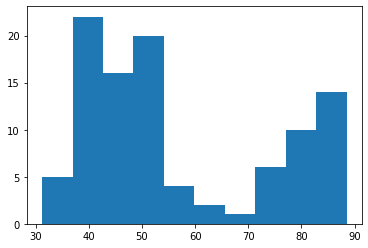

In [98]:
plt.hist(d_input[43]['complex']['forward'])

In [99]:
for i, work in enumerate(d_input[43]['complex']['reverse']):
    if work < -100:
        print(i, work)

1 -106.78518398089867
10 -385.4534349356916
12 -330.55549957802725
17 -396.3194375538678
21 -362.6592291216104
27 -447.66277668466415
30 -403.0620814946026
37 -375.5060119098595
48 -436.56637017140474
50 -402.1939504113147
59 -384.08541043769986
60 -386.65510243676727
67 -101.1968256022581
71 -416.41398657646107
74 -386.7269484155931
78 -424.5308221071641
84 -384.95171130496357
86 -309.1711777672864
87 -360.37101515699607
89 -426.2455038576522
91 -413.28538816761227


## Visualize reverse trajectory 10

In [100]:
with open("/data/chodera/zhangi/perses_benchmark/neq/13/43/43_complex_10_reverse_neq_new.npy", "rb") as f:
    pos_new = np.load(f)

In [102]:
pos_new.shape

(100, 29477, 3)

In [103]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/13/43"
traj_old = md.Trajectory(np.array(pos_new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_old.save(os.path.join(out_dir, f"43_complex_10_reverse_neq_new.dcd")) # index here indicates the index of the state
traj_old[0].save(os.path.join(out_dir, f"43_complex_10_reverse_neq_new.pdb"))


## Check LEU 41 in r-htf hybrid system

In [104]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/43"
traj_old = md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_old[0].save(os.path.join(out_dir, f"43_hybrid_system_new.pdb"))


## Visualize the whole rest cache new positions

In [10]:
with open("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_trp_1ns_snapshots_all_new.npy", "rb") as f:
    pos_new = np.load(f)

In [11]:
pos_new.shape

(1001, 29477, 3)

In [9]:
htf._topology_proposal.new_topology.getNumAtoms()

29477

In [13]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/43"
traj_old = md.Trajectory(np.array(pos_new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_old.save(os.path.join(out_dir, f"43_complex_trp_1ns_snapshots.dcd")) # index here indicates the index of the state
traj_old[0].save(os.path.join(out_dir, f"43_complex_trp_1ns_snapshots.pdb"))


## Visualize the 100 snapshot rest cache new positions

In [3]:
with open("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_trp_1ns_snapshots.npy", "rb") as f:
    pos_hybrid = np.load(f)

In [4]:
pos_new = np.zeros(shape=(pos_hybrid.shape[0],htf._topology_proposal.new_topology.getNumAtoms(), 3))
for i, pos in enumerate(pos_hybrid):
    pos_new[i] = htf.new_positions(pos*unit.nanometers)

In [5]:
pos_new.shape

(100, 29477, 3)

In [6]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/43"
traj_old = md.Trajectory(np.array(pos_new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_old.save(os.path.join(out_dir, f"43_complex_trp_1ns_snapshots.dcd")) # index here indicates the index of the state
traj_old[0].save(os.path.join(out_dir, f"43_complex_trp_1ns_snapshots.pdb"))


# Build REST system

In [8]:
# Build REST factory
# factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(669, 683)) + [652, 653, 683, 687] + list(range(14877, 14881)))

# factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(669, 683)) + list(range(14877, 14881)))
# factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(range(6, 20)) + [1549, 1550, 1551, 1552]) # THR + off ALA atoms


# query_indices = list(range(669, 683)) + list(range(14877, 14881))
for res in htf.hybrid_topology.residues:
    if res.resSeq == 38 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
rest_atoms = list(md.compute_neighbors(traj, 0.2, query_indices, haystack_indices=solute_atoms)[0])
# # # water_atoms = list(md.compute_neighbors(traj, 0.8, query_indices, haystack_indices=list(range(1441, htf.hybrid_topology.n_atoms)))[0])
factory = RESTTopologyFactory(htf.hybrid_system, solute_region=list(set(rest_atoms)))



INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.7997, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.7997, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.7997), unit=nanometer)]
INFO:REST:No unknown forces.


In [10]:
[atom.index for atom in list(htf.hybrid_topology.residues)[int('38')].atoms]

[604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 29473,
 29474,
 29475,
 29476,
 29477,
 29478,
 29479,
 29480,
 29481,
 29482,
 29483,
 29484,
 29485,
 29486,
 29487,
 29488,
 29489,
 29490]

In [9]:
query_indices

[604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 29473,
 29474,
 29475,
 29476,
 29477,
 29478,
 29479,
 29480,
 29481,
 29482,
 29483,
 29484,
 29485,
 29486,
 29487,
 29488,
 29489,
 29490]

In [5]:
# Determine indices for solute region
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE0-CH3
1 ACE0-C
2 ACE0-O
3 ACE0-H1
4 ACE0-H2
5 ACE0-H3
6 LYS1-N
7 LYS1-CA
8 LYS1-C
9 LYS1-O
10 LYS1-CB
11 LYS1-CG
12 LYS1-CD
13 LYS1-CE
14 LYS1-NZ
15 LYS1-H2
16 LYS1-HA
17 LYS1-HB3
18 LYS1-HB2
19 LYS1-HG2
20 LYS1-HG3
21 LYS1-HD2
22 LYS1-HD3
23 LYS1-HE3
24 LYS1-HE2
25 LYS1-HZ1
26 LYS1-HZ2
27 LYS1-HZ3
28 LYS2-N
29 LYS2-CA
30 LYS2-C
31 LYS2-O
32 LYS2-CB
33 LYS2-CG
34 LYS2-CD
35 LYS2-CE
36 LYS2-NZ
37 LYS2-H
38 LYS2-HA
39 LYS2-HB3
40 LYS2-HB2
41 LYS2-HG2
42 LYS2-HG3
43 LYS2-HD3
44 LYS2-HD2
45 LYS2-HE3
46 LYS2-HE2
47 LYS2-HZ1
48 LYS2-HZ2
49 LYS2-HZ3
50 ALA3-N
51 ALA3-CA
52 ALA3-C
53 ALA3-O
54 ALA3-CB
55 ALA3-H
56 ALA3-HA
57 ALA3-HB1
58 ALA3-HB2
59 ALA3-HB3
60 VAL4-N
61 VAL4-CA
62 VAL4-C
63 VAL4-O
64 VAL4-CB
65 VAL4-CG1
66 VAL4-CG2
67 VAL4-H
68 VAL4-HA
69 VAL4-HB
70 VAL4-HG11
71 VAL4-HG12
72 VAL4-HG13
73 VAL4-HG21
74 VAL4-HG22
75 VAL4-HG23
76 ILE5-N
77 ILE5-CA
78 ILE5-C
79 ILE5-O
80 ILE5-CB
81 ILE5-CG1
82 ILE5-CG2
83 ILE5-CD1
84 ILE5-H
85 ILE5-HA
86 ILE5-HB
87 ILE5-HG13
88 ILE5-HG12
89 IL

706 TRP44-HE3
707 TRP44-HZ2
708 TRP44-HZ3
709 TRP44-HH2
710 VAL45-N
711 VAL45-CA
712 VAL45-C
713 VAL45-O
714 VAL45-CB
715 VAL45-CG1
716 VAL45-CG2
717 VAL45-H
718 VAL45-HA
719 VAL45-HB
720 VAL45-HG11
721 VAL45-HG12
722 VAL45-HG13
723 VAL45-HG21
724 VAL45-HG22
725 VAL45-HG23
726 GLU46-N
727 GLU46-CA
728 GLU46-C
729 GLU46-O
730 GLU46-CB
731 GLU46-CG
732 GLU46-CD
733 GLU46-OE1
734 GLU46-OE2
735 GLU46-H
736 GLU46-HA
737 GLU46-HB3
738 GLU46-HB2
739 GLU46-HG3
740 GLU46-HG2
741 TYR47-N
742 TYR47-CA
743 TYR47-C
744 TYR47-O
745 TYR47-CB
746 TYR47-CG
747 TYR47-CD1
748 TYR47-CD2
749 TYR47-CE1
750 TYR47-CE2
751 TYR47-CZ
752 TYR47-OH
753 TYR47-H
754 TYR47-HA
755 TYR47-HB3
756 TYR47-HB2
757 TYR47-HD1
758 TYR47-HD2
759 TYR47-HE1
760 TYR47-HE2
761 TYR47-HH
762 PRO48-N
763 PRO48-CA
764 PRO48-C
765 PRO48-O
766 PRO48-CB
767 PRO48-CG
768 PRO48-CD
769 PRO48-HA
770 PRO48-HB3
771 PRO48-HB2
772 PRO48-HG3
773 PRO48-HG2
774 PRO48-HD2
775 PRO48-HD3
776 LEU49-N
777 LEU49-CA
778 LEU49-C
779 LEU49-O
780 LEU49-CB
781

1706 LYS19-HB2
1707 LYS19-HB3
1708 LYS19-HG3
1709 LYS19-HG2
1710 LYS19-HD3
1711 LYS19-HD2
1712 LYS19-HE3
1713 LYS19-HE2
1714 LYS19-HZ1
1715 LYS19-HZ2
1716 LYS19-HZ3
1717 LEU20-N
1718 LEU20-CA
1719 LEU20-C
1720 LEU20-O
1721 LEU20-CB
1722 LEU20-CG
1723 LEU20-CD1
1724 LEU20-CD2
1725 LEU20-H
1726 LEU20-HA
1727 LEU20-HB3
1728 LEU20-HB2
1729 LEU20-HG
1730 LEU20-HD11
1731 LEU20-HD12
1732 LEU20-HD13
1733 LEU20-HD21
1734 LEU20-HD22
1735 LEU20-HD23
1736 PRO21-N
1737 PRO21-CA
1738 PRO21-C
1739 PRO21-O
1740 PRO21-CB
1741 PRO21-CG
1742 PRO21-CD
1743 PRO21-HA
1744 PRO21-HB3
1745 PRO21-HB2
1746 PRO21-HG3
1747 PRO21-HG2
1748 PRO21-HD2
1749 PRO21-HD3
1750 ASP22-N
1751 ASP22-CA
1752 ASP22-C
1753 ASP22-O
1754 ASP22-CB
1755 ASP22-CG
1756 ASP22-OD1
1757 ASP22-OD2
1758 ASP22-H
1759 ASP22-HA
1760 ASP22-HB3
1761 ASP22-HB2
1762 ASN23-N
1763 ASN23-CA
1764 ASN23-C
1765 ASN23-O
1766 ASN23-CB
1767 ASN23-CG
1768 ASN23-OD1
1769 ASN23-ND2
1770 ASN23-H
1771 ASN23-HA
1772 ASN23-HB2
1773 ASN23-HB3
1774 ASN23-HD21
1775 A

2705 ASP86-CB
2706 ASP86-CG
2707 ASP86-OD1
2708 ASP86-OD2
2709 ASP86-H
2710 ASP86-HA
2711 ASP86-HB2
2712 ASP86-HB3
2713 ARG87-N
2714 ARG87-CA
2715 ARG87-C
2716 ARG87-O
2717 ARG87-CB
2718 ARG87-CG
2719 ARG87-CD
2720 ARG87-NE
2721 ARG87-CZ
2722 ARG87-NH1
2723 ARG87-NH2
2724 ARG87-H
2725 ARG87-HA
2726 ARG87-HB2
2727 ARG87-HB3
2728 ARG87-HG3
2729 ARG87-HG2
2730 ARG87-HD3
2731 ARG87-HD2
2732 ARG87-HE
2733 ARG87-HH11
2734 ARG87-HH12
2735 ARG87-HH21
2736 ARG87-HH22
2737 ILE88-N
2738 ILE88-CA
2739 ILE88-C
2740 ILE88-O
2741 ILE88-CB
2742 ILE88-CG1
2743 ILE88-CG2
2744 ILE88-CD1
2745 ILE88-H
2746 ILE88-HA
2747 ILE88-HB
2748 ILE88-HG13
2749 ILE88-HG12
2750 ILE88-HG21
2751 ILE88-HG22
2752 ILE88-HG23
2753 ILE88-HD11
2754 ILE88-HD12
2755 ILE88-HD13
2756 LEU89-N
2757 LEU89-CA
2758 LEU89-C
2759 LEU89-O
2760 LEU89-CB
2761 LEU89-CG
2762 LEU89-CD1
2763 LEU89-CD2
2764 LEU89-H
2765 LEU89-HA
2766 LEU89-HB2
2767 LEU89-HB3
2768 LEU89-HG
2769 LEU89-HD11
2770 LEU89-HD12
2771 LEU89-HD13
2772 LEU89-HD21
2773 LEU89

3705 HOH388-H1
3706 HOH388-H2
3707 HOH389-O
3708 HOH389-H1
3709 HOH389-H2
3710 HOH390-O
3711 HOH390-H1
3712 HOH390-H2
3713 HOH391-O
3714 HOH391-H1
3715 HOH391-H2
3716 HOH392-O
3717 HOH392-H1
3718 HOH392-H2
3719 HOH393-O
3720 HOH393-H1
3721 HOH393-H2
3722 HOH394-O
3723 HOH394-H1
3724 HOH394-H2
3725 HOH395-O
3726 HOH395-H1
3727 HOH395-H2
3728 HOH396-O
3729 HOH396-H1
3730 HOH396-H2
3731 HOH397-O
3732 HOH397-H1
3733 HOH397-H2
3734 HOH398-O
3735 HOH398-H1
3736 HOH398-H2
3737 HOH399-O
3738 HOH399-H1
3739 HOH399-H2
3740 HOH400-O
3741 HOH400-H1
3742 HOH400-H2
3743 HOH401-O
3744 HOH401-H1
3745 HOH401-H2
3746 HOH402-O
3747 HOH402-H1
3748 HOH402-H2
3749 HOH403-O
3750 HOH403-H1
3751 HOH403-H2
3752 HOH404-O
3753 HOH404-H1
3754 HOH404-H2
3755 HOH405-O
3756 HOH405-H1
3757 HOH405-H2
3758 HOH406-O
3759 HOH406-H1
3760 HOH406-H2
3761 HOH407-O
3762 HOH407-H1
3763 HOH407-H2
3764 HOH408-O
3765 HOH408-H1
3766 HOH408-H2
3767 HOH409-O
3768 HOH409-H1
3769 HOH409-H2
3770 HOH410-O
3771 HOH410-H1
3772 HOH410-H2
37

4704 HOH723-H1
4705 HOH723-H2
4706 HOH724-O
4707 HOH724-H1
4708 HOH724-H2
4709 HOH725-O
4710 HOH725-H1
4711 HOH725-H2
4712 HOH726-O
4713 HOH726-H1
4714 HOH726-H2
4715 HOH727-O
4716 HOH727-H1
4717 HOH727-H2
4718 HOH728-O
4719 HOH728-H1
4720 HOH728-H2
4721 HOH729-O
4722 HOH729-H1
4723 HOH729-H2
4724 HOH730-O
4725 HOH730-H1
4726 HOH730-H2
4727 HOH731-O
4728 HOH731-H1
4729 HOH731-H2
4730 HOH732-O
4731 HOH732-H1
4732 HOH732-H2
4733 HOH733-O
4734 HOH733-H1
4735 HOH733-H2
4736 HOH734-O
4737 HOH734-H1
4738 HOH734-H2
4739 HOH735-O
4740 HOH735-H1
4741 HOH735-H2
4742 HOH736-O
4743 HOH736-H1
4744 HOH736-H2
4745 HOH737-O
4746 HOH737-H1
4747 HOH737-H2
4748 HOH738-O
4749 HOH738-H1
4750 HOH738-H2
4751 HOH739-O
4752 HOH739-H1
4753 HOH739-H2
4754 HOH740-O
4755 HOH740-H1
4756 HOH740-H2
4757 HOH741-O
4758 HOH741-H1
4759 HOH741-H2
4760 HOH742-O
4761 HOH742-H1
4762 HOH742-H2
4763 HOH743-O
4764 HOH743-H1
4765 HOH743-H2
4766 HOH744-O
4767 HOH744-H1
4768 HOH744-H2
4769 HOH745-O
4770 HOH745-H1
4771 HOH745-H2
47

5704 HOH1057-H2
5705 HOH1058-O
5706 HOH1058-H1
5707 HOH1058-H2
5708 HOH1059-O
5709 HOH1059-H1
5710 HOH1059-H2
5711 HOH1060-O
5712 HOH1060-H1
5713 HOH1060-H2
5714 HOH1061-O
5715 HOH1061-H1
5716 HOH1061-H2
5717 HOH1062-O
5718 HOH1062-H1
5719 HOH1062-H2
5720 HOH1063-O
5721 HOH1063-H1
5722 HOH1063-H2
5723 HOH1064-O
5724 HOH1064-H1
5725 HOH1064-H2
5726 HOH1065-O
5727 HOH1065-H1
5728 HOH1065-H2
5729 HOH1066-O
5730 HOH1066-H1
5731 HOH1066-H2
5732 HOH1067-O
5733 HOH1067-H1
5734 HOH1067-H2
5735 HOH1068-O
5736 HOH1068-H1
5737 HOH1068-H2
5738 HOH1069-O
5739 HOH1069-H1
5740 HOH1069-H2
5741 HOH1070-O
5742 HOH1070-H1
5743 HOH1070-H2
5744 HOH1071-O
5745 HOH1071-H1
5746 HOH1071-H2
5747 HOH1072-O
5748 HOH1072-H1
5749 HOH1072-H2
5750 HOH1073-O
5751 HOH1073-H1
5752 HOH1073-H2
5753 HOH1074-O
5754 HOH1074-H1
5755 HOH1074-H2
5756 HOH1075-O
5757 HOH1075-H1
5758 HOH1075-H2
5759 HOH1076-O
5760 HOH1076-H1
5761 HOH1076-H2
5762 HOH1077-O
5763 HOH1077-H1
5764 HOH1077-H2
5765 HOH1078-O
5766 HOH1078-H1
5767 HOH1078-

6703 HOH1391-H2
6704 HOH1392-O
6705 HOH1392-H1
6706 HOH1392-H2
6707 HOH1393-O
6708 HOH1393-H1
6709 HOH1393-H2
6710 HOH1394-O
6711 HOH1394-H1
6712 HOH1394-H2
6713 HOH1395-O
6714 HOH1395-H1
6715 HOH1395-H2
6716 HOH1396-O
6717 HOH1396-H1
6718 HOH1396-H2
6719 HOH1397-O
6720 HOH1397-H1
6721 HOH1397-H2
6722 HOH1398-O
6723 HOH1398-H1
6724 HOH1398-H2
6725 HOH1399-O
6726 HOH1399-H1
6727 HOH1399-H2
6728 HOH1400-O
6729 HOH1400-H1
6730 HOH1400-H2
6731 HOH1401-O
6732 HOH1401-H1
6733 HOH1401-H2
6734 HOH1402-O
6735 HOH1402-H1
6736 HOH1402-H2
6737 HOH1403-O
6738 HOH1403-H1
6739 HOH1403-H2
6740 HOH1404-O
6741 HOH1404-H1
6742 HOH1404-H2
6743 HOH1405-O
6744 HOH1405-H1
6745 HOH1405-H2
6746 HOH1406-O
6747 HOH1406-H1
6748 HOH1406-H2
6749 HOH1407-O
6750 HOH1407-H1
6751 HOH1407-H2
6752 HOH1408-O
6753 HOH1408-H1
6754 HOH1408-H2
6755 HOH1409-O
6756 HOH1409-H1
6757 HOH1409-H2
6758 HOH1410-O
6759 HOH1410-H1
6760 HOH1410-H2
6761 HOH1411-O
6762 HOH1411-H1
6763 HOH1411-H2
6764 HOH1412-O
6765 HOH1412-H1
6766 HOH1412-

7703 HOH1725-O
7704 HOH1725-H1
7705 HOH1725-H2
7706 HOH1726-O
7707 HOH1726-H1
7708 HOH1726-H2
7709 HOH1727-O
7710 HOH1727-H1
7711 HOH1727-H2
7712 HOH1728-O
7713 HOH1728-H1
7714 HOH1728-H2
7715 HOH1729-O
7716 HOH1729-H1
7717 HOH1729-H2
7718 HOH1730-O
7719 HOH1730-H1
7720 HOH1730-H2
7721 HOH1731-O
7722 HOH1731-H1
7723 HOH1731-H2
7724 HOH1732-O
7725 HOH1732-H1
7726 HOH1732-H2
7727 HOH1733-O
7728 HOH1733-H1
7729 HOH1733-H2
7730 HOH1734-O
7731 HOH1734-H1
7732 HOH1734-H2
7733 HOH1735-O
7734 HOH1735-H1
7735 HOH1735-H2
7736 HOH1736-O
7737 HOH1736-H1
7738 HOH1736-H2
7739 HOH1737-O
7740 HOH1737-H1
7741 HOH1737-H2
7742 HOH1738-O
7743 HOH1738-H1
7744 HOH1738-H2
7745 HOH1739-O
7746 HOH1739-H1
7747 HOH1739-H2
7748 HOH1740-O
7749 HOH1740-H1
7750 HOH1740-H2
7751 HOH1741-O
7752 HOH1741-H1
7753 HOH1741-H2
7754 HOH1742-O
7755 HOH1742-H1
7756 HOH1742-H2
7757 HOH1743-O
7758 HOH1743-H1
7759 HOH1743-H2
7760 HOH1744-O
7761 HOH1744-H1
7762 HOH1744-H2
7763 HOH1745-O
7764 HOH1745-H1
7765 HOH1745-H2
7766 HOH1746-

8702 HOH2059-O
8703 HOH2059-H1
8704 HOH2059-H2
8705 HOH2060-O
8706 HOH2060-H1
8707 HOH2060-H2
8708 HOH2061-O
8709 HOH2061-H1
8710 HOH2061-H2
8711 HOH2062-O
8712 HOH2062-H1
8713 HOH2062-H2
8714 HOH2063-O
8715 HOH2063-H1
8716 HOH2063-H2
8717 HOH2064-O
8718 HOH2064-H1
8719 HOH2064-H2
8720 HOH2065-O
8721 HOH2065-H1
8722 HOH2065-H2
8723 HOH2066-O
8724 HOH2066-H1
8725 HOH2066-H2
8726 HOH2067-O
8727 HOH2067-H1
8728 HOH2067-H2
8729 HOH2068-O
8730 HOH2068-H1
8731 HOH2068-H2
8732 HOH2069-O
8733 HOH2069-H1
8734 HOH2069-H2
8735 HOH2070-O
8736 HOH2070-H1
8737 HOH2070-H2
8738 HOH2071-O
8739 HOH2071-H1
8740 HOH2071-H2
8741 HOH2072-O
8742 HOH2072-H1
8743 HOH2072-H2
8744 HOH2073-O
8745 HOH2073-H1
8746 HOH2073-H2
8747 HOH2074-O
8748 HOH2074-H1
8749 HOH2074-H2
8750 HOH2075-O
8751 HOH2075-H1
8752 HOH2075-H2
8753 HOH2076-O
8754 HOH2076-H1
8755 HOH2076-H2
8756 HOH2077-O
8757 HOH2077-H1
8758 HOH2077-H2
8759 HOH2078-O
8760 HOH2078-H1
8761 HOH2078-H2
8762 HOH2079-O
8763 HOH2079-H1
8764 HOH2079-H2
8765 HOH2080-

9702 HOH2392-H1
9703 HOH2392-H2
9704 HOH2393-O
9705 HOH2393-H1
9706 HOH2393-H2
9707 HOH2394-O
9708 HOH2394-H1
9709 HOH2394-H2
9710 HOH2395-O
9711 HOH2395-H1
9712 HOH2395-H2
9713 HOH2396-O
9714 HOH2396-H1
9715 HOH2396-H2
9716 HOH2397-O
9717 HOH2397-H1
9718 HOH2397-H2
9719 HOH2398-O
9720 HOH2398-H1
9721 HOH2398-H2
9722 HOH2399-O
9723 HOH2399-H1
9724 HOH2399-H2
9725 HOH2400-O
9726 HOH2400-H1
9727 HOH2400-H2
9728 HOH2401-O
9729 HOH2401-H1
9730 HOH2401-H2
9731 HOH2402-O
9732 HOH2402-H1
9733 HOH2402-H2
9734 HOH2403-O
9735 HOH2403-H1
9736 HOH2403-H2
9737 HOH2404-O
9738 HOH2404-H1
9739 HOH2404-H2
9740 HOH2405-O
9741 HOH2405-H1
9742 HOH2405-H2
9743 HOH2406-O
9744 HOH2406-H1
9745 HOH2406-H2
9746 HOH2407-O
9747 HOH2407-H1
9748 HOH2407-H2
9749 HOH2408-O
9750 HOH2408-H1
9751 HOH2408-H2
9752 HOH2409-O
9753 HOH2409-H1
9754 HOH2409-H2
9755 HOH2410-O
9756 HOH2410-H1
9757 HOH2410-H2
9758 HOH2411-O
9759 HOH2411-H1
9760 HOH2411-H2
9761 HOH2412-O
9762 HOH2412-H1
9763 HOH2412-H2
9764 HOH2413-O
9765 HOH2413-

10701 HOH2726-H1
10702 HOH2726-H2
10703 HOH2727-O
10704 HOH2727-H1
10705 HOH2727-H2
10706 HOH2728-O
10707 HOH2728-H1
10708 HOH2728-H2
10709 HOH2729-O
10710 HOH2729-H1
10711 HOH2729-H2
10712 HOH2730-O
10713 HOH2730-H1
10714 HOH2730-H2
10715 HOH2731-O
10716 HOH2731-H1
10717 HOH2731-H2
10718 HOH2732-O
10719 HOH2732-H1
10720 HOH2732-H2
10721 HOH2733-O
10722 HOH2733-H1
10723 HOH2733-H2
10724 HOH2734-O
10725 HOH2734-H1
10726 HOH2734-H2
10727 HOH2735-O
10728 HOH2735-H1
10729 HOH2735-H2
10730 HOH2736-O
10731 HOH2736-H1
10732 HOH2736-H2
10733 HOH2737-O
10734 HOH2737-H1
10735 HOH2737-H2
10736 HOH2738-O
10737 HOH2738-H1
10738 HOH2738-H2
10739 HOH2739-O
10740 HOH2739-H1
10741 HOH2739-H2
10742 HOH2740-O
10743 HOH2740-H1
10744 HOH2740-H2
10745 HOH2741-O
10746 HOH2741-H1
10747 HOH2741-H2
10748 HOH2742-O
10749 HOH2742-H1
10750 HOH2742-H2
10751 HOH2743-O
10752 HOH2743-H1
10753 HOH2743-H2
10754 HOH2744-O
10755 HOH2744-H1
10756 HOH2744-H2
10757 HOH2745-O
10758 HOH2745-H1
10759 HOH2745-H2
10760 HOH2746-O


11201 HOH2894-O
11202 HOH2894-H1
11203 HOH2894-H2
11204 HOH2895-O
11205 HOH2895-H1
11206 HOH2895-H2
11207 HOH2896-O
11208 HOH2896-H1
11209 HOH2896-H2
11210 HOH2897-O
11211 HOH2897-H1
11212 HOH2897-H2
11213 HOH2898-O
11214 HOH2898-H1
11215 HOH2898-H2
11216 HOH2899-O
11217 HOH2899-H1
11218 HOH2899-H2
11219 HOH2900-O
11220 HOH2900-H1
11221 HOH2900-H2
11222 HOH2901-O
11223 HOH2901-H1
11224 HOH2901-H2
11225 HOH2902-O
11226 HOH2902-H1
11227 HOH2902-H2
11228 HOH2903-O
11229 HOH2903-H1
11230 HOH2903-H2
11231 HOH2904-O
11232 HOH2904-H1
11233 HOH2904-H2
11234 HOH2905-O
11235 HOH2905-H1
11236 HOH2905-H2
11237 HOH2906-O
11238 HOH2906-H1
11239 HOH2906-H2
11240 HOH2907-O
11241 HOH2907-H1
11242 HOH2907-H2
11243 HOH2908-O
11244 HOH2908-H1
11245 HOH2908-H2
11246 HOH2909-O
11247 HOH2909-H1
11248 HOH2909-H2
11249 HOH2910-O
11250 HOH2910-H1
11251 HOH2910-H2
11252 HOH2911-O
11253 HOH2911-H1
11254 HOH2911-H2
11255 HOH2912-O
11256 HOH2912-H1
11257 HOH2912-H2
11258 HOH2913-O
11259 HOH2913-H1
11260 HOH2913-H2


11701 HOH3061-H2
11702 HOH3062-O
11703 HOH3062-H1
11704 HOH3062-H2
11705 HOH3063-O
11706 HOH3063-H1
11707 HOH3063-H2
11708 HOH3064-O
11709 HOH3064-H1
11710 HOH3064-H2
11711 HOH3065-O
11712 HOH3065-H1
11713 HOH3065-H2
11714 HOH3066-O
11715 HOH3066-H1
11716 HOH3066-H2
11717 HOH3067-O
11718 HOH3067-H1
11719 HOH3067-H2
11720 HOH3068-O
11721 HOH3068-H1
11722 HOH3068-H2
11723 HOH3069-O
11724 HOH3069-H1
11725 HOH3069-H2
11726 HOH3070-O
11727 HOH3070-H1
11728 HOH3070-H2
11729 HOH3071-O
11730 HOH3071-H1
11731 HOH3071-H2
11732 HOH3072-O
11733 HOH3072-H1
11734 HOH3072-H2
11735 HOH3073-O
11736 HOH3073-H1
11737 HOH3073-H2
11738 HOH3074-O
11739 HOH3074-H1
11740 HOH3074-H2
11741 HOH3075-O
11742 HOH3075-H1
11743 HOH3075-H2
11744 HOH3076-O
11745 HOH3076-H1
11746 HOH3076-H2
11747 HOH3077-O
11748 HOH3077-H1
11749 HOH3077-H2
11750 HOH3078-O
11751 HOH3078-H1
11752 HOH3078-H2
11753 HOH3079-O
11754 HOH3079-H1
11755 HOH3079-H2
11756 HOH3080-O
11757 HOH3080-H1
11758 HOH3080-H2
11759 HOH3081-O
11760 HOH3081-H1


12201 HOH3230-H1
12202 HOH3230-H2
12203 HOH3231-O
12204 HOH3231-H1
12205 HOH3231-H2
12206 HOH3232-O
12207 HOH3232-H1
12208 HOH3232-H2
12209 HOH3233-O
12210 HOH3233-H1
12211 HOH3233-H2
12212 HOH3234-O
12213 HOH3234-H1
12214 HOH3234-H2
12215 HOH3235-O
12216 HOH3235-H1
12217 HOH3235-H2
12218 HOH3236-O
12219 HOH3236-H1
12220 HOH3236-H2
12221 HOH3237-O
12222 HOH3237-H1
12223 HOH3237-H2
12224 HOH3238-O
12225 HOH3238-H1
12226 HOH3238-H2
12227 HOH3239-O
12228 HOH3239-H1
12229 HOH3239-H2
12230 HOH3240-O
12231 HOH3240-H1
12232 HOH3240-H2
12233 HOH3241-O
12234 HOH3241-H1
12235 HOH3241-H2
12236 HOH3242-O
12237 HOH3242-H1
12238 HOH3242-H2
12239 HOH3243-O
12240 HOH3243-H1
12241 HOH3243-H2
12242 HOH3244-O
12243 HOH3244-H1
12244 HOH3244-H2
12245 HOH3245-O
12246 HOH3245-H1
12247 HOH3245-H2
12248 HOH3246-O
12249 HOH3246-H1
12250 HOH3246-H2
12251 HOH3247-O
12252 HOH3247-H1
12253 HOH3247-H2
12254 HOH3248-O
12255 HOH3248-H1
12256 HOH3248-H2
12257 HOH3249-O
12258 HOH3249-H1
12259 HOH3249-H2
12260 HOH3250-O


12700 HOH3397-H2
12701 HOH3398-O
12702 HOH3398-H1
12703 HOH3398-H2
12704 HOH3399-O
12705 HOH3399-H1
12706 HOH3399-H2
12707 HOH3400-O
12708 HOH3400-H1
12709 HOH3400-H2
12710 HOH3401-O
12711 HOH3401-H1
12712 HOH3401-H2
12713 HOH3402-O
12714 HOH3402-H1
12715 HOH3402-H2
12716 HOH3403-O
12717 HOH3403-H1
12718 HOH3403-H2
12719 HOH3404-O
12720 HOH3404-H1
12721 HOH3404-H2
12722 HOH3405-O
12723 HOH3405-H1
12724 HOH3405-H2
12725 HOH3406-O
12726 HOH3406-H1
12727 HOH3406-H2
12728 HOH3407-O
12729 HOH3407-H1
12730 HOH3407-H2
12731 HOH3408-O
12732 HOH3408-H1
12733 HOH3408-H2
12734 HOH3409-O
12735 HOH3409-H1
12736 HOH3409-H2
12737 HOH3410-O
12738 HOH3410-H1
12739 HOH3410-H2
12740 HOH3411-O
12741 HOH3411-H1
12742 HOH3411-H2
12743 HOH3412-O
12744 HOH3412-H1
12745 HOH3412-H2
12746 HOH3413-O
12747 HOH3413-H1
12748 HOH3413-H2
12749 HOH3414-O
12750 HOH3414-H1
12751 HOH3414-H2
12752 HOH3415-O
12753 HOH3415-H1
12754 HOH3415-H2
12755 HOH3416-O
12756 HOH3416-H1
12757 HOH3416-H2
12758 HOH3417-O
12759 HOH3417-H1


13200 HOH3565-H1
13201 HOH3565-H2
13202 HOH3566-O
13203 HOH3566-H1
13204 HOH3566-H2
13205 HOH3567-O
13206 HOH3567-H1
13207 HOH3567-H2
13208 HOH3568-O
13209 HOH3568-H1
13210 HOH3568-H2
13211 HOH3569-O
13212 HOH3569-H1
13213 HOH3569-H2
13214 HOH3570-O
13215 HOH3570-H1
13216 HOH3570-H2
13217 HOH3571-O
13218 HOH3571-H1
13219 HOH3571-H2
13220 HOH3572-O
13221 HOH3572-H1
13222 HOH3572-H2
13223 HOH3573-O
13224 HOH3573-H1
13225 HOH3573-H2
13226 HOH3574-O
13227 HOH3574-H1
13228 HOH3574-H2
13229 HOH3575-O
13230 HOH3575-H1
13231 HOH3575-H2
13232 HOH3576-O
13233 HOH3576-H1
13234 HOH3576-H2
13235 HOH3577-O
13236 HOH3577-H1
13237 HOH3577-H2
13238 HOH3578-O
13239 HOH3578-H1
13240 HOH3578-H2
13241 HOH3579-O
13242 HOH3579-H1
13243 HOH3579-H2
13244 HOH3580-O
13245 HOH3580-H1
13246 HOH3580-H2
13247 HOH3581-O
13248 HOH3581-H1
13249 HOH3581-H2
13250 HOH3582-O
13251 HOH3582-H1
13252 HOH3582-H2
13253 HOH3583-O
13254 HOH3583-H1
13255 HOH3583-H2
13256 HOH3584-O
13257 HOH3584-H1
13258 HOH3584-H2
13259 HOH3585-O


13700 HOH3732-O
13701 HOH3732-H1
13702 HOH3732-H2
13703 HOH3733-O
13704 HOH3733-H1
13705 HOH3733-H2
13706 HOH3734-O
13707 HOH3734-H1
13708 HOH3734-H2
13709 HOH3735-O
13710 HOH3735-H1
13711 HOH3735-H2
13712 HOH3736-O
13713 HOH3736-H1
13714 HOH3736-H2
13715 HOH3737-O
13716 HOH3737-H1
13717 HOH3737-H2
13718 HOH3738-O
13719 HOH3738-H1
13720 HOH3738-H2
13721 HOH3739-O
13722 HOH3739-H1
13723 HOH3739-H2
13724 HOH3740-O
13725 HOH3740-H1
13726 HOH3740-H2
13727 HOH3741-O
13728 HOH3741-H1
13729 HOH3741-H2
13730 HOH3742-O
13731 HOH3742-H1
13732 HOH3742-H2
13733 HOH3743-O
13734 HOH3743-H1
13735 HOH3743-H2
13736 HOH3744-O
13737 HOH3744-H1
13738 HOH3744-H2
13739 HOH3745-O
13740 HOH3745-H1
13741 HOH3745-H2
13742 HOH3746-O
13743 HOH3746-H1
13744 HOH3746-H2
13745 HOH3747-O
13746 HOH3747-H1
13747 HOH3747-H2
13748 HOH3748-O
13749 HOH3748-H1
13750 HOH3748-H2
13751 HOH3749-O
13752 HOH3749-H1
13753 HOH3749-H2
13754 HOH3750-O
13755 HOH3750-H1
13756 HOH3750-H2
13757 HOH3751-O
13758 HOH3751-H1
13759 HOH3751-H2


14200 HOH3898-H2
14201 HOH3899-O
14202 HOH3899-H1
14203 HOH3899-H2
14204 HOH3900-O
14205 HOH3900-H1
14206 HOH3900-H2
14207 HOH3901-O
14208 HOH3901-H1
14209 HOH3901-H2
14210 HOH3902-O
14211 HOH3902-H1
14212 HOH3902-H2
14213 HOH3903-O
14214 HOH3903-H1
14215 HOH3903-H2
14216 HOH3904-O
14217 HOH3904-H1
14218 HOH3904-H2
14219 HOH3905-O
14220 HOH3905-H1
14221 HOH3905-H2
14222 HOH3906-O
14223 HOH3906-H1
14224 HOH3906-H2
14225 HOH3907-O
14226 HOH3907-H1
14227 HOH3907-H2
14228 HOH3908-O
14229 HOH3908-H1
14230 HOH3908-H2
14231 HOH3909-O
14232 HOH3909-H1
14233 HOH3909-H2
14234 HOH3910-O
14235 HOH3910-H1
14236 HOH3910-H2
14237 HOH3911-O
14238 HOH3911-H1
14239 HOH3911-H2
14240 HOH3912-O
14241 HOH3912-H1
14242 HOH3912-H2
14243 HOH3913-O
14244 HOH3913-H1
14245 HOH3913-H2
14246 HOH3914-O
14247 HOH3914-H1
14248 HOH3914-H2
14249 HOH3915-O
14250 HOH3915-H1
14251 HOH3915-H2
14252 HOH3916-O
14253 HOH3916-H1
14254 HOH3916-H2
14255 HOH3917-O
14256 HOH3917-H1
14257 HOH3917-H2
14258 HOH3918-O
14259 HOH3918-H1


14699 HOH4065-O
14700 HOH4065-H1
14701 HOH4065-H2
14702 HOH4066-O
14703 HOH4066-H1
14704 HOH4066-H2
14705 HOH4067-O
14706 HOH4067-H1
14707 HOH4067-H2
14708 HOH4068-O
14709 HOH4068-H1
14710 HOH4068-H2
14711 HOH4069-O
14712 HOH4069-H1
14713 HOH4069-H2
14714 HOH4070-O
14715 HOH4070-H1
14716 HOH4070-H2
14717 HOH4071-O
14718 HOH4071-H1
14719 HOH4071-H2
14720 HOH4072-O
14721 HOH4072-H1
14722 HOH4072-H2
14723 HOH4073-O
14724 HOH4073-H1
14725 HOH4073-H2
14726 HOH4074-O
14727 HOH4074-H1
14728 HOH4074-H2
14729 HOH4075-O
14730 HOH4075-H1
14731 HOH4075-H2
14732 HOH4076-O
14733 HOH4076-H1
14734 HOH4076-H2
14735 HOH4077-O
14736 HOH4077-H1
14737 HOH4077-H2
14738 HOH4078-O
14739 HOH4078-H1
14740 HOH4078-H2
14741 HOH4079-O
14742 HOH4079-H1
14743 HOH4079-H2
14744 HOH4080-O
14745 HOH4080-H1
14746 HOH4080-H2
14747 HOH4081-O
14748 HOH4081-H1
14749 HOH4081-H2
14750 HOH4082-O
14751 HOH4082-H1
14752 HOH4082-H2
14753 HOH4083-O
14754 HOH4083-H1
14755 HOH4083-H2
14756 HOH4084-O
14757 HOH4084-H1
14758 HOH4084-H2


15199 HOH4231-H2
15200 HOH4232-O
15201 HOH4232-H1
15202 HOH4232-H2
15203 HOH4233-O
15204 HOH4233-H1
15205 HOH4233-H2
15206 HOH4234-O
15207 HOH4234-H1
15208 HOH4234-H2
15209 HOH4235-O
15210 HOH4235-H1
15211 HOH4235-H2
15212 HOH4236-O
15213 HOH4236-H1
15214 HOH4236-H2
15215 HOH4237-O
15216 HOH4237-H1
15217 HOH4237-H2
15218 HOH4238-O
15219 HOH4238-H1
15220 HOH4238-H2
15221 HOH4239-O
15222 HOH4239-H1
15223 HOH4239-H2
15224 HOH4240-O
15225 HOH4240-H1
15226 HOH4240-H2
15227 HOH4241-O
15228 HOH4241-H1
15229 HOH4241-H2
15230 HOH4242-O
15231 HOH4242-H1
15232 HOH4242-H2
15233 HOH4243-O
15234 HOH4243-H1
15235 HOH4243-H2
15236 HOH4244-O
15237 HOH4244-H1
15238 HOH4244-H2
15239 HOH4245-O
15240 HOH4245-H1
15241 HOH4245-H2
15242 HOH4246-O
15243 HOH4246-H1
15244 HOH4246-H2
15245 HOH4247-O
15246 HOH4247-H1
15247 HOH4247-H2
15248 HOH4248-O
15249 HOH4248-H1
15250 HOH4248-H2
15251 HOH4249-O
15252 HOH4249-H1
15253 HOH4249-H2
15254 HOH4250-O
15255 HOH4250-H1
15256 HOH4250-H2
15257 HOH4251-O
15258 HOH4251-H1


15699 HOH4398-H1
15700 HOH4398-H2
15701 HOH4399-O
15702 HOH4399-H1
15703 HOH4399-H2
15704 HOH4400-O
15705 HOH4400-H1
15706 HOH4400-H2
15707 HOH4401-O
15708 HOH4401-H1
15709 HOH4401-H2
15710 HOH4402-O
15711 HOH4402-H1
15712 HOH4402-H2
15713 HOH4403-O
15714 HOH4403-H1
15715 HOH4403-H2
15716 HOH4404-O
15717 HOH4404-H1
15718 HOH4404-H2
15719 HOH4405-O
15720 HOH4405-H1
15721 HOH4405-H2
15722 HOH4406-O
15723 HOH4406-H1
15724 HOH4406-H2
15725 HOH4407-O
15726 HOH4407-H1
15727 HOH4407-H2
15728 HOH4408-O
15729 HOH4408-H1
15730 HOH4408-H2
15731 HOH4409-O
15732 HOH4409-H1
15733 HOH4409-H2
15734 HOH4410-O
15735 HOH4410-H1
15736 HOH4410-H2
15737 HOH4411-O
15738 HOH4411-H1
15739 HOH4411-H2
15740 HOH4412-O
15741 HOH4412-H1
15742 HOH4412-H2
15743 HOH4413-O
15744 HOH4413-H1
15745 HOH4413-H2
15746 HOH4414-O
15747 HOH4414-H1
15748 HOH4414-H2
15749 HOH4415-O
15750 HOH4415-H1
15751 HOH4415-H2
15752 HOH4416-O
15753 HOH4416-H1
15754 HOH4416-H2
15755 HOH4417-O
15756 HOH4417-H1
15757 HOH4417-H2
15758 HOH4418-O


16199 HOH4565-O
16200 HOH4565-H1
16201 HOH4565-H2
16202 HOH4566-O
16203 HOH4566-H1
16204 HOH4566-H2
16205 HOH4567-O
16206 HOH4567-H1
16207 HOH4567-H2
16208 HOH4568-O
16209 HOH4568-H1
16210 HOH4568-H2
16211 HOH4569-O
16212 HOH4569-H1
16213 HOH4569-H2
16214 HOH4570-O
16215 HOH4570-H1
16216 HOH4570-H2
16217 HOH4571-O
16218 HOH4571-H1
16219 HOH4571-H2
16220 HOH4572-O
16221 HOH4572-H1
16222 HOH4572-H2
16223 HOH4573-O
16224 HOH4573-H1
16225 HOH4573-H2
16226 HOH4574-O
16227 HOH4574-H1
16228 HOH4574-H2
16229 HOH4575-O
16230 HOH4575-H1
16231 HOH4575-H2
16232 HOH4576-O
16233 HOH4576-H1
16234 HOH4576-H2
16235 HOH4577-O
16236 HOH4577-H1
16237 HOH4577-H2
16238 HOH4578-O
16239 HOH4578-H1
16240 HOH4578-H2
16241 HOH4579-O
16242 HOH4579-H1
16243 HOH4579-H2
16244 HOH4580-O
16245 HOH4580-H1
16246 HOH4580-H2
16247 HOH4581-O
16248 HOH4581-H1
16249 HOH4581-H2
16250 HOH4582-O
16251 HOH4582-H1
16252 HOH4582-H2
16253 HOH4583-O
16254 HOH4583-H1
16255 HOH4583-H2
16256 HOH4584-O
16257 HOH4584-H1
16258 HOH4584-H2


16698 HOH4732-H1
16699 HOH4732-H2
16700 HOH4733-O
16701 HOH4733-H1
16702 HOH4733-H2
16703 HOH4734-O
16704 HOH4734-H1
16705 HOH4734-H2
16706 HOH4735-O
16707 HOH4735-H1
16708 HOH4735-H2
16709 HOH4736-O
16710 HOH4736-H1
16711 HOH4736-H2
16712 HOH4737-O
16713 HOH4737-H1
16714 HOH4737-H2
16715 HOH4738-O
16716 HOH4738-H1
16717 HOH4738-H2
16718 HOH4739-O
16719 HOH4739-H1
16720 HOH4739-H2
16721 HOH4740-O
16722 HOH4740-H1
16723 HOH4740-H2
16724 HOH4741-O
16725 HOH4741-H1
16726 HOH4741-H2
16727 HOH4742-O
16728 HOH4742-H1
16729 HOH4742-H2
16730 HOH4743-O
16731 HOH4743-H1
16732 HOH4743-H2
16733 HOH4744-O
16734 HOH4744-H1
16735 HOH4744-H2
16736 HOH4745-O
16737 HOH4745-H1
16738 HOH4745-H2
16739 HOH4746-O
16740 HOH4746-H1
16741 HOH4746-H2
16742 HOH4747-O
16743 HOH4747-H1
16744 HOH4747-H2
16745 HOH4748-O
16746 HOH4748-H1
16747 HOH4748-H2
16748 HOH4749-O
16749 HOH4749-H1
16750 HOH4749-H2
16751 HOH4750-O
16752 HOH4750-H1
16753 HOH4750-H2
16754 HOH4751-O
16755 HOH4751-H1
16756 HOH4751-H2
16757 HOH4752-O


17198 HOH4899-O
17199 HOH4899-H1
17200 HOH4899-H2
17201 HOH4900-O
17202 HOH4900-H1
17203 HOH4900-H2
17204 HOH4901-O
17205 HOH4901-H1
17206 HOH4901-H2
17207 HOH4902-O
17208 HOH4902-H1
17209 HOH4902-H2
17210 HOH4903-O
17211 HOH4903-H1
17212 HOH4903-H2
17213 HOH4904-O
17214 HOH4904-H1
17215 HOH4904-H2
17216 HOH4905-O
17217 HOH4905-H1
17218 HOH4905-H2
17219 HOH4906-O
17220 HOH4906-H1
17221 HOH4906-H2
17222 HOH4907-O
17223 HOH4907-H1
17224 HOH4907-H2
17225 HOH4908-O
17226 HOH4908-H1
17227 HOH4908-H2
17228 HOH4909-O
17229 HOH4909-H1
17230 HOH4909-H2
17231 HOH4910-O
17232 HOH4910-H1
17233 HOH4910-H2
17234 HOH4911-O
17235 HOH4911-H1
17236 HOH4911-H2
17237 HOH4912-O
17238 HOH4912-H1
17239 HOH4912-H2
17240 HOH4913-O
17241 HOH4913-H1
17242 HOH4913-H2
17243 HOH4914-O
17244 HOH4914-H1
17245 HOH4914-H2
17246 HOH4915-O
17247 HOH4915-H1
17248 HOH4915-H2
17249 HOH4916-O
17250 HOH4916-H1
17251 HOH4916-H2
17252 HOH4917-O
17253 HOH4917-H1
17254 HOH4917-H2
17255 HOH4918-O
17256 HOH4918-H1
17257 HOH4918-H2


17698 HOH5065-H2
17699 HOH5066-O
17700 HOH5066-H1
17701 HOH5066-H2
17702 HOH5067-O
17703 HOH5067-H1
17704 HOH5067-H2
17705 HOH5068-O
17706 HOH5068-H1
17707 HOH5068-H2
17708 HOH5069-O
17709 HOH5069-H1
17710 HOH5069-H2
17711 HOH5070-O
17712 HOH5070-H1
17713 HOH5070-H2
17714 HOH5071-O
17715 HOH5071-H1
17716 HOH5071-H2
17717 HOH5072-O
17718 HOH5072-H1
17719 HOH5072-H2
17720 HOH5073-O
17721 HOH5073-H1
17722 HOH5073-H2
17723 HOH5074-O
17724 HOH5074-H1
17725 HOH5074-H2
17726 HOH5075-O
17727 HOH5075-H1
17728 HOH5075-H2
17729 HOH5076-O
17730 HOH5076-H1
17731 HOH5076-H2
17732 HOH5077-O
17733 HOH5077-H1
17734 HOH5077-H2
17735 HOH5078-O
17736 HOH5078-H1
17737 HOH5078-H2
17738 HOH5079-O
17739 HOH5079-H1
17740 HOH5079-H2
17741 HOH5080-O
17742 HOH5080-H1
17743 HOH5080-H2
17744 HOH5081-O
17745 HOH5081-H1
17746 HOH5081-H2
17747 HOH5082-O
17748 HOH5082-H1
17749 HOH5082-H2
17750 HOH5083-O
17751 HOH5083-H1
17752 HOH5083-H2
17753 HOH5084-O
17754 HOH5084-H1
17755 HOH5084-H2
17756 HOH5085-O
17757 HOH5085-H1


18198 HOH5232-H1
18199 HOH5232-H2
18200 HOH5233-O
18201 HOH5233-H1
18202 HOH5233-H2
18203 HOH5234-O
18204 HOH5234-H1
18205 HOH5234-H2
18206 HOH5235-O
18207 HOH5235-H1
18208 HOH5235-H2
18209 HOH5236-O
18210 HOH5236-H1
18211 HOH5236-H2
18212 HOH5237-O
18213 HOH5237-H1
18214 HOH5237-H2
18215 HOH5238-O
18216 HOH5238-H1
18217 HOH5238-H2
18218 HOH5239-O
18219 HOH5239-H1
18220 HOH5239-H2
18221 HOH5240-O
18222 HOH5240-H1
18223 HOH5240-H2
18224 HOH5241-O
18225 HOH5241-H1
18226 HOH5241-H2
18227 HOH5242-O
18228 HOH5242-H1
18229 HOH5242-H2
18230 HOH5243-O
18231 HOH5243-H1
18232 HOH5243-H2
18233 HOH5244-O
18234 HOH5244-H1
18235 HOH5244-H2
18236 HOH5245-O
18237 HOH5245-H1
18238 HOH5245-H2
18239 HOH5246-O
18240 HOH5246-H1
18241 HOH5246-H2
18242 HOH5247-O
18243 HOH5247-H1
18244 HOH5247-H2
18245 HOH5248-O
18246 HOH5248-H1
18247 HOH5248-H2
18248 HOH5249-O
18249 HOH5249-H1
18250 HOH5249-H2
18251 HOH5250-O
18252 HOH5250-H1
18253 HOH5250-H2
18254 HOH5251-O
18255 HOH5251-H1
18256 HOH5251-H2
18257 HOH5252-O


18697 HOH5398-H2
18698 HOH5399-O
18699 HOH5399-H1
18700 HOH5399-H2
18701 HOH5400-O
18702 HOH5400-H1
18703 HOH5400-H2
18704 HOH5401-O
18705 HOH5401-H1
18706 HOH5401-H2
18707 HOH5402-O
18708 HOH5402-H1
18709 HOH5402-H2
18710 HOH5403-O
18711 HOH5403-H1
18712 HOH5403-H2
18713 HOH5404-O
18714 HOH5404-H1
18715 HOH5404-H2
18716 HOH5405-O
18717 HOH5405-H1
18718 HOH5405-H2
18719 HOH5406-O
18720 HOH5406-H1
18721 HOH5406-H2
18722 HOH5407-O
18723 HOH5407-H1
18724 HOH5407-H2
18725 HOH5408-O
18726 HOH5408-H1
18727 HOH5408-H2
18728 HOH5409-O
18729 HOH5409-H1
18730 HOH5409-H2
18731 HOH5410-O
18732 HOH5410-H1
18733 HOH5410-H2
18734 HOH5411-O
18735 HOH5411-H1
18736 HOH5411-H2
18737 HOH5412-O
18738 HOH5412-H1
18739 HOH5412-H2
18740 HOH5413-O
18741 HOH5413-H1
18742 HOH5413-H2
18743 HOH5414-O
18744 HOH5414-H1
18745 HOH5414-H2
18746 HOH5415-O
18747 HOH5415-H1
18748 HOH5415-H2
18749 HOH5416-O
18750 HOH5416-H1
18751 HOH5416-H2
18752 HOH5417-O
18753 HOH5417-H1
18754 HOH5417-H2
18755 HOH5418-O
18756 HOH5418-H1


19197 HOH5565-H1
19198 HOH5565-H2
19199 HOH5566-O
19200 HOH5566-H1
19201 HOH5566-H2
19202 HOH5567-O
19203 HOH5567-H1
19204 HOH5567-H2
19205 HOH5568-O
19206 HOH5568-H1
19207 HOH5568-H2
19208 HOH5569-O
19209 HOH5569-H1
19210 HOH5569-H2
19211 HOH5570-O
19212 HOH5570-H1
19213 HOH5570-H2
19214 HOH5571-O
19215 HOH5571-H1
19216 HOH5571-H2
19217 HOH5572-O
19218 HOH5572-H1
19219 HOH5572-H2
19220 HOH5573-O
19221 HOH5573-H1
19222 HOH5573-H2
19223 HOH5574-O
19224 HOH5574-H1
19225 HOH5574-H2
19226 HOH5575-O
19227 HOH5575-H1
19228 HOH5575-H2
19229 HOH5576-O
19230 HOH5576-H1
19231 HOH5576-H2
19232 HOH5577-O
19233 HOH5577-H1
19234 HOH5577-H2
19235 HOH5578-O
19236 HOH5578-H1
19237 HOH5578-H2
19238 HOH5579-O
19239 HOH5579-H1
19240 HOH5579-H2
19241 HOH5580-O
19242 HOH5580-H1
19243 HOH5580-H2
19244 HOH5581-O
19245 HOH5581-H1
19246 HOH5581-H2
19247 HOH5582-O
19248 HOH5582-H1
19249 HOH5582-H2
19250 HOH5583-O
19251 HOH5583-H1
19252 HOH5583-H2
19253 HOH5584-O
19254 HOH5584-H1
19255 HOH5584-H2
19256 HOH5585-O


19947 HOH5815-H1
19948 HOH5815-H2
19949 HOH5816-O
19950 HOH5816-H1
19951 HOH5816-H2
19952 HOH5817-O
19953 HOH5817-H1
19954 HOH5817-H2
19955 HOH5818-O
19956 HOH5818-H1
19957 HOH5818-H2
19958 HOH5819-O
19959 HOH5819-H1
19960 HOH5819-H2
19961 HOH5820-O
19962 HOH5820-H1
19963 HOH5820-H2
19964 HOH5821-O
19965 HOH5821-H1
19966 HOH5821-H2
19967 HOH5822-O
19968 HOH5822-H1
19969 HOH5822-H2
19970 HOH5823-O
19971 HOH5823-H1
19972 HOH5823-H2
19973 HOH5824-O
19974 HOH5824-H1
19975 HOH5824-H2
19976 HOH5825-O
19977 HOH5825-H1
19978 HOH5825-H2
19979 HOH5826-O
19980 HOH5826-H1
19981 HOH5826-H2
19982 HOH5827-O
19983 HOH5827-H1
19984 HOH5827-H2
19985 HOH5828-O
19986 HOH5828-H1
19987 HOH5828-H2
19988 HOH5829-O
19989 HOH5829-H1
19990 HOH5829-H2
19991 HOH5830-O
19992 HOH5830-H1
19993 HOH5830-H2
19994 HOH5831-O
19995 HOH5831-H1
19996 HOH5831-H2
19997 HOH5832-O
19998 HOH5832-H1
19999 HOH5832-H2
20000 HOH5833-O
20001 HOH5833-H1
20002 HOH5833-H2
20003 HOH5834-O
20004 HOH5834-H1
20005 HOH5834-H2
20006 HOH5835-O


20447 HOH5982-O
20448 HOH5982-H1
20449 HOH5982-H2
20450 HOH5983-O
20451 HOH5983-H1
20452 HOH5983-H2
20453 HOH5984-O
20454 HOH5984-H1
20455 HOH5984-H2
20456 HOH5985-O
20457 HOH5985-H1
20458 HOH5985-H2
20459 HOH5986-O
20460 HOH5986-H1
20461 HOH5986-H2
20462 HOH5987-O
20463 HOH5987-H1
20464 HOH5987-H2
20465 HOH5988-O
20466 HOH5988-H1
20467 HOH5988-H2
20468 HOH5989-O
20469 HOH5989-H1
20470 HOH5989-H2
20471 HOH5990-O
20472 HOH5990-H1
20473 HOH5990-H2
20474 HOH5991-O
20475 HOH5991-H1
20476 HOH5991-H2
20477 HOH5992-O
20478 HOH5992-H1
20479 HOH5992-H2
20480 HOH5993-O
20481 HOH5993-H1
20482 HOH5993-H2
20483 HOH5994-O
20484 HOH5994-H1
20485 HOH5994-H2
20486 HOH5995-O
20487 HOH5995-H1
20488 HOH5995-H2
20489 HOH5996-O
20490 HOH5996-H1
20491 HOH5996-H2
20492 HOH5997-O
20493 HOH5997-H1
20494 HOH5997-H2
20495 HOH5998-O
20496 HOH5998-H1
20497 HOH5998-H2
20498 HOH5999-O
20499 HOH5999-H1
20500 HOH5999-H2
20501 HOH6000-O
20502 HOH6000-H1
20503 HOH6000-H2
20504 HOH6001-O
20505 HOH6001-H1
20506 HOH6001-H2


20946 HOH6148-H1
20947 HOH6148-H2
20948 HOH6149-O
20949 HOH6149-H1
20950 HOH6149-H2
20951 HOH6150-O
20952 HOH6150-H1
20953 HOH6150-H2
20954 HOH6151-O
20955 HOH6151-H1
20956 HOH6151-H2
20957 HOH6152-O
20958 HOH6152-H1
20959 HOH6152-H2
20960 HOH6153-O
20961 HOH6153-H1
20962 HOH6153-H2
20963 HOH6154-O
20964 HOH6154-H1
20965 HOH6154-H2
20966 HOH6155-O
20967 HOH6155-H1
20968 HOH6155-H2
20969 HOH6157-O
20970 HOH6157-H1
20971 HOH6157-H2
20972 HOH6158-O
20973 HOH6158-H1
20974 HOH6158-H2
20975 HOH6159-O
20976 HOH6159-H1
20977 HOH6159-H2
20978 HOH6160-O
20979 HOH6160-H1
20980 HOH6160-H2
20981 HOH6161-O
20982 HOH6161-H1
20983 HOH6161-H2
20984 HOH6162-O
20985 HOH6162-H1
20986 HOH6162-H2
20987 HOH6163-O
20988 HOH6163-H1
20989 HOH6163-H2
20990 HOH6164-O
20991 HOH6164-H1
20992 HOH6164-H2
20993 HOH6165-O
20994 HOH6165-H1
20995 HOH6165-H2
20996 HOH6166-O
20997 HOH6166-H1
20998 HOH6166-H2
20999 HOH6167-O
21000 HOH6167-H1
21001 HOH6167-H2
21002 HOH6168-O
21003 HOH6168-H1
21004 HOH6168-H2
21005 HOH6169-O


21446 HOH6317-O
21447 HOH6317-H1
21448 HOH6317-H2
21449 HOH6318-O
21450 HOH6318-H1
21451 HOH6318-H2
21452 HOH6319-O
21453 HOH6319-H1
21454 HOH6319-H2
21455 HOH6320-O
21456 HOH6320-H1
21457 HOH6320-H2
21458 HOH6321-O
21459 HOH6321-H1
21460 HOH6321-H2
21461 HOH6322-O
21462 HOH6322-H1
21463 HOH6322-H2
21464 HOH6323-O
21465 HOH6323-H1
21466 HOH6323-H2
21467 HOH6324-O
21468 HOH6324-H1
21469 HOH6324-H2
21470 HOH6325-O
21471 HOH6325-H1
21472 HOH6325-H2
21473 HOH6326-O
21474 HOH6326-H1
21475 HOH6326-H2
21476 HOH6327-O
21477 HOH6327-H1
21478 HOH6327-H2
21479 HOH6328-O
21480 HOH6328-H1
21481 HOH6328-H2
21482 HOH6329-O
21483 HOH6329-H1
21484 HOH6329-H2
21485 HOH6330-O
21486 HOH6330-H1
21487 HOH6330-H2
21488 HOH6331-O
21489 HOH6331-H1
21490 HOH6331-H2
21491 HOH6332-O
21492 HOH6332-H1
21493 HOH6332-H2
21494 HOH6333-O
21495 HOH6333-H1
21496 HOH6333-H2
21497 HOH6334-O
21498 HOH6334-H1
21499 HOH6334-H2
21500 HOH6335-O
21501 HOH6335-H1
21502 HOH6335-H2
21503 HOH6336-O
21504 HOH6336-H1
21505 HOH6336-H2


21946 HOH6483-H2
21947 HOH6484-O
21948 HOH6484-H1
21949 HOH6484-H2
21950 HOH6485-O
21951 HOH6485-H1
21952 HOH6485-H2
21953 HOH6486-O
21954 HOH6486-H1
21955 HOH6486-H2
21956 HOH6487-O
21957 HOH6487-H1
21958 HOH6487-H2
21959 HOH6488-O
21960 HOH6488-H1
21961 HOH6488-H2
21962 HOH6489-O
21963 HOH6489-H1
21964 HOH6489-H2
21965 HOH6490-O
21966 HOH6490-H1
21967 HOH6490-H2
21968 HOH6491-O
21969 HOH6491-H1
21970 HOH6491-H2
21971 HOH6492-O
21972 HOH6492-H1
21973 HOH6492-H2
21974 HOH6493-O
21975 HOH6493-H1
21976 HOH6493-H2
21977 HOH6494-O
21978 HOH6494-H1
21979 HOH6494-H2
21980 HOH6495-O
21981 HOH6495-H1
21982 HOH6495-H2
21983 HOH6496-O
21984 HOH6496-H1
21985 HOH6496-H2
21986 HOH6497-O
21987 HOH6497-H1
21988 HOH6497-H2
21989 HOH6498-O
21990 HOH6498-H1
21991 HOH6498-H2
21992 HOH6499-O
21993 HOH6499-H1
21994 HOH6499-H2
21995 HOH6500-O
21996 HOH6500-H1
21997 HOH6500-H2
21998 HOH6501-O
21999 HOH6501-H1
22000 HOH6501-H2
22001 HOH6502-O
22002 HOH6502-H1
22003 HOH6502-H2
22004 HOH6503-O
22005 HOH6503-H1


22696 HOH6734-H2
22697 HOH6735-O
22698 HOH6735-H1
22699 HOH6735-H2
22700 HOH6736-O
22701 HOH6736-H1
22702 HOH6736-H2
22703 HOH6737-O
22704 HOH6737-H1
22705 HOH6737-H2
22706 HOH6738-O
22707 HOH6738-H1
22708 HOH6738-H2
22709 HOH6739-O
22710 HOH6739-H1
22711 HOH6739-H2
22712 HOH6740-O
22713 HOH6740-H1
22714 HOH6740-H2
22715 HOH6741-O
22716 HOH6741-H1
22717 HOH6741-H2
22718 HOH6742-O
22719 HOH6742-H1
22720 HOH6742-H2
22721 HOH6743-O
22722 HOH6743-H1
22723 HOH6743-H2
22724 HOH6744-O
22725 HOH6744-H1
22726 HOH6744-H2
22727 HOH6745-O
22728 HOH6745-H1
22729 HOH6745-H2
22730 HOH6746-O
22731 HOH6746-H1
22732 HOH6746-H2
22733 HOH6747-O
22734 HOH6747-H1
22735 HOH6747-H2
22736 HOH6748-O
22737 HOH6748-H1
22738 HOH6748-H2
22739 HOH6749-O
22740 HOH6749-H1
22741 HOH6749-H2
22742 HOH6750-O
22743 HOH6750-H1
22744 HOH6750-H2
22745 HOH6751-O
22746 HOH6751-H1
22747 HOH6751-H2
22748 HOH6752-O
22749 HOH6752-H1
22750 HOH6752-H2
22751 HOH6753-O
22752 HOH6753-H1
22753 HOH6753-H2
22754 HOH6754-O
22755 HOH6754-H1


23195 HOH6901-O
23196 HOH6901-H1
23197 HOH6901-H2
23198 HOH6902-O
23199 HOH6902-H1
23200 HOH6902-H2
23201 HOH6903-O
23202 HOH6903-H1
23203 HOH6903-H2
23204 HOH6904-O
23205 HOH6904-H1
23206 HOH6904-H2
23207 HOH6905-O
23208 HOH6905-H1
23209 HOH6905-H2
23210 HOH6906-O
23211 HOH6906-H1
23212 HOH6906-H2
23213 HOH6907-O
23214 HOH6907-H1
23215 HOH6907-H2
23216 HOH6908-O
23217 HOH6908-H1
23218 HOH6908-H2
23219 HOH6909-O
23220 HOH6909-H1
23221 HOH6909-H2
23222 HOH6910-O
23223 HOH6910-H1
23224 HOH6910-H2
23225 HOH6911-O
23226 HOH6911-H1
23227 HOH6911-H2
23228 HOH6912-O
23229 HOH6912-H1
23230 HOH6912-H2
23231 HOH6913-O
23232 HOH6913-H1
23233 HOH6913-H2
23234 HOH6914-O
23235 HOH6914-H1
23236 HOH6914-H2
23237 HOH6915-O
23238 HOH6915-H1
23239 HOH6915-H2
23240 HOH6916-O
23241 HOH6916-H1
23242 HOH6916-H2
23243 HOH6917-O
23244 HOH6917-H1
23245 HOH6917-H2
23246 HOH6918-O
23247 HOH6918-H1
23248 HOH6918-H2
23249 HOH6919-O
23250 HOH6919-H1
23251 HOH6919-H2
23252 HOH6920-O
23253 HOH6920-H1
23254 HOH6920-H2


23695 HOH7067-H2
23696 HOH7068-O
23697 HOH7068-H1
23698 HOH7068-H2
23699 HOH7069-O
23700 HOH7069-H1
23701 HOH7069-H2
23702 HOH7070-O
23703 HOH7070-H1
23704 HOH7070-H2
23705 HOH7071-O
23706 HOH7071-H1
23707 HOH7071-H2
23708 HOH7072-O
23709 HOH7072-H1
23710 HOH7072-H2
23711 HOH7073-O
23712 HOH7073-H1
23713 HOH7073-H2
23714 HOH7074-O
23715 HOH7074-H1
23716 HOH7074-H2
23717 HOH7075-O
23718 HOH7075-H1
23719 HOH7075-H2
23720 HOH7076-O
23721 HOH7076-H1
23722 HOH7076-H2
23723 HOH7077-O
23724 HOH7077-H1
23725 HOH7077-H2
23726 HOH7078-O
23727 HOH7078-H1
23728 HOH7078-H2
23729 HOH7079-O
23730 HOH7079-H1
23731 HOH7079-H2
23732 HOH7080-O
23733 HOH7080-H1
23734 HOH7080-H2
23735 HOH7081-O
23736 HOH7081-H1
23737 HOH7081-H2
23738 HOH7082-O
23739 HOH7082-H1
23740 HOH7082-H2
23741 HOH7083-O
23742 HOH7083-H1
23743 HOH7083-H2
23744 HOH7084-O
23745 HOH7084-H1
23746 HOH7084-H2
23747 HOH7085-O
23748 HOH7085-H1
23749 HOH7085-H2
23750 HOH7086-O
23751 HOH7086-H1
23752 HOH7086-H2
23753 HOH7087-O
23754 HOH7087-H1


24445 HOH7318-H2
24446 HOH7319-O
24447 HOH7319-H1
24448 HOH7319-H2
24449 HOH7320-O
24450 HOH7320-H1
24451 HOH7320-H2
24452 HOH7321-O
24453 HOH7321-H1
24454 HOH7321-H2
24455 HOH7322-O
24456 HOH7322-H1
24457 HOH7322-H2
24458 HOH7323-O
24459 HOH7323-H1
24460 HOH7323-H2
24461 HOH7324-O
24462 HOH7324-H1
24463 HOH7324-H2
24464 HOH7325-O
24465 HOH7325-H1
24466 HOH7325-H2
24467 HOH7326-O
24468 HOH7326-H1
24469 HOH7326-H2
24470 HOH7327-O
24471 HOH7327-H1
24472 HOH7327-H2
24473 HOH7328-O
24474 HOH7328-H1
24475 HOH7328-H2
24476 HOH7329-O
24477 HOH7329-H1
24478 HOH7329-H2
24479 HOH7330-O
24480 HOH7330-H1
24481 HOH7330-H2
24482 HOH7331-O
24483 HOH7331-H1
24484 HOH7331-H2
24485 HOH7332-O
24486 HOH7332-H1
24487 HOH7332-H2
24488 HOH7333-O
24489 HOH7333-H1
24490 HOH7333-H2
24491 HOH7334-O
24492 HOH7334-H1
24493 HOH7334-H2
24494 HOH7335-O
24495 HOH7335-H1
24496 HOH7335-H2
24497 HOH7336-O
24498 HOH7336-H1
24499 HOH7336-H2
24500 HOH7337-O
24501 HOH7337-H1
24502 HOH7337-H2
24503 HOH7338-O
24504 HOH7338-H1


25444 HOH7652-H2
25445 HOH7653-O
25446 HOH7653-H1
25447 HOH7653-H2
25448 HOH7654-O
25449 HOH7654-H1
25450 HOH7654-H2
25451 HOH7655-O
25452 HOH7655-H1
25453 HOH7655-H2
25454 HOH7656-O
25455 HOH7656-H1
25456 HOH7656-H2
25457 HOH7657-O
25458 HOH7657-H1
25459 HOH7657-H2
25460 HOH7658-O
25461 HOH7658-H1
25462 HOH7658-H2
25463 HOH7659-O
25464 HOH7659-H1
25465 HOH7659-H2
25466 HOH7660-O
25467 HOH7660-H1
25468 HOH7660-H2
25469 HOH7661-O
25470 HOH7661-H1
25471 HOH7661-H2
25472 HOH7662-O
25473 HOH7662-H1
25474 HOH7662-H2
25475 HOH7663-O
25476 HOH7663-H1
25477 HOH7663-H2
25478 HOH7664-O
25479 HOH7664-H1
25480 HOH7664-H2
25481 HOH7665-O
25482 HOH7665-H1
25483 HOH7665-H2
25484 HOH7666-O
25485 HOH7666-H1
25486 HOH7666-H2
25487 HOH7667-O
25488 HOH7667-H1
25489 HOH7667-H2
25490 HOH7668-O
25491 HOH7668-H1
25492 HOH7668-H2
25493 HOH7669-O
25494 HOH7669-H1
25495 HOH7669-H2
25496 HOH7670-O
25497 HOH7670-H1
25498 HOH7670-H2
25499 HOH7671-O
25500 HOH7671-H1
25501 HOH7671-H2
25502 HOH7672-O
25503 HOH7672-H1


25944 HOH7819-H1
25945 HOH7819-H2
25946 HOH7820-O
25947 HOH7820-H1
25948 HOH7820-H2
25949 HOH7821-O
25950 HOH7821-H1
25951 HOH7821-H2
25952 HOH7822-O
25953 HOH7822-H1
25954 HOH7822-H2
25955 HOH7823-O
25956 HOH7823-H1
25957 HOH7823-H2
25958 HOH7824-O
25959 HOH7824-H1
25960 HOH7824-H2
25961 HOH7825-O
25962 HOH7825-H1
25963 HOH7825-H2
25964 HOH7826-O
25965 HOH7826-H1
25966 HOH7826-H2
25967 HOH7827-O
25968 HOH7827-H1
25969 HOH7827-H2
25970 HOH7828-O
25971 HOH7828-H1
25972 HOH7828-H2
25973 HOH7829-O
25974 HOH7829-H1
25975 HOH7829-H2
25976 HOH7830-O
25977 HOH7830-H1
25978 HOH7830-H2
25979 HOH7831-O
25980 HOH7831-H1
25981 HOH7831-H2
25982 HOH7832-O
25983 HOH7832-H1
25984 HOH7832-H2
25985 HOH7833-O
25986 HOH7833-H1
25987 HOH7833-H2
25988 HOH7834-O
25989 HOH7834-H1
25990 HOH7834-H2
25991 HOH7835-O
25992 HOH7835-H1
25993 HOH7835-H2
25994 HOH7836-O
25995 HOH7836-H1
25996 HOH7836-H2
25997 HOH7837-O
25998 HOH7837-H1
25999 HOH7837-H2
26000 HOH7838-O
26001 HOH7838-H1
26002 HOH7838-H2
26003 HOH7839-O


26444 HOH7987-O
26445 HOH7987-H1
26446 HOH7987-H2
26447 HOH7988-O
26448 HOH7988-H1
26449 HOH7988-H2
26450 HOH7989-O
26451 HOH7989-H1
26452 HOH7989-H2
26453 HOH7990-O
26454 HOH7990-H1
26455 HOH7990-H2
26456 HOH7991-O
26457 HOH7991-H1
26458 HOH7991-H2
26459 HOH7992-O
26460 HOH7992-H1
26461 HOH7992-H2
26462 HOH7993-O
26463 HOH7993-H1
26464 HOH7993-H2
26465 HOH7994-O
26466 HOH7994-H1
26467 HOH7994-H2
26468 HOH7995-O
26469 HOH7995-H1
26470 HOH7995-H2
26471 HOH7996-O
26472 HOH7996-H1
26473 HOH7996-H2
26474 HOH7997-O
26475 HOH7997-H1
26476 HOH7997-H2
26477 HOH7998-O
26478 HOH7998-H1
26479 HOH7998-H2
26480 HOH7999-O
26481 HOH7999-H1
26482 HOH7999-H2
26483 HOH8000-O
26484 HOH8000-H1
26485 HOH8000-H2
26486 HOH8001-O
26487 HOH8001-H1
26488 HOH8001-H2
26489 HOH8002-O
26490 HOH8002-H1
26491 HOH8002-H2
26492 HOH8003-O
26493 HOH8003-H1
26494 HOH8003-H2
26495 HOH8004-O
26496 HOH8004-H1
26497 HOH8004-H2
26498 HOH8005-O
26499 HOH8005-H1
26500 HOH8005-H2
26501 HOH8006-O
26502 HOH8006-H1
26503 HOH8006-H2


27194 HOH8237-O
27195 HOH8237-H1
27196 HOH8237-H2
27197 HOH8238-O
27198 HOH8238-H1
27199 HOH8238-H2
27200 HOH8239-O
27201 HOH8239-H1
27202 HOH8239-H2
27203 HOH8240-O
27204 HOH8240-H1
27205 HOH8240-H2
27206 HOH8241-O
27207 HOH8241-H1
27208 HOH8241-H2
27209 HOH8242-O
27210 HOH8242-H1
27211 HOH8242-H2
27212 HOH8243-O
27213 HOH8243-H1
27214 HOH8243-H2
27215 HOH8244-O
27216 HOH8244-H1
27217 HOH8244-H2
27218 HOH8245-O
27219 HOH8245-H1
27220 HOH8245-H2
27221 HOH8246-O
27222 HOH8246-H1
27223 HOH8246-H2
27224 HOH8247-O
27225 HOH8247-H1
27226 HOH8247-H2
27227 HOH8248-O
27228 HOH8248-H1
27229 HOH8248-H2
27230 HOH8249-O
27231 HOH8249-H1
27232 HOH8249-H2
27233 HOH8250-O
27234 HOH8250-H1
27235 HOH8250-H2
27236 HOH8251-O
27237 HOH8251-H1
27238 HOH8251-H2
27239 HOH8252-O
27240 HOH8252-H1
27241 HOH8252-H2
27242 HOH8253-O
27243 HOH8253-H1
27244 HOH8253-H2
27245 HOH8254-O
27246 HOH8254-H1
27247 HOH8254-H2
27248 HOH8255-O
27249 HOH8255-H1
27250 HOH8255-H2
27251 HOH8256-O
27252 HOH8256-H1
27253 HOH8256-H2


27693 HOH8403-H1
27694 HOH8403-H2
27695 HOH8404-O
27696 HOH8404-H1
27697 HOH8404-H2
27698 HOH8405-O
27699 HOH8405-H1
27700 HOH8405-H2
27701 HOH8406-O
27702 HOH8406-H1
27703 HOH8406-H2
27704 HOH8407-O
27705 HOH8407-H1
27706 HOH8407-H2
27707 HOH8408-O
27708 HOH8408-H1
27709 HOH8408-H2
27710 HOH8409-O
27711 HOH8409-H1
27712 HOH8409-H2
27713 HOH8410-O
27714 HOH8410-H1
27715 HOH8410-H2
27716 HOH8411-O
27717 HOH8411-H1
27718 HOH8411-H2
27719 HOH8412-O
27720 HOH8412-H1
27721 HOH8412-H2
27722 HOH8413-O
27723 HOH8413-H1
27724 HOH8413-H2
27725 HOH8414-O
27726 HOH8414-H1
27727 HOH8414-H2
27728 HOH8415-O
27729 HOH8415-H1
27730 HOH8415-H2
27731 HOH8416-O
27732 HOH8416-H1
27733 HOH8416-H2
27734 HOH8417-O
27735 HOH8417-H1
27736 HOH8417-H2
27737 HOH8418-O
27738 HOH8418-H1
27739 HOH8418-H2
27740 HOH8419-O
27741 HOH8419-H1
27742 HOH8419-H2
27743 HOH8420-O
27744 HOH8420-H1
27745 HOH8420-H2
27746 HOH8421-O
27747 HOH8421-H1
27748 HOH8421-H2
27749 HOH8422-O
27750 HOH8422-H1
27751 HOH8422-H2
27752 HOH8423-O


28443 HOH8653-H1
28444 HOH8653-H2
28445 HOH8654-O
28446 HOH8654-H1
28447 HOH8654-H2
28448 HOH8655-O
28449 HOH8655-H1
28450 HOH8655-H2
28451 HOH8656-O
28452 HOH8656-H1
28453 HOH8656-H2
28454 HOH8657-O
28455 HOH8657-H1
28456 HOH8657-H2
28457 HOH8658-O
28458 HOH8658-H1
28459 HOH8658-H2
28460 HOH8659-O
28461 HOH8659-H1
28462 HOH8659-H2
28463 HOH8660-O
28464 HOH8660-H1
28465 HOH8660-H2
28466 HOH8661-O
28467 HOH8661-H1
28468 HOH8661-H2
28469 HOH8662-O
28470 HOH8662-H1
28471 HOH8662-H2
28472 HOH8663-O
28473 HOH8663-H1
28474 HOH8663-H2
28475 HOH8664-O
28476 HOH8664-H1
28477 HOH8664-H2
28478 HOH8665-O
28479 HOH8665-H1
28480 HOH8665-H2
28481 HOH8666-O
28482 HOH8666-H1
28483 HOH8666-H2
28484 HOH8667-O
28485 HOH8667-H1
28486 HOH8667-H2
28487 HOH8668-O
28488 HOH8668-H1
28489 HOH8668-H2
28490 HOH8669-O
28491 HOH8669-H1
28492 HOH8669-H2
28493 HOH8670-O
28494 HOH8670-H1
28495 HOH8670-H2
28496 HOH8671-O
28497 HOH8671-H1
28498 HOH8671-H2
28499 HOH8672-O
28500 HOH8672-H1
28501 HOH8672-H2
28502 HOH8673-O


29443 HOH8986-H2
29444 HOH8987-O
29445 HOH8987-H1
29446 HOH8987-H2
29447 HOH8988-O
29448 HOH8988-H1
29449 HOH8988-H2
29450 HOH8990-O
29451 HOH8990-H1
29452 HOH8990-H2
29453 NA8971-Na
29454 NA8972-Na
29455 NA8973-Na
29456 NA8974-Na
29457 NA8975-Na
29458 NA8976-Na
29459 NA8977-Na
29460 NA8978-Na
29461 NA8979-Na
29462 NA8980-Na
29463 NA8981-Na
29464 NA8982-Na
29465 CL8983-Cl
29466 CL8984-Cl
29467 CL8985-Cl
29468 CL8986-Cl
29469 CL8987-Cl
29470 CL8988-Cl
29471 CL8989-Cl
29472 CL8990-Cl


In [5]:
# Get REST system
REST_system = factory.REST_system


In [14]:
REST_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b00767a4de0> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b00767a4d80> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b00767a4420> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b00767a44b0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b0079666cc0> >]

In [18]:
bond_force = REST_system.getForce(1)
for i in range(bond_force.getNumBonds()):
    p1, p2, params = bond_force.getBondParameters(i)
    if p1 == 605 or p2 == 605:
        print(p1, p2, params)

605 606 (0.1522, 265265.6, 1.0)
605 29473 (0.1526, 259407.99999999994, 1.0)
604 605 (0.1449, 282001.5999999999, 1.0)
605 608 (0.1526, 259407.99999999994, 1.0)


## Check LEU 41 in rest system

In [11]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/43"
traj_old = md.Trajectory(np.array(factory.new_positions(factory.hybrid_positions)), md.Topology.from_openmm(htf._topology_proposal.new_topology))
traj_old[0].save(os.path.join(out_dir, f"43_hybrid_system_new_rest.pdb"))


AttributeError: 'RESTTopologyFactory' object has no attribute '_hybrid_positions'

In [6]:
# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 298.0 * unit.kelvin  # Minimum temperature.
T_max = 1200.0 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]


In [6]:
# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTStateV2.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])


In [7]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
#     print("solute", compound_thermodynamic_state_copy.solute_scale)
#     print("inter", compound_thermodynamic_state_copy.inter_scale)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)
    
    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state)
    sampler_state_list.append(copy.deepcopy(sampler_state))
    

KeyboardInterrupt: 

### Try running vanilla MD on this compound thermodynamic state and sampler state

In [8]:
from openmmtools.integrators import LangevinIntegrator
from tqdm import tqdm
import numpy as np
import mdtraj as md


In [9]:
# Define simulation parameters
temperature = 298 * unit.kelvin
nsteps = 1000
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'
collision_rate = 1.0 / unit.picoseconds

# Set up integrator
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')

context = thermodynamic_state_list[0].create_context(integrator, platform=platform)    

context.setPeriodicBoxVectors(*htf.hybrid_system.getDefaultPeriodicBoxVectors())
context.setPositions(htf.hybrid_positions)
context.setVelocitiesToTemperature(temperature)
print(compound_thermodynamic_state.reduced_potential(context))

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

# Run equilibration
pos_old = []
for step in tqdm(range(nsteps)):
    integrator.step(1)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     old_pos = np.asarray(htf.old_positions(pos))
#     pos_old.append(old_pos)
    

2967025038247070.0


 17%|█▋        | 167/1000 [00:01<00:05, 142.91it/s]


Exception: Particle coordinate is nan

In [27]:
pos_old


[array([[ 0.46125196,  0.23560679,  0.1121364 ],
        [ 0.56105509,  0.18772632,  0.16420273],
        [ 0.33735201,  0.14839547,  0.10000605],
        ...,
        [ 1.02526917,  1.5772828 ,  0.85345212],
        [ 1.80163714,  0.40503551,  0.55397582],
        [-0.81722498, -0.17181241, -1.0960539 ]]),
 array([[ 0.46100814,  0.23415815,  0.11245116],
        [ 0.56077966,  0.18693752,  0.16223154],
        [ 0.33772737,  0.15006195,  0.10191114],
        ...,
        [ 1.02634169,  1.57613786,  0.85140214],
        [ 1.80183356,  0.4047468 ,  0.55580416],
        [-0.81712519, -0.17313046, -1.09596708]]),
 array([[ 0.46023417,  0.23096029,  0.11275952],
        [ 0.56131357,  0.18619099,  0.16069254],
        [ 0.33646967,  0.15131445,  0.10270995],
        ...,
        [ 1.02731458,  1.57514887,  0.8491837 ],
        [ 1.80197526,  0.40451609,  0.55742185],
        [-0.81686737, -0.17436196, -1.09590661]]),
 array([[ 0.4594161 ,  0.23019136,  0.11155099],
        [ 0.56284857,  0

In [28]:
traj_old = md.Trajectory(pos_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj_old.save(os.path.join(out_dir, f"old_md.dcd")) # index here indicates the index of the state


In [29]:
traj_old[0].save(os.path.join(out_dir, f"old_md.pdb"))


### Try running vanilla MD on thermostate with restified system (no thermostate)

In [31]:
from openmmtools.integrators import LangevinIntegrator
from tqdm import tqdm
import numpy as np
import mdtraj as md


In [32]:
# Define simulation parameters
temperature = 298 * unit.kelvin
nsteps = 1000
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'
collision_rate = 1.0 / unit.picoseconds

# Set up integrator
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')

context = openmm.Context(REST_system, integrator, platform)   

context.setPeriodicBoxVectors(*htf.hybrid_system.getDefaultPeriodicBoxVectors())
context.setPositions(htf.hybrid_positions)
context.setVelocitiesToTemperature(temperature)

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

# Run equilibration
pos_old = []
for step in tqdm(range(nsteps)):
    integrator.step(1)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     old_pos = np.asarray(htf.old_positions(pos))
#     pos_old.append(old_pos)
    

  3%|▎         | 28/1000 [00:00<00:05, 165.22it/s]


Exception: Particle coordinate is nan

### Run vanilla MD with GHMC move

In [8]:
from openmmtools.integrators import LangevinIntegrator
from tqdm import tqdm
import numpy as np
import mdtraj as md
from openmmtools.utils import Timer
from openmmtools import cache
from openmmtools.mcmc import GHMCMove, LangevinSplittingDynamicsMove

In [15]:
class GHMCMove2(GHMCMove):
    def apply(self, thermodynamic_state, sampler_state, htf):
        """Propagate the state through the integrator.
        This updates the SamplerState after the integration. It also logs
        benchmarking information through the utils.Timer class.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to propagate dynamics.
        sampler_state : openmmtools.states.SamplerState
           The sampler state to apply the move to. This is modified.
        See Also
        --------
        openmmtools.utils.Timer
        """
        move_name = self.__class__.__name__  # shortcut
        timer = Timer()

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create integrator.
        integrator = self._get_integrator(thermodynamic_state)

        # Create context.
        timer.start("{}: Context request".format(move_name))
        context, integrator = context_cache.get_context(thermodynamic_state, integrator)
        timer.stop("{}: Context request".format(move_name))
        #logger.debug("{}: Context obtained, platform is {}".format(
        #    move_name, context.getPlatform().getName()))

        # Perform the integration.
        for attempt_counter in range(self.n_restart_attempts + 1):

            # If we reassign velocities, we can ignore the ones in sampler_state.
            sampler_state.apply_to_context(context, ignore_velocities=self.reassign_velocities)
            if self.reassign_velocities:
                context.setVelocitiesToTemperature(thermodynamic_state.temperature)

            # Subclasses may implement _before_integration().
            self._before_integration(context, thermodynamic_state)

            try:
                # Run dynamics.
                timer.start("{}: step({})".format(move_name, self.n_steps))
                pos_old = []
                for _ in range(self.n_steps):
                    integrator.step(1)
                    print(f"finished step{_}")
                    context_state = context.getState(getPositions=True, getVelocities=True, getEnergy=True,
                                                 enforcePeriodicBox=thermodynamic_state.is_periodic)
                    print(f"energy: {context_state.getPotentialEnergy()}")
                    pos = context_state.getPositions(asNumpy=True)
                    old_pos = np.asarray(htf.old_positions(pos))
                    pos_old.append(old_pos)
                    
            except Exception:
                print(Exception)
                # Catches particle positions becoming nan during integration.
                restart = True
            else:
                timer.stop("{}: step({})".format(move_name, self.n_steps))

                # We get also velocities here even if we don't need them because we
                # will recycle this State to update the sampler state object. This
                # way we won't need a second call to Context.getState().
                context_state = context.getState(getPositions=True, getVelocities=True, getEnergy=True,
                                                 enforcePeriodicBox=thermodynamic_state.is_periodic)

                # Check for NaNs in energies.
                potential_energy = context_state.getPotentialEnergy()
                restart = np.isnan(potential_energy.value_in_unit(potential_energy.unit))

            # Restart the move if we found NaNs.
            if restart:
                err_msg = ('Potential energy is NaN after {} attempts of integration '
                           'with move {}'.format(attempt_counter, self.__class__.__name__))

                # If we are on our last chance before crash, try to re-initialize context
                if attempt_counter == self.n_restart_attempts - 1:
                    logger.error(err_msg + ' Trying to reinitialize Context as a last-resort restart attempt...')
                    context.reinitialize()
                    sampler_state.apply_to_context(context)
                    thermodynamic_state.apply_to_context(context)
                # If we have hit the number of restart attempts, raise an exception.
                elif attempt_counter == self.n_restart_attempts:
                    # Restore the context to the state right before the integration.
                    sampler_state.apply_to_context(context)
                    logger.error(err_msg)
                    raise IntegratorMoveError(err_msg, self, context)
                else:
                    logger.warning(err_msg + ' Attempting a restart...')
            else:
                break

        # Subclasses can read here info from the context to update internal statistics.
        self._after_integration(context, thermodynamic_state)

        # Updated sampler state.
        timer.start("{}: update sampler state".format(move_name))
        # This is an optimization around the fact that Collective Variables are not a part of the State,
        # but are a part of the Context. We do this call twice to minimize duplicating information fetched from
        # the State.
        # Update everything but the collective variables from the State object
        sampler_state.update_from_context(context_state, ignore_collective_variables=True)
        # Update only the collective variables from the Context
        sampler_state.update_from_context(context, ignore_positions=True, ignore_velocities=True,
                                          ignore_collective_variables=False)
        timer.stop("{}: update sampler state".format(move_name))

        #timer.report_timing()
        return pos_old

In [9]:
class LangevinSplittingDynamicsMove2(LangevinSplittingDynamicsMove):
    def apply(self, thermodynamic_state, sampler_state, htf):
        """Propagate the state through the integrator.
        This updates the SamplerState after the integration. It also logs
        benchmarking information through the utils.Timer class.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to propagate dynamics.
        sampler_state : openmmtools.states.SamplerState
           The sampler state to apply the move to. This is modified.
        See Also
        --------
        openmmtools.utils.Timer
        """
        move_name = self.__class__.__name__  # shortcut
        timer = Timer()

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create integrator.
        integrator = self._get_integrator(thermodynamic_state)

        # Create context.
        timer.start("{}: Context request".format(move_name))
        context, integrator = context_cache.get_context(thermodynamic_state, integrator)
        timer.stop("{}: Context request".format(move_name))
        #logger.debug("{}: Context obtained, platform is {}".format(
        #    move_name, context.getPlatform().getName()))

        # Perform the integration.
        for attempt_counter in range(self.n_restart_attempts + 1):

            # If we reassign velocities, we can ignore the ones in sampler_state.
            sampler_state.apply_to_context(context, ignore_velocities=self.reassign_velocities)
            if self.reassign_velocities:
                context.setVelocitiesToTemperature(thermodynamic_state.temperature)

            # Subclasses may implement _before_integration().
            self._before_integration(context, thermodynamic_state)

            try:
                # Run dynamics.
                timer.start("{}: step({})".format(move_name, self.n_steps))
#                 integrator.step(self.n_steps)
                pos_old = []
                for _ in range(self.n_steps):
                    integrator.step(1)
                    print(f"finished step{_}")
                    context_state = context.getState(getPositions=True, getVelocities=True, getEnergy=True,
                                                 enforcePeriodicBox=thermodynamic_state.is_periodic)
                    print(f"energy: {context_state.getPotentialEnergy()}")
                    pos = context_state.getPositions(asNumpy=True)
                    old_pos = np.asarray(htf.old_positions(pos))
                    pos_old.append(old_pos)
            except Exception:
                # Catches particle positions becoming nan during integration.
                restart = True
            else:
                timer.stop("{}: step({})".format(move_name, self.n_steps))

                # We get also velocities here even if we don't need them because we
                # will recycle this State to update the sampler state object. This
                # way we won't need a second call to Context.getState().
                context_state = context.getState(getPositions=True, getVelocities=True, getEnergy=True,
                                                 enforcePeriodicBox=thermodynamic_state.is_periodic)

                # Check for NaNs in energies.
                potential_energy = context_state.getPotentialEnergy()
                restart = np.isnan(potential_energy.value_in_unit(potential_energy.unit))

            # Restart the move if we found NaNs.
            if restart:
                err_msg = ('Potential energy is NaN after {} attempts of integration '
                           'with move {}'.format(attempt_counter, self.__class__.__name__))

                # If we are on our last chance before crash, try to re-initialize context
                if attempt_counter == self.n_restart_attempts - 1:
                    logger.error(err_msg + ' Trying to reinitialize Context as a last-resort restart attempt...')
                    context.reinitialize()
                    sampler_state.apply_to_context(context)
                    thermodynamic_state.apply_to_context(context)
                # If we have hit the number of restart attempts, raise an exception.
                elif attempt_counter == self.n_restart_attempts:
                    # Restore the context to the state right before the integration.
                    sampler_state.apply_to_context(context)
                    logger.error(err_msg)
                    raise IntegratorMoveError(err_msg, self, context)
                else:
                    logger.warning(err_msg + ' Attempting a restart...')
            else:
                break

        # Subclasses can read here info from the context to update internal statistics.
        self._after_integration(context, thermodynamic_state)

        # Updated sampler state.
        timer.start("{}: update sampler state".format(move_name))
        # This is an optimization around the fact that Collective Variables are not a part of the State,
        # but are a part of the Context. We do this call twice to minimize duplicating information fetched from
        # the State.
        # Update everything but the collective variables from the State object
        sampler_state.update_from_context(context_state, ignore_collective_variables=True)
        # Update only the collective variables from the Context
        sampler_state.update_from_context(context, ignore_positions=True, ignore_velocities=True,
                                          ignore_collective_variables=False)
        timer.stop("{}: update sampler state".format(move_name))

        #timer.report_timing()
        return pos_old

In [13]:
# move = GHMCMove2(timestep=4.0*unit.femtoseconds, n_steps=250)
# pos_old = move.apply(thermodynamic_state_list[0], sampler_state, htf) 

# move = mcmc.GHMCMove(timestep=4.0*unit.femtoseconds, n_steps=250)
# move.apply(thermodynamic_state_list[0], sampler_state) 


# move = GHMCMove2(timestep=4.0*unit.femtoseconds, n_steps=250)
move = LangevinSplittingDynamicsMove2(timestep=4.0*unit.femtoseconds, n_steps=250)
pos_old = move.apply(thermodynamic_state_list[11], sampler_state, htf) 

# pos_old_all = []
# for j in range(1000):
#     pos_old = move.apply(thermodynamic_state_list[6], sampler_state, htf) 
#     pos_old_all.append(pos_old)


# sampler =  multistate.MCMCSampler(thermodynamic_state_list[0], thermodynamic_state_list[0], move=move)

# reporter_file = os.path.join(out_dir, f"3_apo_thr_test_move.nc")
# reporter = multistate.MultiStateReporter(reporter_file, checkpoint_interval=1)
# simulation.create(thermodynamic_states=thermodynamic_state_list,
#                   sampler_states=sampler_state,
#                   storage=reporter)
# simulation.run()

# sampler.minimize()
# sampler.run(n_iterations=2)



finished step0
energy: -193303.171875 kJ/mol
finished step1
energy: -193520.859375 kJ/mol
finished step2
energy: -193683.3125 kJ/mol
finished step3
energy: -193631.375 kJ/mol
finished step4
energy: -193551.765625 kJ/mol
finished step5
energy: -193460.453125 kJ/mol
finished step6
energy: -193455.0 kJ/mol
finished step7
energy: -193674.34375 kJ/mol
finished step8
energy: -193534.96875 kJ/mol
finished step9
energy: -193768.75 kJ/mol
finished step10
energy: -193823.609375 kJ/mol
finished step11
energy: -193768.03125 kJ/mol
finished step12
energy: -193519.34375 kJ/mol
finished step13
energy: -193166.84375 kJ/mol
finished step14
energy: -192928.90625 kJ/mol
finished step15
energy: -192861.375 kJ/mol
finished step16
energy: -193064.1875 kJ/mol
finished step17
energy: -193127.96875 kJ/mol
finished step18
energy: -193199.15625 kJ/mol
finished step19
energy: -193195.25 kJ/mol
finished step20
energy: -193231.09375 kJ/mol
finished step21
energy: -193113.859375 kJ/mol
finished step22
energy: -19315

finished step183
energy: -192552.203125 kJ/mol
finished step184
energy: -192576.21875 kJ/mol
finished step185
energy: -192477.75 kJ/mol
finished step186
energy: -192551.375 kJ/mol
finished step187
energy: -192550.78125 kJ/mol
finished step188
energy: -192468.0 kJ/mol
finished step189
energy: -192298.921875 kJ/mol
finished step190
energy: -192102.84375 kJ/mol
finished step191
energy: -192010.71875 kJ/mol
finished step192
energy: -191948.546875 kJ/mol
finished step193
energy: -191853.3125 kJ/mol
finished step194
energy: -191956.03125 kJ/mol
finished step195
energy: -192109.453125 kJ/mol
finished step196
energy: -192236.5 kJ/mol
finished step197
energy: -192263.25 kJ/mol
finished step198
energy: -192408.640625 kJ/mol
finished step199
energy: -192298.75 kJ/mol
finished step200
energy: -192057.53125 kJ/mol
finished step201
energy: -191970.78125 kJ/mol
finished step202
energy: -191881.25 kJ/mol
finished step203
energy: -192072.1875 kJ/mol
finished step204
energy: -192021.015625 kJ/mol
finish

In [17]:
pos_old


In [14]:
traj_old = md.Trajectory(pos_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj_old.save(os.path.join(out_dir, f"old_lang.dcd"))


In [15]:
traj_old[0].save(os.path.join(out_dir, f"old_lang.pdb"))


### Run repex

In [9]:
# Set up sampler
length = 5 # 5 ns
# move = mcmc.GHMCMove(timestep=4.0*unit.femtoseconds, n_steps=250)
move = mcmc.LangevinSplittingDynamicsMove(timestep=4.0*unit.femtoseconds, n_steps=250)
simulation = multistate.ReplicaExchangeSampler(mcmc_moves=move, number_of_iterations=length*1000)

# Run t-repex
reporter_file = os.path.join(out_dir, f"13_apo_thr_{length}ns.nc")
reporter = multistate.MultiStateReporter(reporter_file, checkpoint_interval=1)
simulation.create(thermodynamic_states=thermodynamic_state_list,
                  sampler_states=sampler_state,
                  storage=reporter)
simulation.run()

DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as /data/chodera/zhangi/perses_benchmark/neq/12/13/13_apo_thr_5ns_checkpoint.nc
DEBUG:mpiplus.mpiplus:Cannot find MPI environment. MPI disabled.
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.storage_exists of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x2b4bbd633990>>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._display_citations at 0x2b4b95536c20>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._display_citations at 0x2b4b954e4cb0>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._initialize_reporter at 0x2b4b954e4f80>


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

DEBUG:openmmtools.multistate.multistatereporter:Serialized state thermodynamic_states/0 is  253089B | 247.157KB | 0.241MB
DEBUG:openmmtools.utils:Storing thermodynamic states took    0.736s
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b4b954e90e0>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration_items at 0x2b4b954e93b0>
DEBUG:openmmtools.utils:Storing sampler states took    0.007s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.087s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.442s
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.write_energies of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x2b4bbd633990>>
DEBUG:openmmtools.multistate.multistat

DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:openmmtools.multistate.multistatesampler:Iteration 4/5000
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x2b4b95522c20>
DEBUG:openmmtools.multistate.replicaexchange:Mixing replicas...
DEBUG:openmmtools.utils:Mixing of replicas took    0.002s
DEBUG:openmmtools.multistate.replicaexchange:Accepted 6020/41472 attempted swaps (14.5%)
DEBUG:openmmtools.multistate.multistatesampler:Propagating all replicas...
DEBUG:mpiplus.mpiplus:Running _propagate_replica serially.
DEBUG:mpiplus.mpiplus:Running _get_replica_move_statistics serially.
DEBUG:openmmtools.utils:Propagating all replicas took    2.942s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:C

DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   -20.6
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:openmmtools.multistate.multistatesampler:Iteration took 3.755s.
DEBUG:openmmtools.multistate.multistatesampler:Estimated completion in 4:51:19.291840, at Fri Jan  8 19:46:09 2021 (consuming total wall clock time 4:51:43.797156).
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:openmmtools.multistate.multistatesampler:Iteration 8/5000
DEBUG:openmmtools.multistate.multistatesampler:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x2b4b95522c20>
DEBUG:openmmtools.multistat

DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration_items at 0x2b4b954e93b0>
DEBUG:openmmtools.utils:Storing sampler states took    0.006s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.093s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b4b954e9ef0>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   -25.2
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.007s
DEBUG:openmmtools.multistate.multistatesampler:Iteration took 3.349s.
DEBUG:openmmtools.multistate.multistatesampler:Estimated completion in 4:46:00.889499, at Fri Jan  8 19:41:04 2021 (con

KeyboardInterrupt: 